<a href="https://colab.research.google.com/github/SebaAyala/AST_TP_2/blob/main/AST_TP_2_CODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalación de librerias

In [ ]:
! pip install git+https://github.com/amazon-science/chronos-forecasting.git

In [ ]:
!git clone https://github.com/google-research/timesfm.git

In [ ]:
!pip install skforecast session_info

In [ ]:
!pip install -e ./timesfm -q

In [ ]:
# Instalación de la librería AutoTS
!pip install AutoTS -q

In [ ]:
%pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import plot_importance, plot_tree
color_pal = sns.color_palette()
plt.style.use('tableau-colorblind10')

from google.colab import drive
from google.colab import auth
from google.auth import default


import torch
from chronos import ChronosPipeline

from sklearn.preprocessing import StandardScaler

import optuna

from sklearn.metrics import mean_squared_error, mean_absolute_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector
from skforecast.recursive import ForecasterRecursive

from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
import warnings
warnings.filterwarnings("ignore")


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Importaciones necesarias
import math
import seaborn as sns
from autots import AutoTS
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
creds, _ = default()
drive.mount('/content/drive', force_remount=True)
auth.authenticate_user()

Mounted at /content/drive


In [ ]:
autots_results_summary = {}

In [ ]:
np.random.seed(1910)

## Carga de datasets

In [ ]:
# Ruta al archivo en tu Google Drive
df_siniestros = pd.read_csv('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/siniestros.csv', encoding='latin1', sep=';')
df_precipitaciones = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/precip.xlsx', skiprows=3)
df_temperatura = pd.read_excel('/content/drive/My Drive/Colab Notebooks/AST - Series Temporales/TP_2/tempBA.xlsx', skiprows=2, date_parser=['Fecha'])

In [ ]:
print(df_siniestros.head())
print(df_precipitaciones.head())
print(df_temperatura.head())

          id_hecho  n_victimas       fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2  2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1  2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1  2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2  2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1  2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_d

In [ ]:
lista_datasets = [df_siniestros, df_precipitaciones, df_temperatura]
for i in lista_datasets:
  print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44012 entries, 0 to 44011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id_hecho               44012 non-null  object
 1   n_victimas             44012 non-null  int64 
 2   fecha                  44012 non-null  object
 3   aaaa                   44012 non-null  int64 
 4   mm                     44012 non-null  int64 
 5   dd                     44012 non-null  int64 
 6   hora                   44012 non-null  object
 7   hh                     44012 non-null  object
 8   direccion_normalizada  44012 non-null  object
 9   calle                  33111 non-null  object
 10  altura                 32665 non-null  object
 11  cruce                  29509 non-null  object
 12  otra_direccion         44012 non-null  object
 13  comuna                 44012 non-null  object
 14  tipo_de_calle          44012 non-null  object
 15  geocodificacion_cab

# Siniestros

In [ ]:
df_siniestros['fecha'] = pd.to_datetime(df_siniestros['fecha'],  errors='coerce')
df_siniestros.head()

id_hecho  n_victimas      fecha  aaaa  mm  dd      hora  hh  \
0  LC-2019-0008283           2 2019-01-04  2019   1   4  17:53:00  17   
1  LC-2019-0007634           1 2019-01-04  2019   1   4  14:50:00  14   
2  LC-2019-0008974           1 2019-01-05  2019   1   5  09:30:00   9   
3  LC-2019-0010983           2 2019-01-06  2019   1   6  22:20:00  22   
4  LC-2019-0011092           1 2019-01-07  2019   1   7  03:50:00   3   

  direccion_normalizada calle  ... comuna tipo_de_calle geocodificacion_caba  \
0                    SD   NaN  ...     SD            SD                   SD   
1                    SD   NaN  ...     SD            SD                   SD   
2                    SD   NaN  ...     SD            SD                   SD   
3                    SD   NaN  ...     SD            SD                   SD   
4                    SD   NaN  ...     SD            SD                   SD   

  longitud latitud participantes    victima contraparte gravedad tipo_de_dato  
0       SD      SD       AUTO-SD       AUTO          SD       SD   definitivo  
1       SD      SD       MOTO-SD       MOTO          SD       SD   definitivo  
2       SD      SD  BICICLETA-SD  BICICLETA          SD       SD   definitivo  
3       SD      SD       AUTO-SD       AUTO          SD       SD   definitivo  
4       SD      SD     PEATON-SD     PEATON          SD       SD   definitivo  

[5 rows x 23 columns]

In [ ]:
df_siniestros = df_siniestros.groupby('fecha').size().reset_index(name='cantidad_eventos')
# df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

fecha  cantidad_eventos
0 2019-01-01                18
1 2019-01-02                16
2 2019-01-03                24
3 2019-01-04                35
4 2019-01-05                19

In [ ]:
df_siniestros.set_index('fecha', inplace=True)
df_siniestros.head()

cantidad_eventos
fecha                       
2019-01-01                18
2019-01-02                16
2019-01-03                24
2019-01-04                35
2019-01-05                19

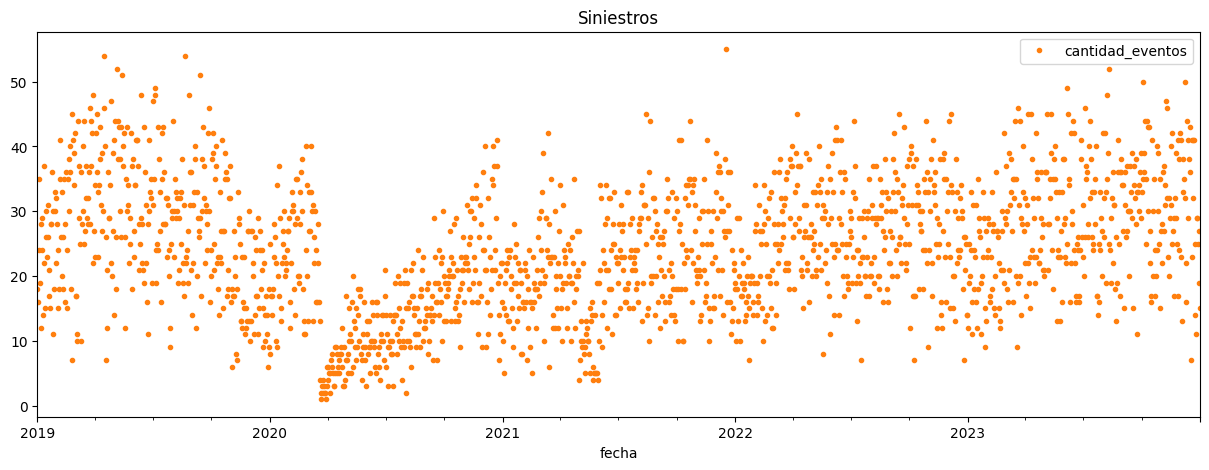

In [ ]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

In [ ]:
print('Cantidad de NaNs:')
for column in df_siniestros:
    nans = df_siniestros[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna cantidad_eventos: 0


Analisis de outliers

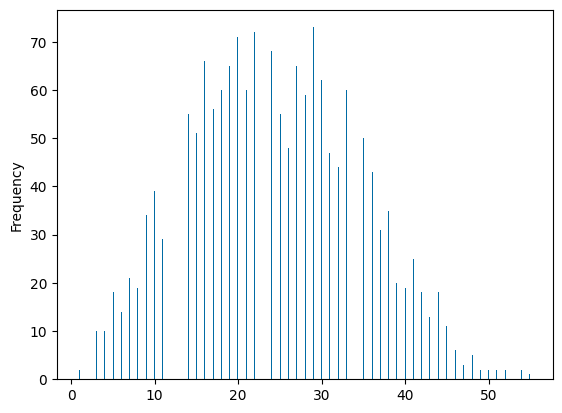

In [ ]:
df_siniestros['cantidad_eventos'].plot(kind='hist', bins=500);

Outliers based on IQR:


cantidad_eventos
fecha                       
2019-04-16                54
2019-08-21                54
2021-12-17                55

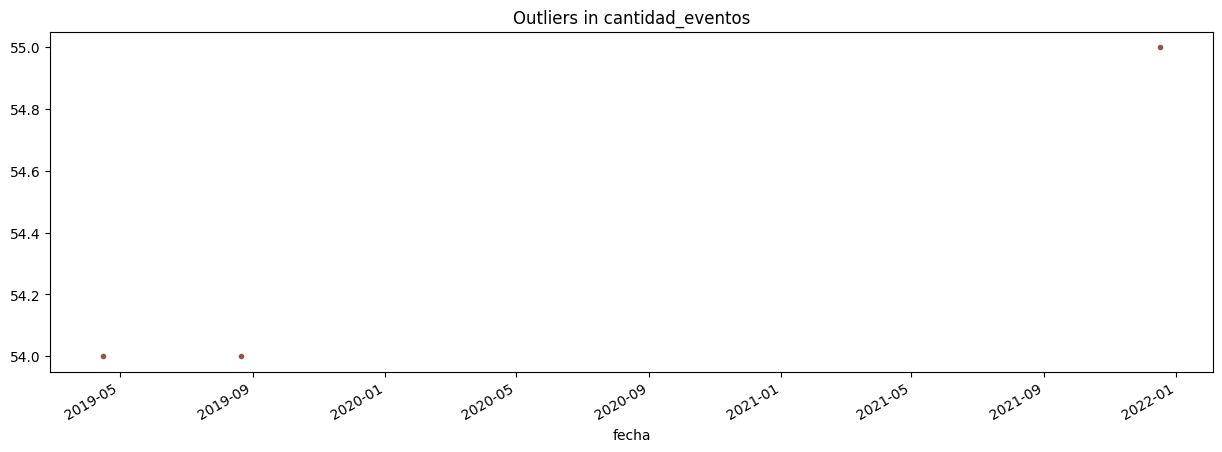

In [ ]:
Q1 = df_siniestros['cantidad_eventos'].quantile(0.25)
Q3 = df_siniestros['cantidad_eventos'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_siniestros[(df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['cantidad_eventos'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in cantidad_eventos')
plt.show()

In [ ]:
#Lo que hago es modificar los outliers por el valor 53, que es el valor menor a que se considere outlier
condicion = (df_siniestros['cantidad_eventos'] < lower_bound) | (df_siniestros['cantidad_eventos'] > upper_bound)
df_siniestros.loc[condicion, 'cantidad_eventos'] = 53

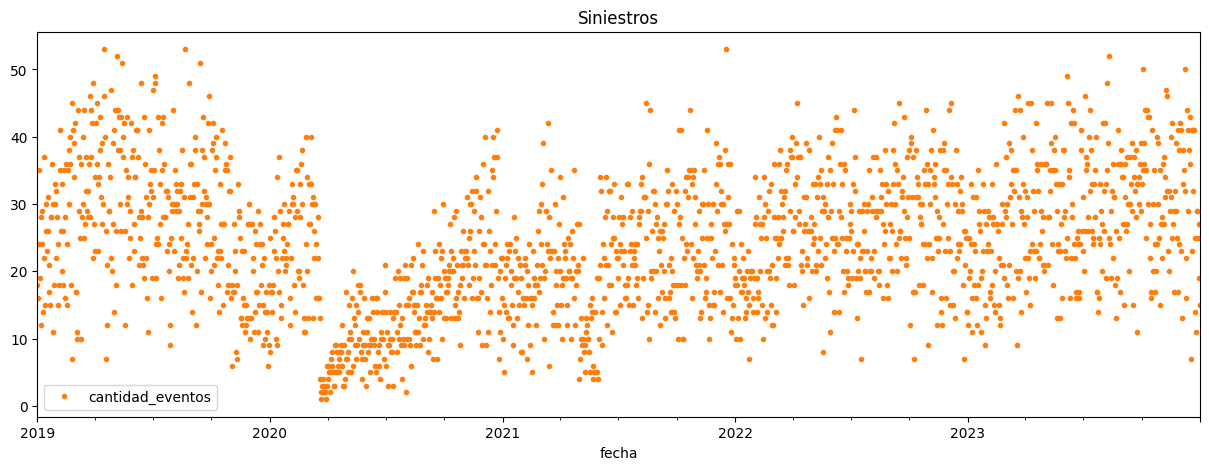

In [ ]:
df_siniestros.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Siniestros')
plt.show()

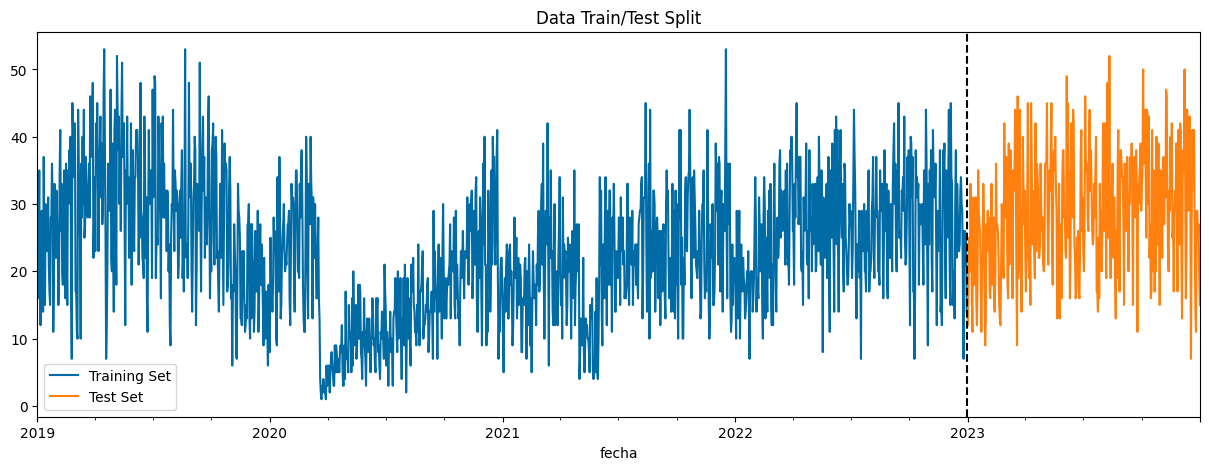

In [ ]:
split_index = int(len(df_siniestros) * 0.8)
train_siniestros = df_siniestros.iloc[:split_index]
test_siniestros = df_siniestros.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_siniestros.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_siniestros.plot(ax=ax, label='Test Set')
ax.axvline(test_siniestros.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

La siguiente línea de código crea un objeto de tipo TimeSeriesSplit que se utiliza para dividir una serie temporal en conjuntos de entrenamiento y prueba para su validación cruzada.
n_splits=5: Indica que se dividirá la serie temporal en 5 conjuntos diferentes  

Gap: se asegura que el conjunto de prueba refleje mejor una situación en la que solo se tiene información hasta un cierto punto en el tiempo, y el modelo debe hacer predicciones futuras basadas en ese conocimiento limitado.

In [ ]:
tss_siniestros = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_siniestros_cv = df_siniestros.sort_index()

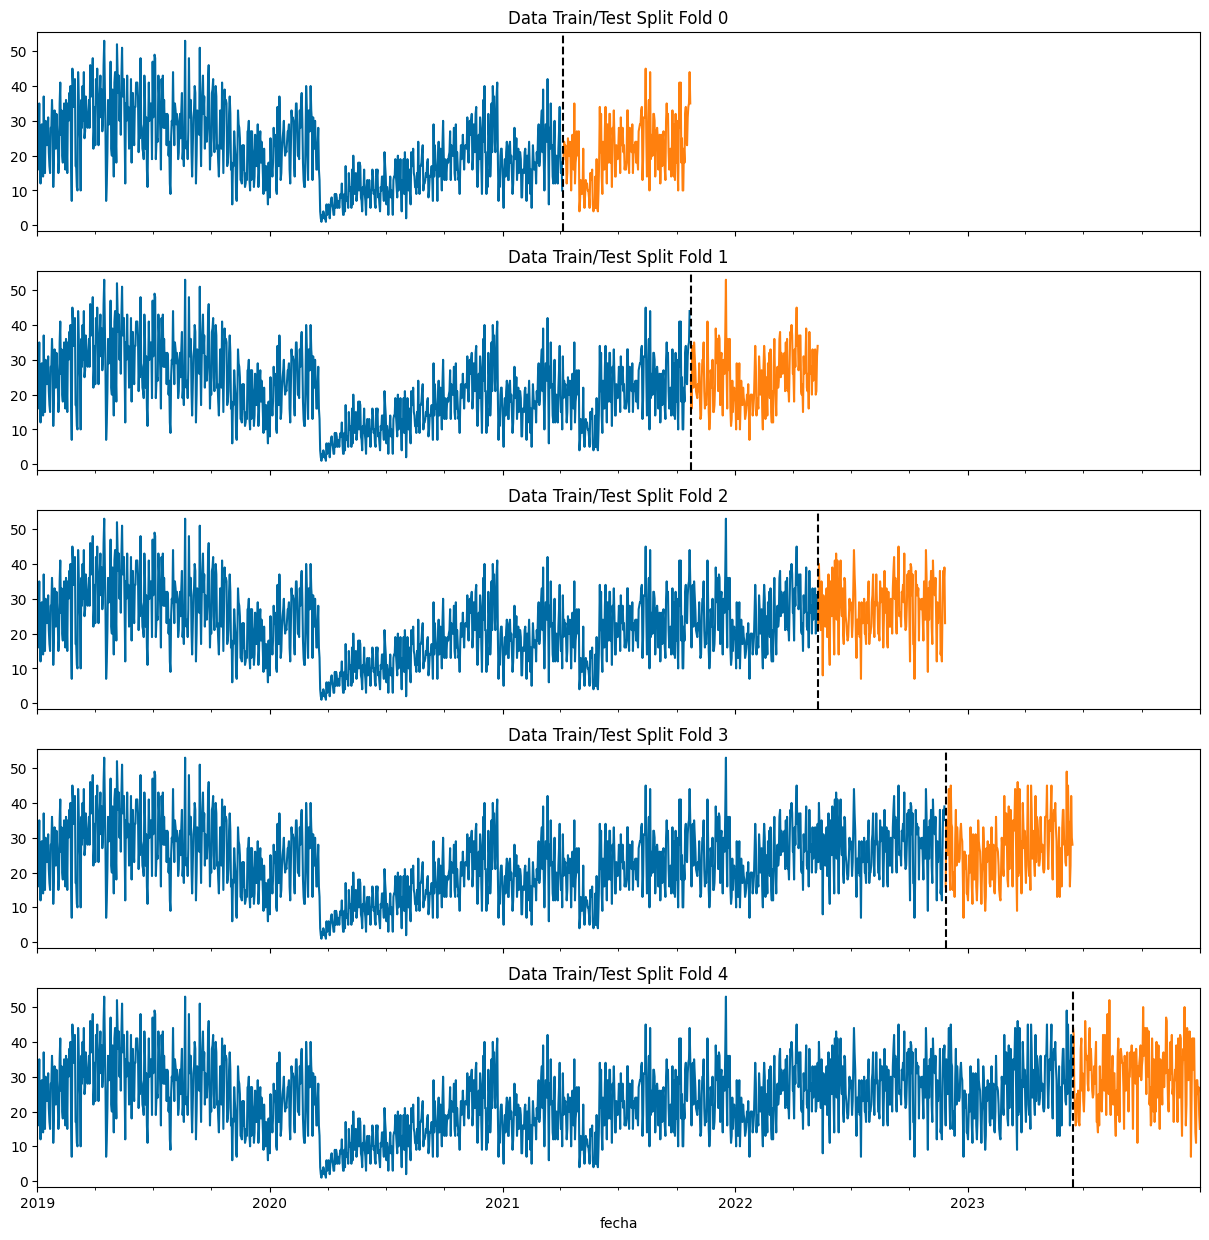

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_siniestros.split(df_siniestros_cv):
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]
    train['cantidad_eventos'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['cantidad_eventos'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
tss_siniestros

TimeSeriesSplit(gap=1, max_train_size=None, n_splits=5, test_size=200)

In [ ]:
for i, (train_index, test_index) in enumerate(tss_siniestros.split(df_siniestros_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df_siniestros_cv = create_features(df_siniestros_cv)

In [ ]:
def add_lags(df):
    target_map = df['cantidad_eventos'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df_siniestros_cv = add_lags(df_siniestros_cv)

In [ ]:
df_siniestros_cv.head(3)

cantidad_eventos  hour  dayofweek  quarter  month  year  \
fecha                                                                 
2019-01-01                18     0          1        1      1  2019   
2019-01-02                16     0          2        1      1  2019   
2019-01-03                24     0          3        1      1  2019   

            dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  
fecha                                                            
2019-01-01          1           1           1   NaN   NaN   NaN  
2019-01-02          2           2           1   NaN   NaN   NaN  
2019-01-03          3           3           1   NaN   NaN   NaN

In [ ]:
tss_siniestros_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_siniestros_cv = df_siniestros_cv.sort_index()

In [ ]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_siniestros_2.split(df_siniestros_cv): #Iterar sobre las particiones
    train = df_siniestros_cv.iloc[train_idx]
    val = df_siniestros_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = 'cantidad_eventos'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10.72343	validation_0-mae:8.78479	validation_1-rmse:8.66924	validation_1-mae:7.04428
[100]	validation_0-rmse:7.57678	validation_0-mae:5.99368	validation_1-rmse:9.14662	validation_1-mae:7.39160
[200]	validation_0-rmse:6.72825	validation_0-mae:5.19142	validation_1-rmse:9.05097	validation_1-mae:7.31285
[300]	validation_0-rmse:6.41834	validation_0-mae:4.90523	validation_1-rmse:9.00338	validation_1-mae:7.30798
[400]	validation_0-rmse:6.24619	validation_0-mae:4.75674	validation_1-rmse:8.97475	validation_1-mae:7.29652
[500]	validation_0-rmse:6.10861	validation_0-mae:4.63473	validation_1-rmse:8.74947	validation_1-mae:7.10669
[600]	validation_0-rmse:6.02094	validation_0-mae:4.55279	validation_1-rmse:8.83730	validation_1-mae:7.16783
[700]	validation_0-rmse:5.91563	validation_0-mae:4.45985	validation_1-rmse:8.87836	validation_1-mae:7.19299
[800]	validation_0-rmse:5.80611	validation_0-mae:4.36608	validation_1-rmse:8.91354	validation_1-mae:7.22781
[900]	validation_0-rmse:5.682

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 8.7535
Fold scores:[np.float64(9.005486829138398), np.float64(9.977221677029037), np.float64(7.2466646612188566), np.float64(9.968252522363656), np.float64(7.569902060516407)]


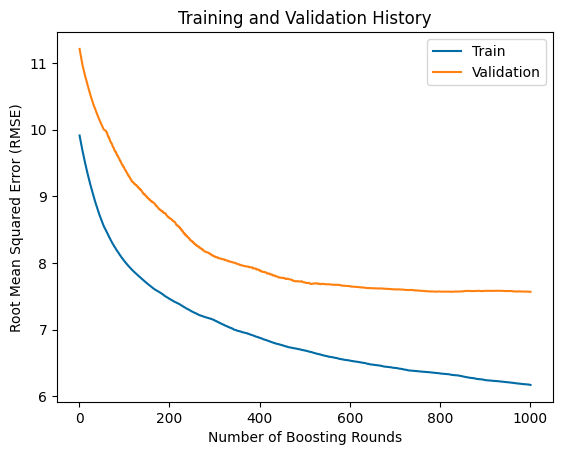

In [ ]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

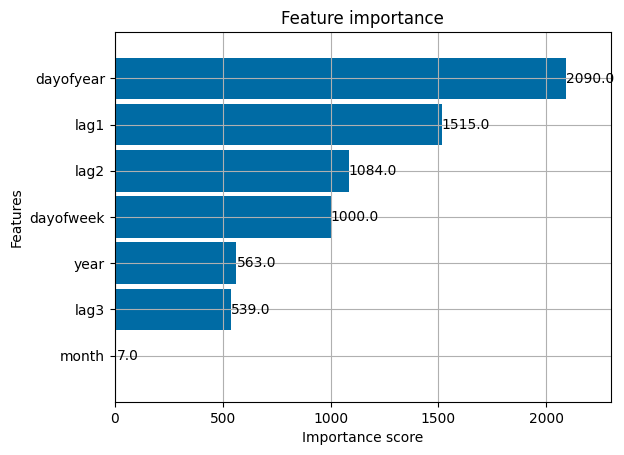

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
y_pred

array([31.672134 , 31.92372  , 24.661922 , 14.929623 , 31.911171 ,
       32.312225 , 34.75364  , 31.895859 , 32.438076 , 24.388754 ,
       17.974316 , 31.25668  , 31.116299 , 31.719484 , 31.659716 ,
       31.772085 , 20.553198 , 19.332201 , 31.071383 , 32.292984 ,
       30.523264 , 33.00002  , 32.239655 , 19.90751  , 19.305956 ,
       29.823807 , 30.890888 , 31.57996  , 31.633322 , 31.894701 ,
       24.095047 , 18.24592  , 31.161789 , 31.121794 , 32.39227  ,
       31.746933 , 31.767645 , 24.23251  , 15.469797 , 31.051857 ,
       30.87434  , 32.397186 , 31.49189  , 34.87072  , 24.108192 ,
       17.069826 , 31.37758  , 31.059227 , 31.902851 , 31.55214  ,
       33.84128  , 20.555191 , 17.996067 , 30.411999 , 32.005554 ,
       33.72912  , 32.694405 , 29.418163 , 20.595436 , 17.996067 ,
       29.55678  , 32.209858 , 30.01621  , 32.003067 , 29.088133 ,
       24.638527 , 17.410774 , 31.497196 , 31.99478  , 32.81379  ,
       32.694405 , 31.869461 , 24.1896   , 17.410774 , 31.1438

In [ ]:
val['prediction'] = reg.predict(X_val)

In [ ]:
val['prediction']

fecha
2023-06-15    31.672134
2023-06-16    31.923719
2023-06-17    24.661922
2023-06-18    14.929623
2023-06-19    31.911171
                ...    
2023-12-27    26.831644
2023-12-28    26.872234
2023-12-29    25.024164
2023-12-30    20.233740
2023-12-31    10.868751
Name: prediction, Length: 200, dtype: float32

In [ ]:
val

cantidad_eventos  hour  dayofweek  quarter  month  year  \
fecha                                                                 
2023-06-15                44     0          3        2      6  2023   
2023-06-16                42     0          4        2      6  2023   
2023-06-17                24     0          5        2      6  2023   
2023-06-18                22     0          6        2      6  2023   
2023-06-19                16     0          0        2      6  2023   
...                      ...   ...        ...      ...    ...   ...   
2023-12-27                29     0          2        4     12  2023   
2023-12-28                25     0          3        4     12  2023   
2023-12-29                27     0          4        4     12  2023   
2023-12-30                19     0          5        4     12  2023   
2023-12-31                15     0          6        4     12  2023   

            dayofyear  dayofmonth  weekofyear  lag1  lag2  lag3  prediction  
fecha                                                                        
2023-06-15        166          15          24  28.0  32.0  16.0   31.672134  
2023-06-16        167          16          24  25.0  32.0   8.0   31.923719  
2023-06-17        168          17          24  33.0  18.0   9.0   24.661922  
2023-06-18        169          18          24  20.0  24.0   6.0   14.929623  
2023-06-19        170          19          25  17.0  11.0   4.0   31.911171  
...               ...         ...         ...   ...   ...   ...         ...  
2023-12-27        361          27          52  21.0  21.0  22.0   26.831644  
2023-12-28        362          28          52  25.0  22.0  16.0   26.872234  
2023-12-29        363          29          52  14.0  19.0  10.0   25.024164  
2023-12-30        364          30          52  14.0  18.0   5.0   20.233740  
2023-12-31        365          31          52  12.0  10.0  15.0   10.868751  

[200 rows x 13 columns]

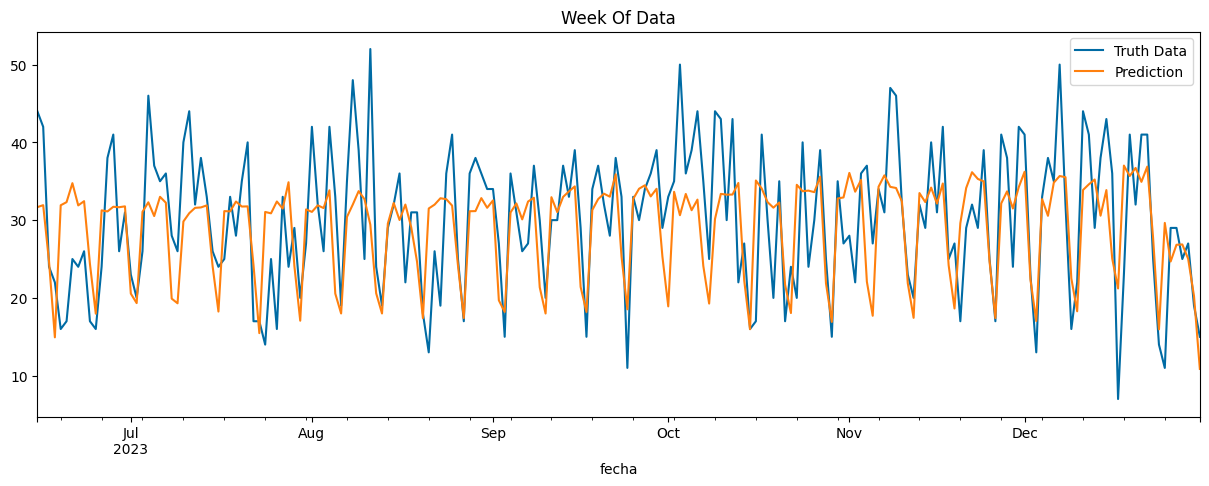

In [ ]:
ax = val.loc[(val.index >= '2017-08-03')]['cantidad_eventos'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 57.30341720581055
Mean Absolute Error (MAE): 5.988396644592285
RMSE Score on Test set: 7.57


[I 2025-10-18 23:59:50,803] A new study created in memory with name: no-name-96030ce1-0e46-4243-b600-9f76af7bbc4e
[I 2025-10-18 23:59:52,931] Trial 0 finished with value: 7.464249981205954 and parameters: {'n_estimators': 145, 'max_depth': 7, 'learning_rate': 0.034606564373156484, 'subsample': 0.6096477118823141, 'colsample_bytree': 0.8182497961277586, 'reg_alpha': 0.018685289085370756, 'reg_lambda': 7.348585341992409e-05}. Best is trial 0 with value: 7.464249981205954.
[I 2025-10-18 23:59:54,410] Trial 1 finished with value: 8.051347402875681 and parameters: {'n_estimators': 527, 'max_depth': 4, 'learning_rate': 0.0818043616571243, 'subsample': 0.8717609955882086, 'colsample_bytree': 0.8378925335003028, 'reg_alpha': 3.784488659697783e-08, 'reg_lambda': 0.0005381654121216019}. Best is trial 0 with value: 7.464249981205954.
[I 2025-10-18 23:59:55,259] Trial 2 finished with value: 7.615030547353534 and parameters: {'n_estimators': 251, 'max_depth': 6, 'learning_rate': 0.07247353639556328

Best hyperparameters:  {'n_estimators': 209, 'max_depth': 3, 'learning_rate': 0.01991994056177912, 'subsample': 0.6534897099845803, 'colsample_bytree': 0.8761856516076254, 'reg_alpha': 0.1993598847126881, 'reg_lambda': 6.992076728216693e-08}
Best RMSE:  7.388536392175007


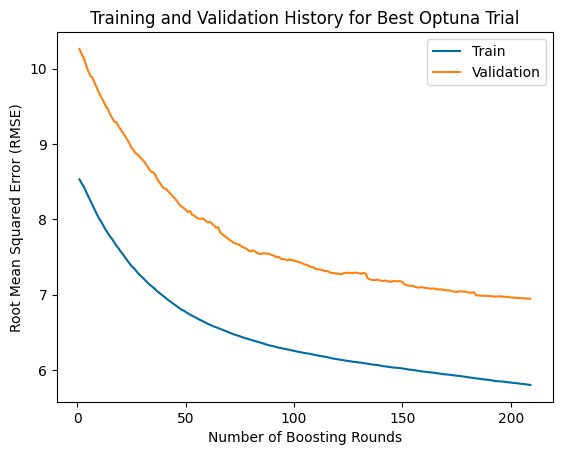

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_siniestros_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = 'cantidad_eventos'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

## Entrenamiento del modelo final

Entrenar el modelo XGBoost con los mejores hiperparámetros encontrados por Optuna en el conjunto de datos completo de entrenamiento.

In [ ]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = 'cantidad_eventos'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_siniestros_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8761856516076254, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01991994056177912,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=209, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 7.93
Final Model MAE on Test Set: 6.25


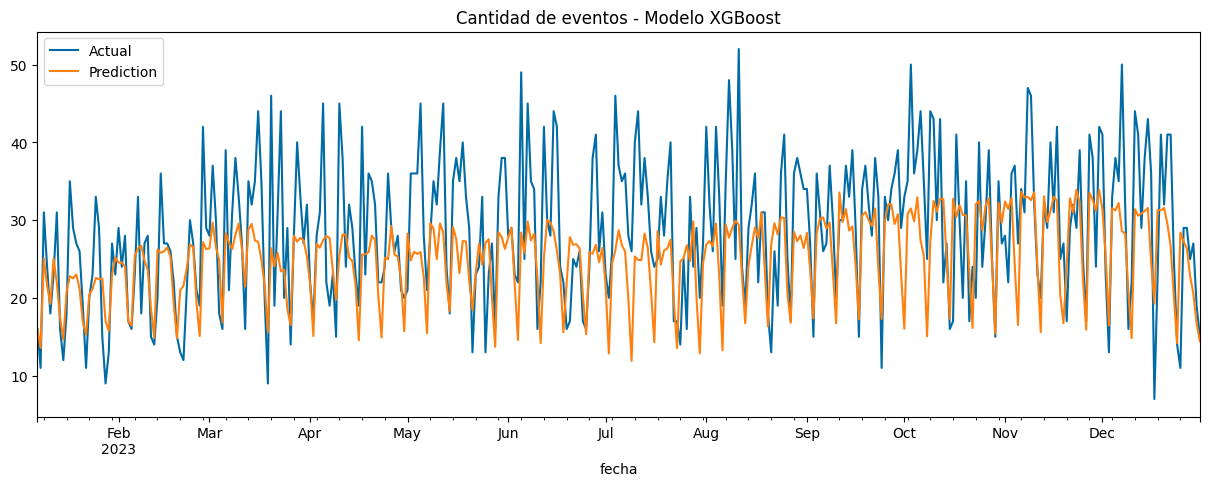

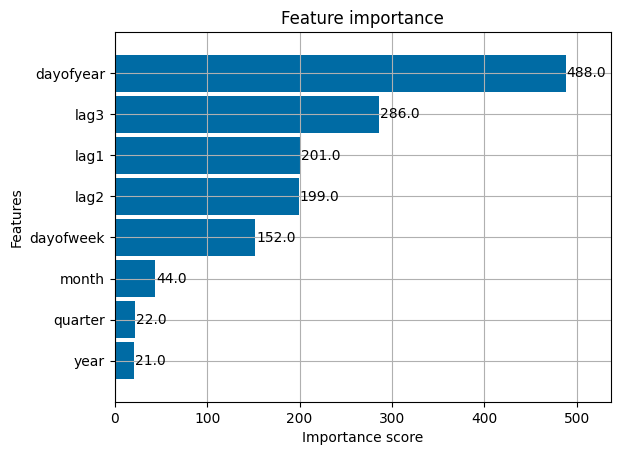

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Cantidad de eventos - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

IMPORTANTE: En este punto reiniciar session de colab antes de descargar los pesos del modelo

In [ ]:
# 2. Importaciones y carga del modelo
import timesfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True, # Importante para siniestros, que no pueden ser negativos
        fix_quantile_crossing=True,
    )
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 3. Preparación de tus datos
HORIZON = 30 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_siniestros_TFM = df_siniestros.copy()
split_index = int(len(data_siniestros_TFM) * 0.8)
train_siniestros_TFM = data_siniestros_TFM[:split_index]
test_siniestros_TFM = data_siniestros_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_siniestros_TFM['cantidad_eventos'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [ ]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_siniestros = point_forecast[0]

print(f"Se generaron {len(prediccion_siniestros)} predicciones para los próximos {HORIZON} días.")

Se generaron 30 predicciones para los próximos 30 días.


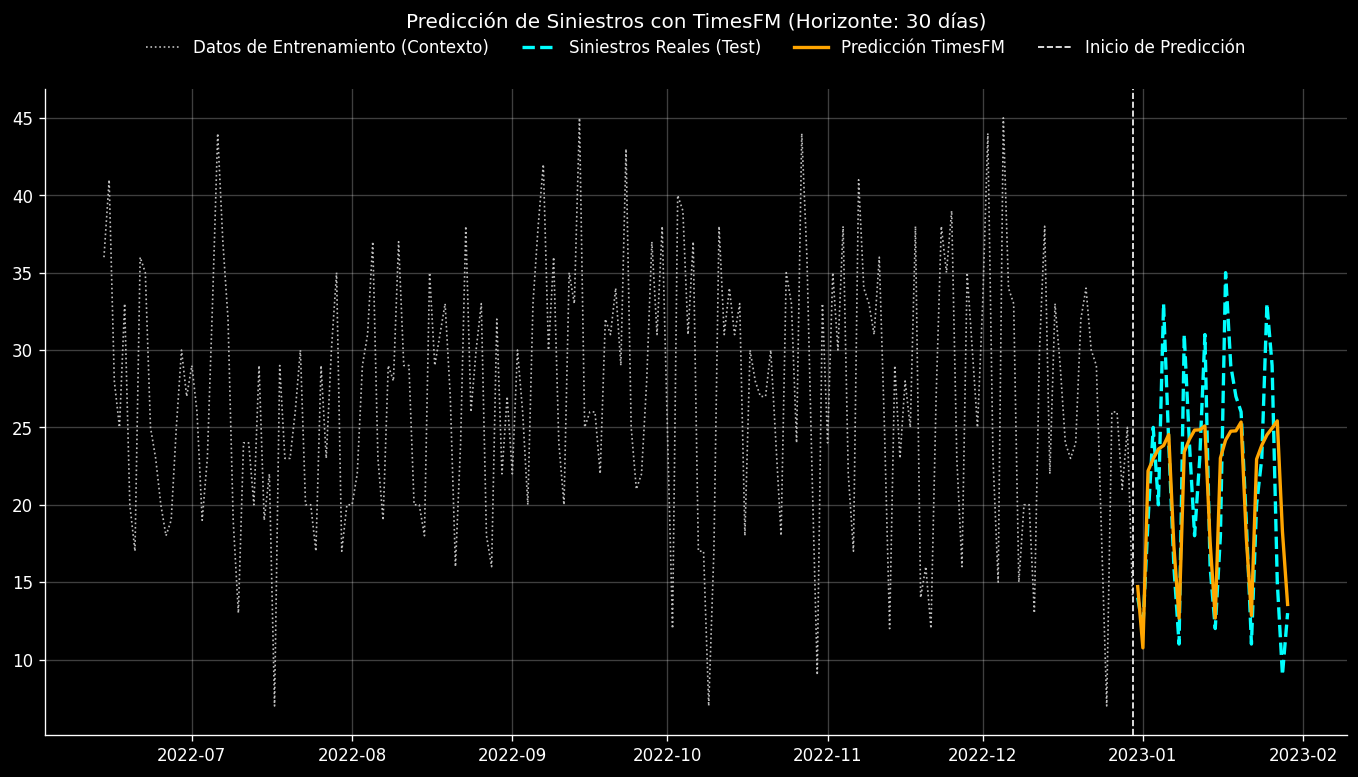

In [ ]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_siniestros_TFM['cantidad_eventos'].iloc[:HORIZON].values,
    'Predichos': prediccion_siniestros
}, index=test_siniestros_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_siniestros_TFM.index[-200:], train_siniestros_TFM['cantidad_eventos'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Siniestros Reales (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_siniestros_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Siniestros con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_resultados['Reales'], df_resultados['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.69
Raíz del Error Cuadrático Medio (RMSE): 4.92


## TimesFM_2

Forma de los datos de entrada para el modelo: (4, 365)
Se generaron 30 predicciones para los próximos 30 días.


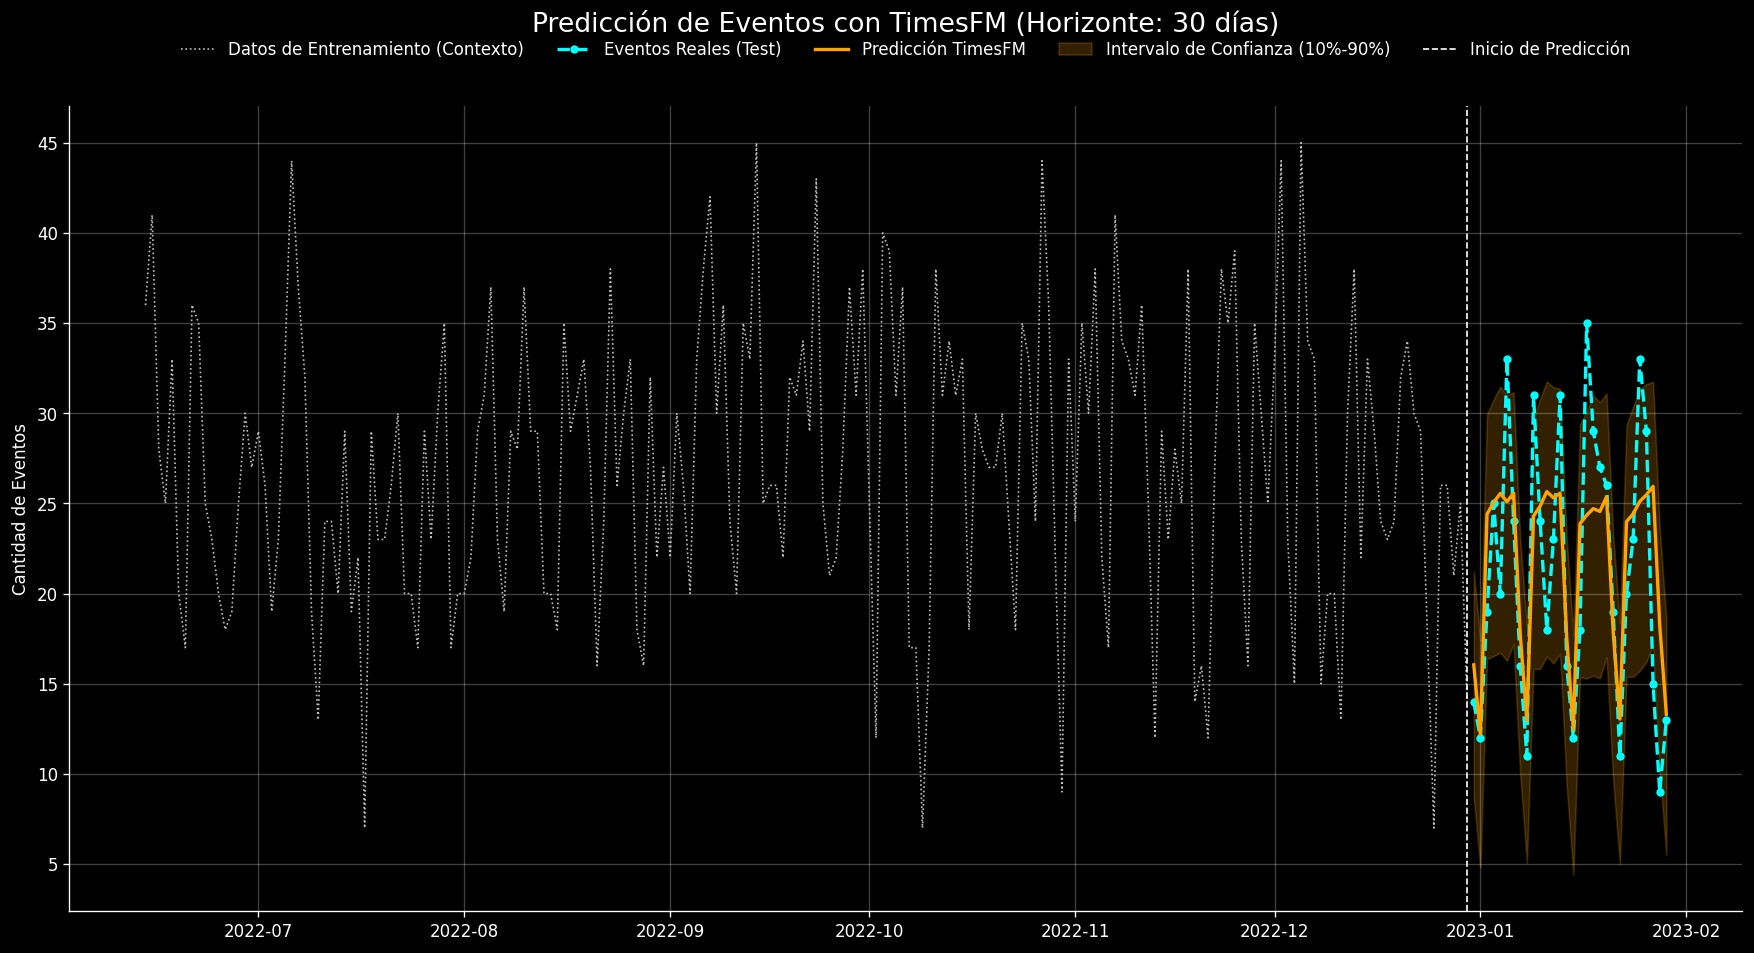

In [ ]:
from sklearn.preprocessing import StandardScaler
# Configurar el modelo para la inferencia
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True,
        fix_quantile_crossing=True,
    )
)

# ==============================================================================
# PASO 2: PREPARACIÓN DE DATOS Y FEATURE ENGINEERING
# ==============================================================================
# --- Asegúrate de que tu DataFrame 'df_siniestros' esté cargado aquí ---
# Por ejemplo:
# df_siniestros = pd.read_csv('tus_datos.csv', parse_dates=['fecha'], index_col='fecha')


# Definir la columna objetivo y el horizonte
TARGET_COLUMN = 'cantidad_eventos'
HORIZON = 30
CONTEXT_WINDOW = 365 # Puedes experimentar cambiando este valor (ej. 365)

# Crear características basadas en la fecha
# Es crucial que el índice de tu DataFrame sea de tipo DatetimeIndex
df_siniestros_featured = df_siniestros.copy()
df_siniestros_featured['dia_de_semana'] = df_siniestros_featured.index.dayofweek
df_siniestros_featured['dia_del_mes'] = df_siniestros_featured.index.day
df_siniestros_featured['mes'] = df_siniestros_featured.index.month

# Normalizar las nuevas características
scaler = StandardScaler()
features_to_scale = ['dia_de_semana', 'dia_del_mes', 'mes']
df_siniestros_featured[features_to_scale] = scaler.fit_transform(
    df_siniestros_featured[features_to_scale]
)

# Dividir en datos de entrenamiento y prueba
split_index = int(len(df_siniestros_featured) * 0.8)
train_data = df_siniestros_featured[:split_index]
test_data = df_siniestros_featured[split_index:]

# ==============================================================================
# PASO 3: PREPARAR INPUTS PARA EL MODELO
# ==============================================================================
# Definir las columnas que usaremos, con la objetivo SIEMPRE PRIMERO
feature_columns = [TARGET_COLUMN] + features_to_scale

# Extraer el contexto del final del set de entrenamiento
context_data = train_data[feature_columns][-CONTEXT_WINDOW:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs = context_data.T

print(f"Forma de los datos de entrada para el modelo: {model_inputs.shape}")

# ==============================================================================
# PASO 4: REALIZAR LA PREDICCIÓN
# ==============================================================================
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=model_inputs
)

# Extraer la predicción principal y los cuantiles para el intervalo de confianza
predicted_values = point_forecast[0]
q10 = quantile_forecast[0, :, 1] # Cuantil 10
q90 = quantile_forecast[0, :, 8] # Cuantil 90

print(f"Se generaron {len(predicted_values)} predicciones para los próximos {HORIZON} días.")

# ==============================================================================
# PASO 5: VISUALIZACIÓN DE RESULTADOS
# ==============================================================================
# Crear un DataFrame para facilitar la comparación
df_results = pd.DataFrame({
    'Reales': test_data[TARGET_COLUMN].iloc[:HORIZON].values,
    'Predichos': predicted_values,
    'Cuantil_10': q10,
    'Cuantil_90': q90
}, index=test_data.index[:HORIZON])

# Graficar los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8), dpi=120)

# 1. Datos de entrenamiento (últimos 200 puntos como contexto)
ax.plot(train_data.index[-200:], train_data[TARGET_COLUMN][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# 2. Datos reales del período de prueba
ax.plot(df_results.index, df_results['Reales'],
        ls='--', lw=2, marker='o', markersize=4, color='cyan', label='Eventos Reales (Test)')

# 3. Predicción puntual del modelo
ax.plot(df_results.index, df_results['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# 4. Intervalo de confianza
ax.fill_between(df_results.index, df_results['Cuantil_10'], df_results['Cuantil_90'],
                color='orange', alpha=0.2, label='Intervalo de Confianza (10%-90%)')

# 5. Línea vertical para marcar el inicio de la predicción
ax.axvline(train_data.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.legend(frameon=False, ncols=5, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Eventos con TimesFM (Horizonte: {HORIZON} días)", y=1.08, fontsize=16)
ax.set_ylabel("Cantidad de Eventos")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

Resultados de las métricas de error:
Error Absoluto Medio (MAE): 3.86
Raíz del Error Cuadrático Medio (RMSE): 5.02


## Chronos

In [ ]:
## Parametros
pipeline = ChronosPipeline.from_pretrained(
    #"amazon/chronos-t5-small",
    "amazon/chronos-t5-large",
    device_map="auto",  # "cpu" o "mps" para Apple Silicon  cuda
    torch_dtype=torch.bfloat16,
)

In [ ]:
## Parametros de prediccion
step_to_predict= 45  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 2 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [ ]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_siniestros["cantidad_eventos"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_siniestros), len(df_siniestros) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

In [ ]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[32.9740, 36.0847, 31.9371, 36.9143, 25.0934, 23.0196, 25.9229, 30.0706,
         19.0793, 23.0196, 12.0282, 23.0196, 20.9457, 13.0652, 34.0109, 27.9968,
         21.9827, 30.9001, 19.0793, 17.0054, 13.0652, 20.9457, 34.0109, 36.9143,
         24.0565, 19.0793, 18.0424, 24.0565, 24.0565, 30.0706, 23.0196, 41.0619,
         25.0934, 31.9371,  9.9544, 19.9088, 27.9968, 25.0934, 36.0847, 36.0847,
         31.9371, 19.0793, 21.9827, 30.9001, 20.9457],
        [29.0337, 36.0847, 31.9371, 29.0337, 20.9457, 32.9740, 18.0424, 31.9371,
         40.0250, 31.9371, 37.9512, 34.0109, 12.0282, 20.9457, 37.9512, 20.9457,
         25.0934, 25.9229, 26.9599, 15.9685, 24.0565, 24.0565, 25.0934, 24.0565,
         27.9968, 31.9371, 18.0424, 19.9088, 19.9088, 19.0793, 26.9599, 24.0565,
         25.0934, 30.9001, 12.0282, 19.9088, 30.0706, 21.9827, 23.0196, 29.0337,
         21.9827, 12.0282, 23.0196, 14.1021, 26.9599]])


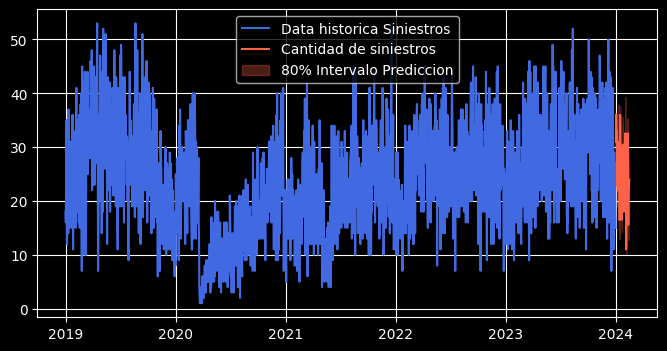

In [ ]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_siniestros["cantidad_eventos"], color="royalblue", label="Data historica Siniestros")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Cantidad de siniestros")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [ ]:
import pandas as pd
import torch
from chronos import BaseChronosPipeline

In [ ]:
n_test = 25
df_siniestros_chronos_train = df_siniestros[:-n_test]
df_siniestros_chronos_test = df_siniestros[-n_test:]

In [ ]:
df_siniestros_chronos_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-12-07 to 2023-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   cantidad_eventos  25 non-null     int64
dtypes: int64(1)
memory usage: 400.0 bytes


In [ ]:
fechas_train = df_siniestros_chronos_train.index
fechas_test = df_siniestros_chronos_test.index

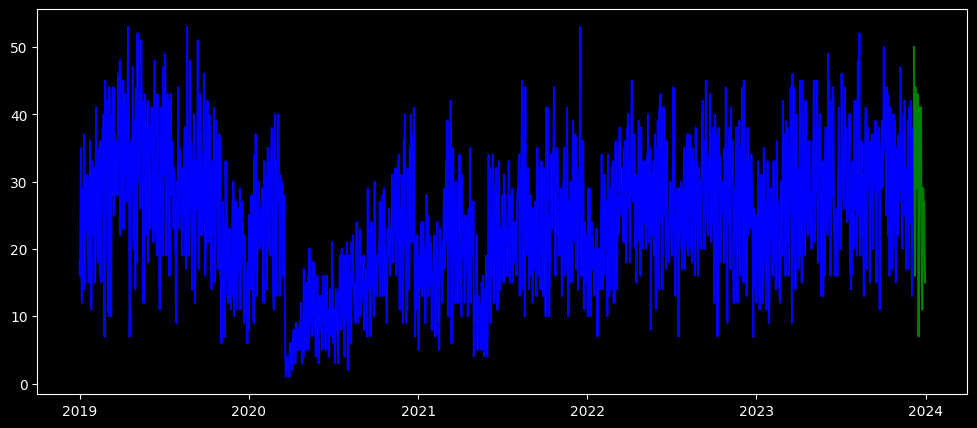

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_siniestros_chronos_train["cantidad_eventos"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_siniestros_chronos_test ["cantidad_eventos"], label="Test real", color="green")

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [ ]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [ ]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

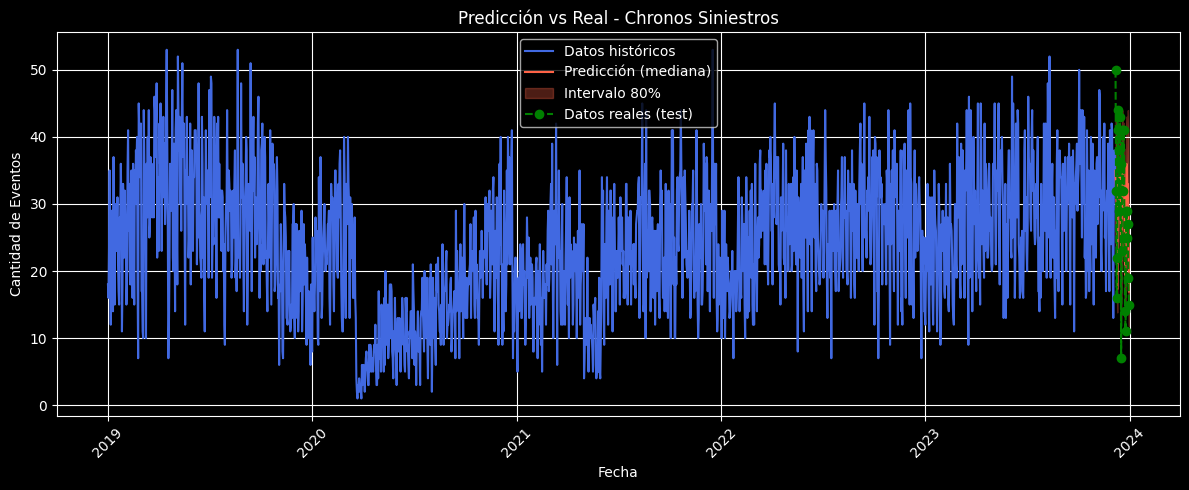

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_siniestros_chronos_test["cantidad_eventos"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_siniestros_chronos_train["cantidad_eventos"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Siniestros")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 8.11
Chronos Model MAE on Test Set: 7.08


## AutoML

In [ ]:
# AUTOTS APLICADO A SINIESTROS
import time # Import the time module

print("\n--- Iniciando análisis de Siniestros con AutoTS (Versión Rápida) ---")

# Usamos una copia para asegurar que el DataFrame original no se modifica
df_target = df_siniestros.copy()
target_col = 'cantidad_eventos'

# Convertir el índice 'fecha' en una columna
df_target.reset_index(inplace=True)

# División 80/20 para entrenamiento y prueba
split_point = math.trunc(len(df_target) * 0.8)
train_data = df_target.iloc[:split_point]
test_data = df_target.iloc[split_point:]
print(f"Tamaño de entrenamiento: {len(train_data)}, Tamaño de prueba: {len(test_data)}")


model_siniestros_autots = AutoTS(
    forecast_length=len(test_data),
    frequency='D',
    prediction_interval=0.95,
    ensemble='simple',
    model_list='fast',
    max_generations=3,
    num_validations=1,
    no_negatives=True,
    n_jobs='auto'
)

print("\nEntrenando modelo AutoTS (configuración rápida)...")
start_time = time.time() # Start the timer
model_siniestros_autots.fit(train_data, date_col='fecha', value_col=target_col)
end_time = time.time() # Stop the timer
print(f"Tiempo de entrenamiento del modelo AutoTS: {end_time - start_time:.2f} segundos") # Print the elapsed time


# Predicción
prediction = model_siniestros_autots.predict()
forecast = prediction.forecast

# Preparar el DataFrame de test para graficar
test_data.set_index('fecha', inplace=True)

# Evaluación y almacenamiento de métricas
print("\n--- Resumen del Modelo Seleccionado ---")
print(model_siniestros_autots)
mae = mean_absolute_error(test_data[target_col], forecast[target_col])
rmse = np.sqrt(mean_squared_error(test_data[target_col], forecast[target_col]))
autots_results_summary['Siniestros'] = {'MAE': mae, 'RMSE': rmse}
print(f"\n--- Métricas en Test --- \nMAE: {mae:.4f} \nRMSE: {rmse:.4f}")


--- Iniciando análisis de Siniestros con AutoTS (Versión Rápida) ---
Tamaño de entrenamiento: 1460, Tamaño de prueba: 366
Using 1 cpus for n_jobs.

Entrenando modelo AutoTS (configuración rápida)...
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 3
Model Number: 2 with model AverageValueNaive in generation 0 of 3
Model Number: 3 with model AverageValueNaive in generation 0 of 3
Model Number: 4 with model DatepartRegression in generation 0 of 3
Model Number: 5 with model DatepartRegression in generation 0 of 3
Model Number: 6 with model DatepartRegression in generation 0 of 3
Model Number: 7 with model DatepartRegression in generation 0 of 3
Epoch 1/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3987
Epoch 2/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3833
Epoch 3/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3735
Epoch 4/50
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3647
Epoch 5/50
35/35 ━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Model Number: 31 with model VECM in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VECM') in model 31 in generation 0: VECM
Model Number: 32 with model UnivariateMotif in generation 0 of 3
Model Number: 33 with model UnivariateMotif in generation 0 of 3
Model Number: 34 with model SectionalMotif in generation 0 of 3
Model Number: 35 with model SectionalMotif in generation 0 of 3
Model Number: 36 with model SeasonalNaive in generation 0 of 3
Model Number: 37 with model DatepartRegression in generation 0 of 3
Model Number: 38 with model NVAR in generation 0 of 3
Model Number: 39 with model Cassandra in generation 0 of 3
Model Number: 40 with model SeasonalityMotif in generation 0 of 3
Model Number: 41 with model Cassandra in generation 0 of 3
Model Number: 42 with model Cassandra in generation 0 of 3
Model Number: 43 with model Cassandra in generation 0 of 3
Model Number: 44 with model NVAR in generation 0 of 3
Model Number: 45 with model BallTreeMultivariat

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 58 with model ETS in generation 0 of 3
Model Number: 59 with model VAR in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VAR') in model 59 in generation 0: VAR
Model Number: 60 with model VECM in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VECM') in model 60 in generation 0: VECM
Model Number: 61 with model WindowRegression in generation 0 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 61 in generation 0: WindowRegression
Model Number: 62 with model DatepartRegression in generation 0 of 3
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {'constant': 0, 'reintroduction_model': {'model': 'SGD', 'model_params': {}, 'datepart_method': 'simple_binarized'}, 'fillna': 'mean'}} with error ValueError('The number of classes has to be greater than one; got 1 class')") in model 62 in generation 0: DatepartRegression
Mo

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 164 with model LastValueNaive in generation 0 of 3
Model Number: 165 with model FFT in generation 0 of 3
Model Number: 166 with model DatepartRegression in generation 0 of 3
New Generation: 1 of 3
Model Number: 167 with model GLS in generation 1 of 3
Model Number: 168 with model ETS in generation 1 of 3
Model Number: 169 with model SeasonalNaive in generation 1 of 3
Model Number: 170 with model GLS in generation 1 of 3
Model Number: 171 with model BasicLinearModel in generation 1 of 3
Model Number: 172 with model SeasonalityMotif in generation 1 of 3
Model Number: 173 with model SeasonalityMotif in generation 1 of 3
Model Number: 174 with model WindowRegression in generation 1 of 3
Model Number: 175 with model ETS in generation 1 of 3
Model Number: 176 with model DatepartRegression in generation 1 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 176 in generation 1: DatepartRegression
Model Number: 177 with model Cassa

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 391 in generation 2: GLM
Model Number: 392 with model GLM in generation 2 of 3
Template Eval Error: Exception("Transformer BTCD failed on fit from params None {'0': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 1}, '1': {}} with error ValueError('BTCD only works on multivarate series')") in model 392 in generation 2: GLM
Model Number: 393 with model WindowRegression in generation 2 of 3
Model Number: 394 with model ETS in generation 2 of 3
Model Number: 395 with model SectionalMotif in generation 2 of 3
Model Number: 396 with model UnivariateMotif in generation 2 of 3
New Generation: 3 of 3
Model Number: 397 with model DatepartRegression in generation 3 of 3
Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.5865
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5736
Epoch

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


16 - FFT with avg smape 41.44: 
Model Number: 17 of 77 with model BasicLinearModel for Validation 1
17 - BasicLinearModel with avg smape 39.41: 
Model Number: 18 of 77 with model FFT for Validation 1
18 - FFT with avg smape 41.56: 
Model Number: 19 of 77 with model SeasonalNaive for Validation 1
19 - SeasonalNaive with avg smape 34.32: 
Model Number: 20 of 77 with model ETS for Validation 1
📈 20 - ETS with avg smape 29.51: 
Model Number: 21 of 77 with model DatepartRegression for Validation 1
21 - DatepartRegression with avg smape 43.06: 
Model Number: 22 of 77 with model DatepartRegression for Validation 1
22 - DatepartRegression with avg smape 86.43: 
Model Number: 23 of 77 with model FFT for Validation 1
23 - FFT with avg smape 39.9: 
Model Number: 24 of 77 with model SeasonalNaive for Validation 1
24 - SeasonalNaive with avg smape 31.22: 
Model Number: 25 of 77 with model SeasonalNaive for Validation 1
25 - SeasonalNaive with avg smape 36.01: 
Model Number: 26 of 77 with model Seas

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


36 - GLM with avg smape 43.42: 
Model Number: 37 of 77 with model FFT for Validation 1
37 - FFT with avg smape 52.18: 
Model Number: 38 of 77 with model DatepartRegression for Validation 1
Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3947
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3885
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3815
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3701
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3649
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3608
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3514
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3538
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3481
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3463
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3445
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3440
Epoch 13/50
23/23 ━━━━━━━━━━

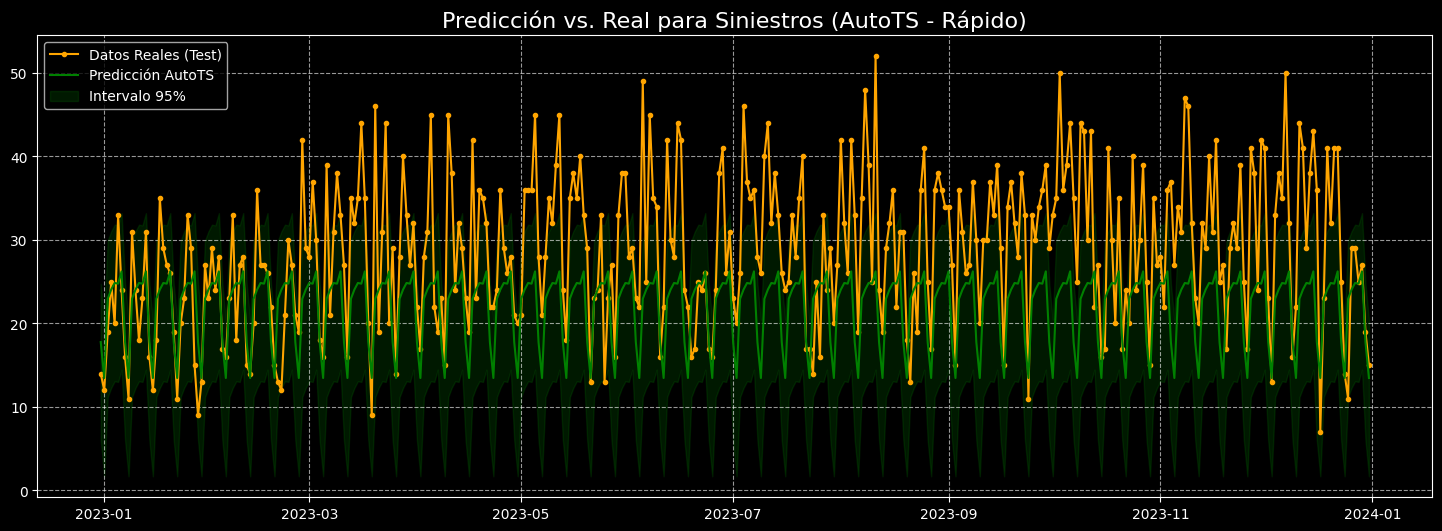

In [ ]:
# Visualización
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(test_data.index, test_data[target_col], label='Datos Reales (Test)', color='orange', marker='o', markersize=3)
ax.plot(forecast.index, forecast[target_col], label='Predicción AutoTS', color='green')

# Accedemos directamente a lower/upper_forecast.
lower_forecast = prediction.lower_forecast
upper_forecast = prediction.upper_forecast
ax.fill_between(forecast.index, lower_forecast[target_col], upper_forecast[target_col], color='green', alpha=0.2, label='Intervalo 95%')

ax.set_title('Predicción vs. Real para Siniestros (AutoTS - Rápido)', fontsize=16)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Precipitaciones

In [ ]:
df_precipitaciones.rename(columns={'Unnamed: 0': 'fecha'}, inplace=True)
df_precipitaciones.head()

fecha  (mm)
0 2019-01-01   2.0
1 2019-01-02   9.0
2 2019-01-03   0.0
3 2019-01-04   0.0
4 2019-01-05   1.0

In [ ]:
df_precipitaciones.set_index('fecha', inplace=True)

## XGBoost

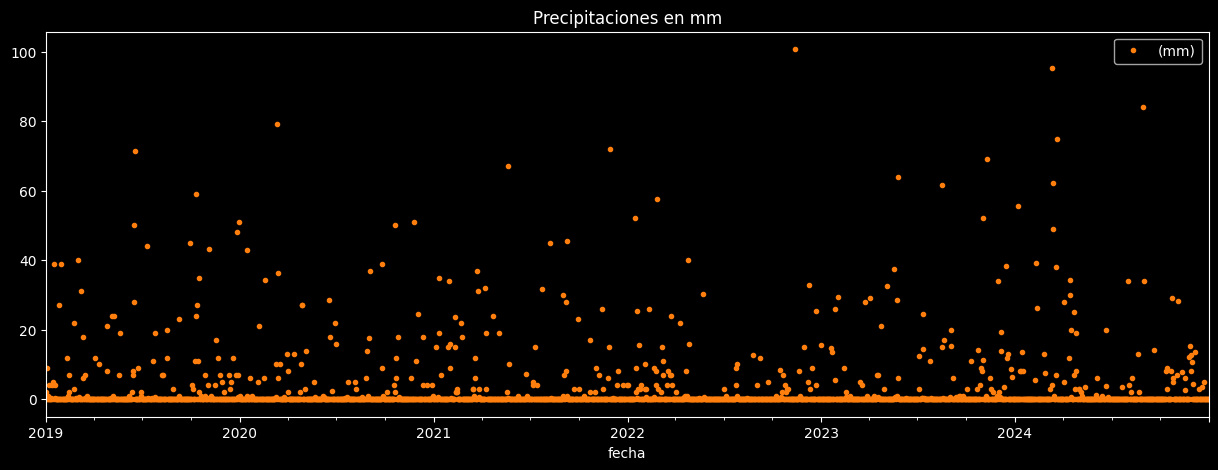

In [ ]:
df_precipitaciones.plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='Precipitaciones en mm')
plt.show()

In [ ]:
print('Cantidad de NaNs:')
for column in df_precipitaciones:
    nans = df_precipitaciones[column].isna().sum()
    print(f'\tColumna {column}: {nans}')

Cantidad de NaNs:
	Columna (mm): 0


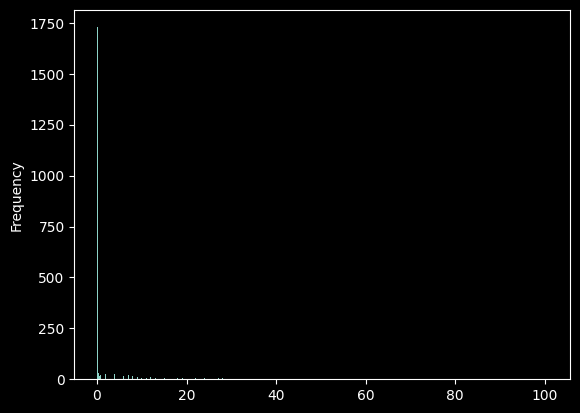

In [ ]:
df_precipitaciones['(mm)'].plot(kind='hist', bins=500);

Outliers based on IQR:


(mm)
fecha           
2019-01-01   2.0
2019-01-02   9.0
2019-01-05   1.0
2019-01-06   4.0
2019-01-10   0.4
...          ...
2024-12-01   4.5
2024-12-05  13.7
2024-12-13   3.0
2024-12-18   3.5
2024-12-23   5.0

[504 rows x 1 columns]

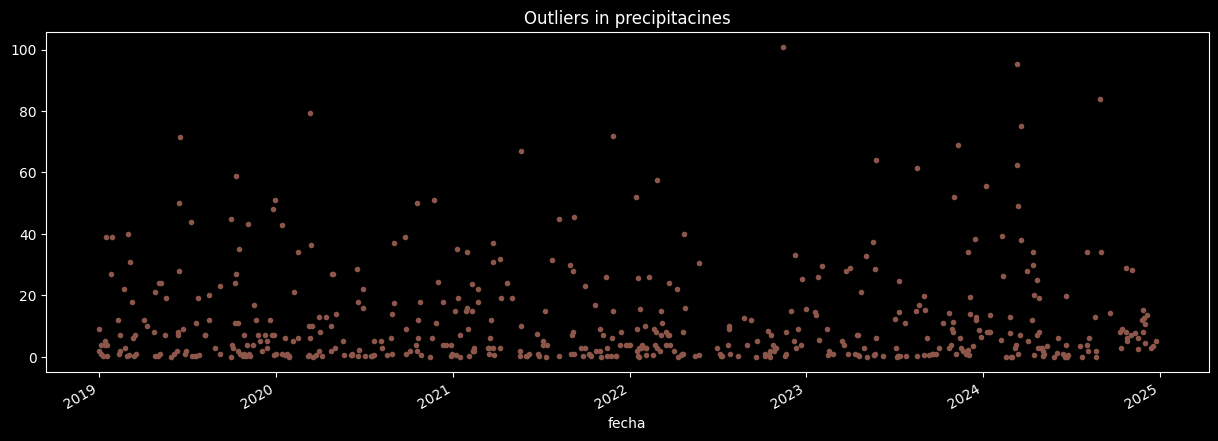

In [ ]:
Q1 = df_precipitaciones['(mm)'].quantile(0.25)
Q3 = df_precipitaciones['(mm)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_precipitaciones[(df_precipitaciones['(mm)'] < lower_bound) | (df_precipitaciones['(mm)'] > upper_bound)]

print("Outliers based on IQR:")
display(outliers)

outliers['(mm)'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[5],
        title='Outliers in precipitacines')
plt.show()

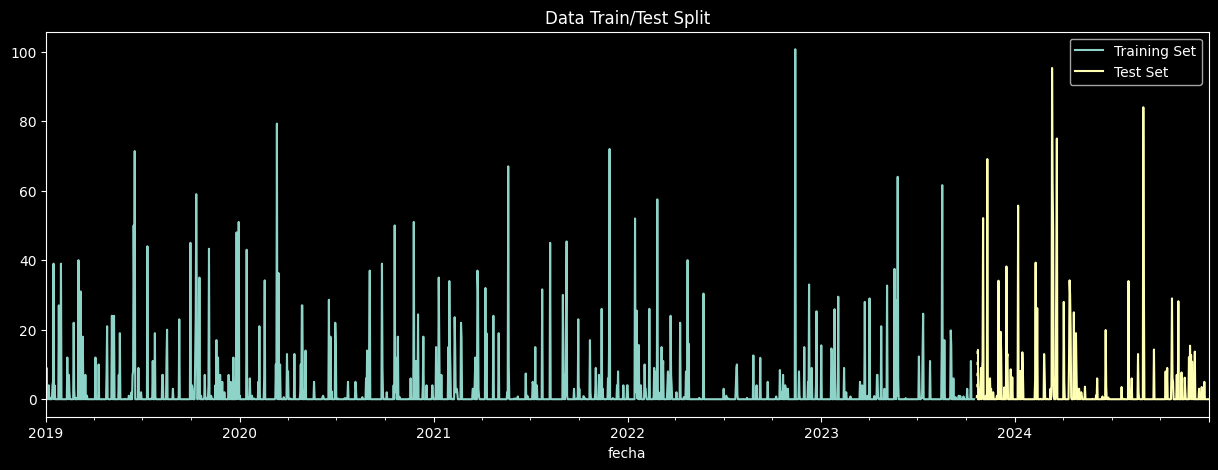

In [ ]:
split_index = int(len(df_precipitaciones) * 0.8)
train_precipitaciones = df_precipitaciones.iloc[:split_index]
test_precipitaciones = df_precipitaciones.iloc[split_index:]

fig, ax = plt.subplots(figsize=(15, 5))
train_precipitaciones.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_precipitaciones.plot(ax=ax, label='Test Set')
ax.axvline(test_precipitaciones.index[0], color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
tss_precipitaciones = TimeSeriesSplit(n_splits=5, test_size=1*200*1, gap=1) #se están dejando 24 hrs como brecha entre el conjunto de entrenamiento y el conjunto de prueba. (mayor representatividad)
df_precipitaciones_cv = df_precipitaciones.sort_index()

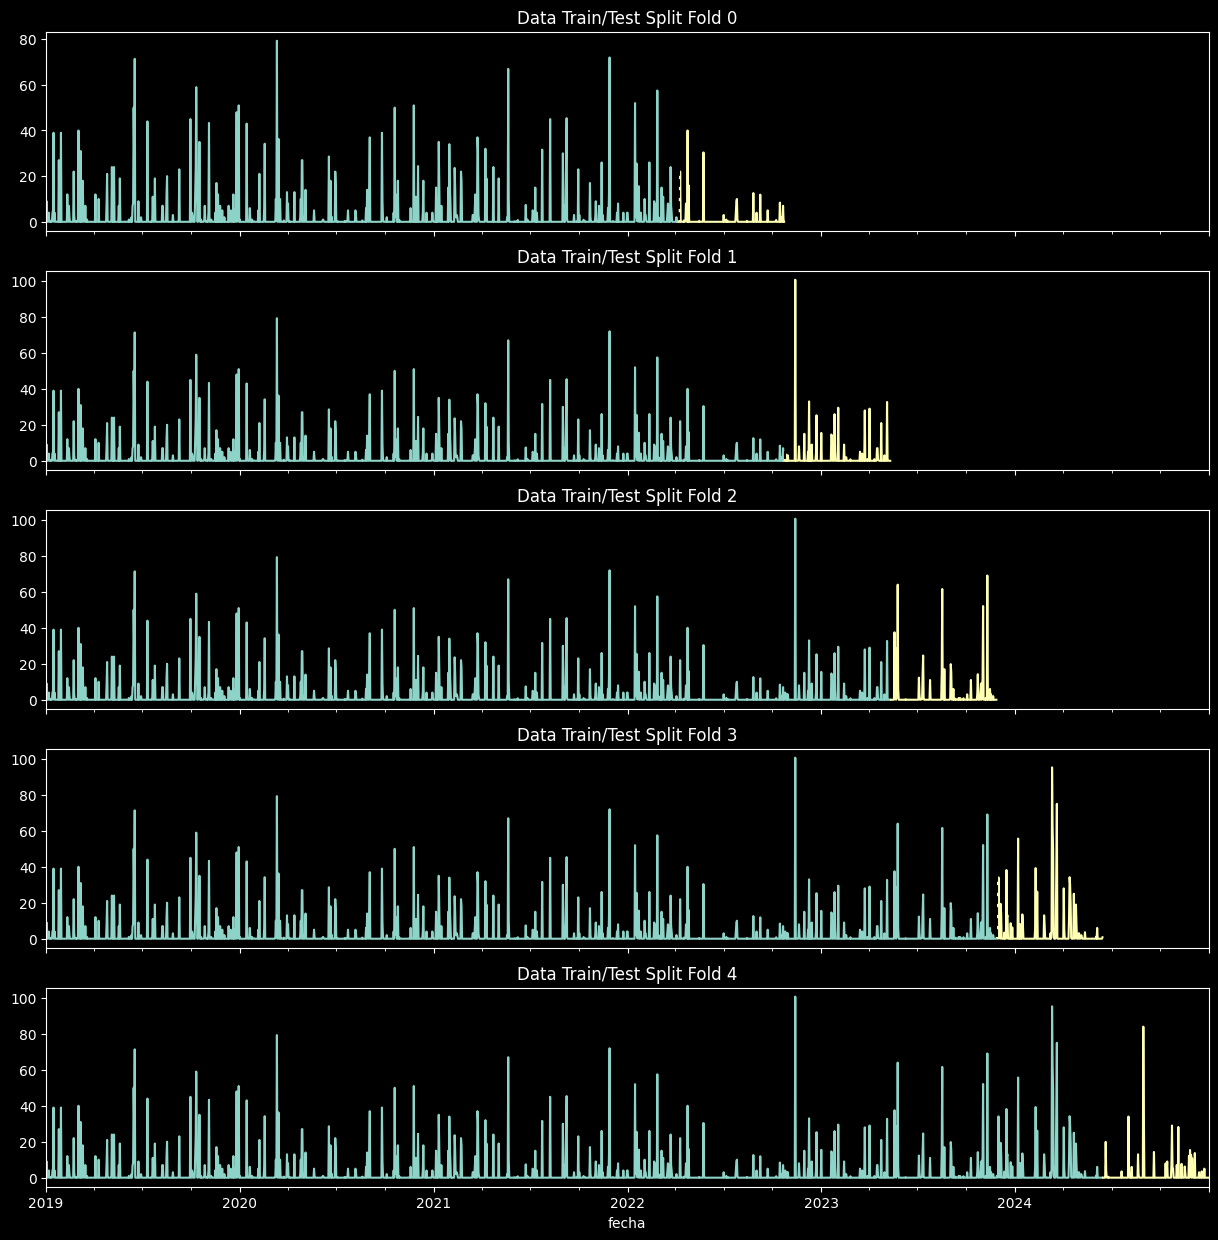

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss_precipitaciones.split(df_precipitaciones_cv):
    train = df_precipitaciones_cv.iloc[train_idx]
    val = df_precipitaciones_cv.iloc[val_idx]
    train['(mm)'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    val['(mm)'].plot(ax=axs[fold],label='Val Set')
    axs[fold].axvline(val.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [ ]:
for i, (train_index, test_index) in enumerate(tss_precipitaciones.split(df_precipitaciones_cv)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[   0    1    2 ... 1188 1189 1190]
  Test:  index=[1192 1193 1194 1195 1196 1197 1198 1199 1200 1201 1202 1203 1204 1205
 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219
 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233
 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247
 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261
 1262 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275
 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289
 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 1301 1302 1303
 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317
 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331
 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345
 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359
 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373
 13

In [ ]:
def create_features(df):
    """
    Creamos features basadas en el índice tiempo.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [ ]:
df_precipitaciones_cv = create_features(df_precipitaciones_cv)

In [ ]:
def add_lags(df):
    target_map = df['(mm)'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df_precipitaciones_cv = add_lags(df_precipitaciones_cv)

In [ ]:
tss_precipitaciones_2 = TimeSeriesSplit(n_splits=5, test_size=200, gap=1)
df_precipitaciones_cv = df_precipitaciones_cv.sort_index()

In [ ]:
fold = 0
preds = [] #Almacena las predicciones de cada partición
scores = [] #Guarda el RMSE de cada partición
for train_idx, val_idx in tss_precipitaciones_2.split(df_precipitaciones_cv): #Iterar sobre las particiones
    train = df_precipitaciones_cv.iloc[train_idx]
    val = df_precipitaciones_cv.iloc[val_idx]

    #train = create_features(train)
    #val = create_features(val)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] #Extraer características y target
    TARGET = '(mm)'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_val = val[FEATURES]
    y_val = val[TARGET]

    reg = xgb.XGBRegressor(booster='gbtree', #utilizar modelado basado en árboles
                           n_estimators=1000, #n_estimators – Número de árboles que llevan a cabo el boosting. También se entiende como el número de iteraciones de boosting.
                           objective='reg:linear', #Aquí es donde se indica si queremos hacer regresión
                           max_depth=3, #Máxima profundidad de un arbol.
                           learning_rate=0.01,
                           eval_metric=['rmse', 'mae'] )
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100)

    y_pred = reg.predict(X_val)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    scores.append(score)

[0]	validation_0-rmse:8.82647	validation_0-mae:4.55858	validation_1-rmse:4.71107	validation_1-mae:3.27813
[100]	validation_0-rmse:8.61192	validation_0-mae:4.41570	validation_1-rmse:4.62776	validation_1-mae:3.04066
[200]	validation_0-rmse:8.47915	validation_0-mae:4.32545	validation_1-rmse:4.59596	validation_1-mae:2.90265
[300]	validation_0-rmse:8.33504	validation_0-mae:4.25532	validation_1-rmse:4.56993	validation_1-mae:2.78418
[400]	validation_0-rmse:8.21967	validation_0-mae:4.19619	validation_1-rmse:4.58276	validation_1-mae:2.75091
[500]	validation_0-rmse:8.11238	validation_0-mae:4.14327	validation_1-rmse:4.59951	validation_1-mae:2.71881
[600]	validation_0-rmse:8.00633	validation_0-mae:4.09057	validation_1-rmse:4.60590	validation_1-mae:2.66740
[700]	validation_0-rmse:7.91173	validation_0-mae:4.04146	validation_1-rmse:4.60022	validation_1-mae:2.64223
[800]	validation_0-rmse:7.83580	validation_0-mae:4.00000	validation_1-rmse:4.60740	validation_1-mae:2.63663
[900]	validation_0-rmse:7.7506

In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 9.1265
Fold scores:[np.float64(4.63796172067648), np.float64(9.456528725119927), np.float64(9.876703413629738), np.float64(13.266158043035208), np.float64(8.394914531847022)]


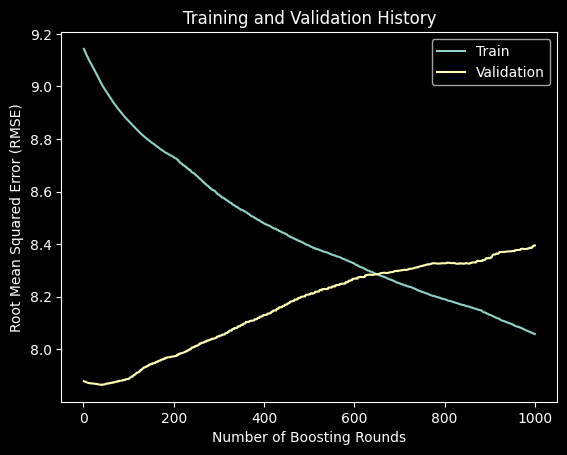

In [ ]:
# Plot the training and validation history
results = reg.evals_result()
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History')
plt.legend()
plt.show()

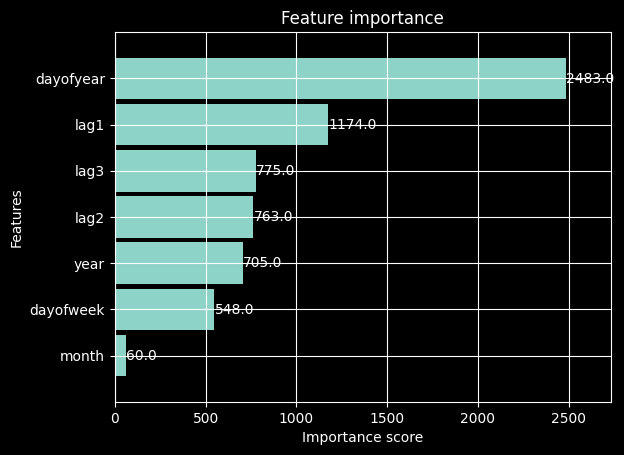

In [ ]:
_ = plot_importance(reg, height=0.9)

In [ ]:
y_pred = reg.predict(X_val)

In [ ]:
val['prediction'] = reg.predict(X_val)

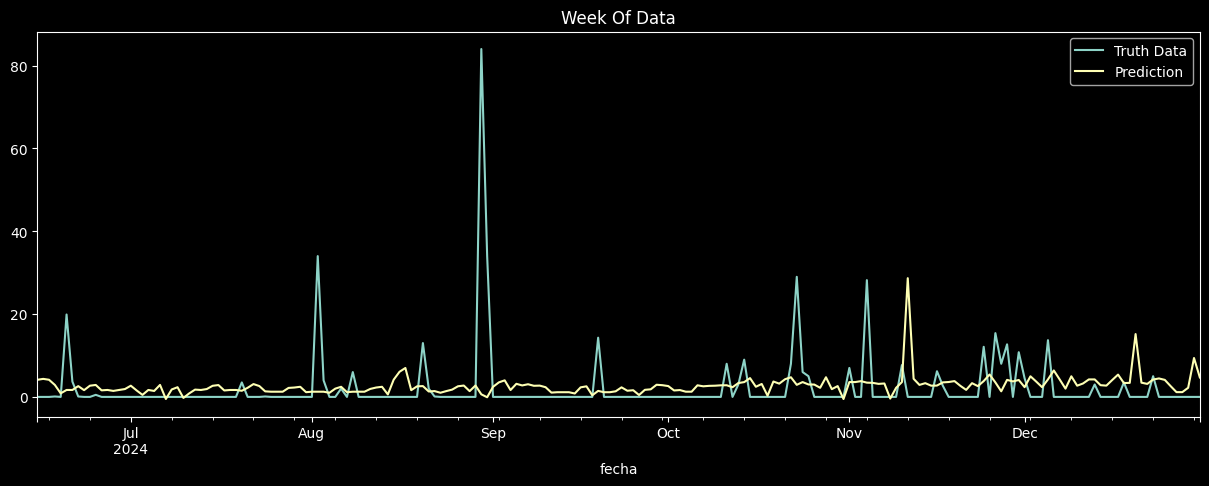

In [ ]:
ax = val.loc[(val.index >= '2017-08-03')]['(mm)'].plot(figsize=(15, 5), title='Week Of Data')
val.loc[(val.index >= '2017-08-03')]['prediction'].plot()
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Calculate error metrics using the filtered data
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
score = np.sqrt(mean_squared_error(y_val, y_pred))

In [ ]:
# Print the error metrics
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print(f'RMSE Score on Test set: {score:0.2f}')

Mean Squared Error (MSE): 70.47458999701631
Mean Absolute Error (MAE): 3.9788794875442983
RMSE Score on Test set: 8.39


[I 2025-10-19 00:21:25,794] A new study created in memory with name: no-name-e70a7216-8653-4506-8068-22901c2dc0b4
[I 2025-10-19 00:21:26,320] Trial 0 finished with value: 10.039605119576336 and parameters: {'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.06528295295512959, 'subsample': 0.8367198215069396, 'colsample_bytree': 0.7733138316980934, 'reg_alpha': 7.520689661602466e-06, 'reg_lambda': 1.584685469367077e-05}. Best is trial 0 with value: 10.039605119576336.
[I 2025-10-19 00:21:29,603] Trial 1 finished with value: 12.440436116007048 and parameters: {'n_estimators': 842, 'max_depth': 6, 'learning_rate': 0.04972275905688496, 'subsample': 0.8851354996883101, 'colsample_bytree': 0.6329561113581188, 'reg_alpha': 0.004002653100236657, 'reg_lambda': 5.98547197662352e-08}. Best is trial 0 with value: 10.039605119576336.
[I 2025-10-19 00:21:32,323] Trial 2 finished with value: 10.477783412082015 and parameters: {'n_estimators': 198, 'max_depth': 8, 'learning_rate': 0.0964440489838

Best hyperparameters:  {'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.06528295295512959, 'subsample': 0.8367198215069396, 'colsample_bytree': 0.7733138316980934, 'reg_alpha': 7.520689661602466e-06, 'reg_lambda': 1.584685469367077e-05}
Best RMSE:  10.039605119576336


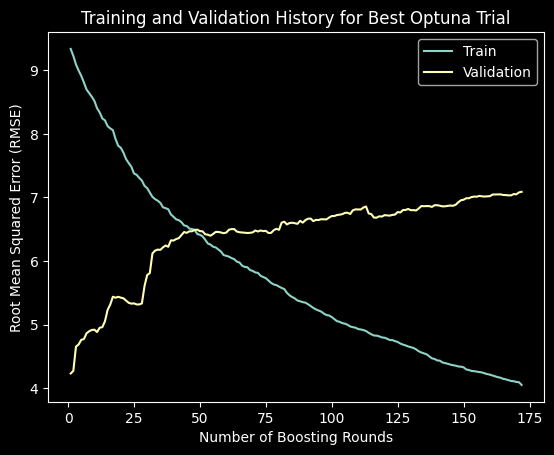

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    tss = TimeSeriesSplit(n_splits=5, test_size=50, gap=1)
    rmse_scores = []

    df_processed = create_features(df_precipitaciones_cv.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags


    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3'] # Update feature names
    TARGET = '(mm)'

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

In [ ]:
# Define features and target
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
            'lag1','lag2','lag3']
TARGET = '(mm)'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_precipitaciones_cv.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-07-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7733138316980934, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06528295295512959,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=172, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 11.35
Final Model MAE on Test Set: 4.73


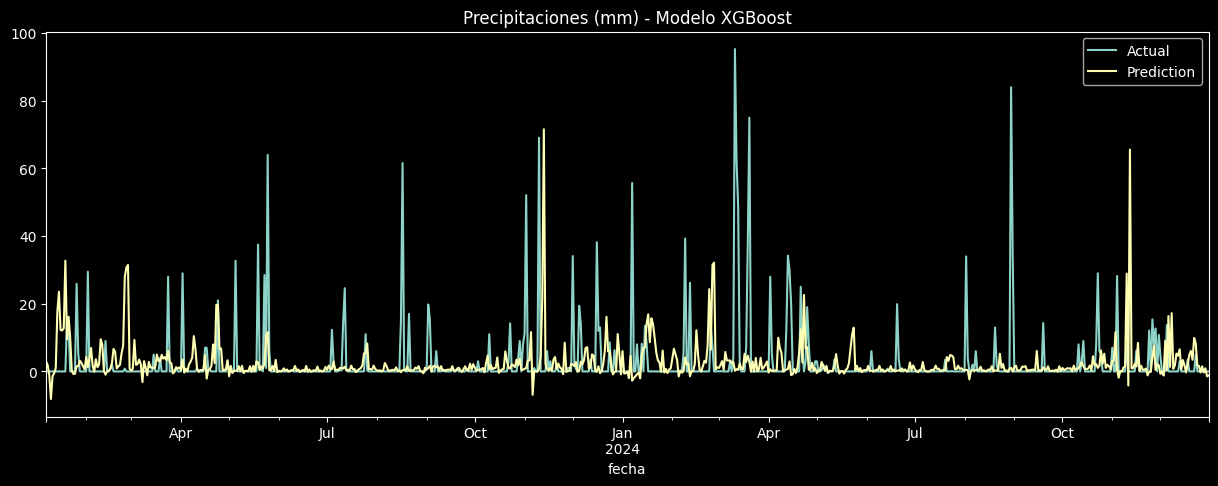

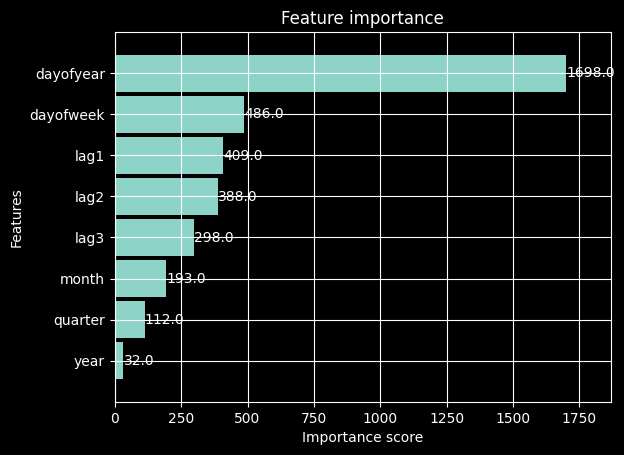

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Precipitaciones (mm) - Modelo XGBoost')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [ ]:
import timesfm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
contexto = 2000

model.compile(
    timesfm.ForecastConfig(
        max_context=contexto,      #<----esto se puede modificar
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=True, # Importante para siniestros, que no pueden ser negativos
        fix_quantile_crossing=True,
    )
)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# 3. Preparación de tus datos
HORIZON = 30 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_precipitaciones_TFM = df_precipitaciones.copy()
split_index = int(len(data_precipitaciones_TFM) * 0.8)
train_precipitaciones_TFM = data_precipitaciones_TFM[:split_index]
test_precipitaciones_TFM = data_precipitaciones_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_precipitaciones_TFM['(mm)'][(contexto *-1):].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1753)


In [ ]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_precipitaciones = point_forecast[0]

print(f"Se generaron {len(prediccion_precipitaciones)} predicciones para los próximos {HORIZON} días.")

Se generaron 30 predicciones para los próximos 30 días.


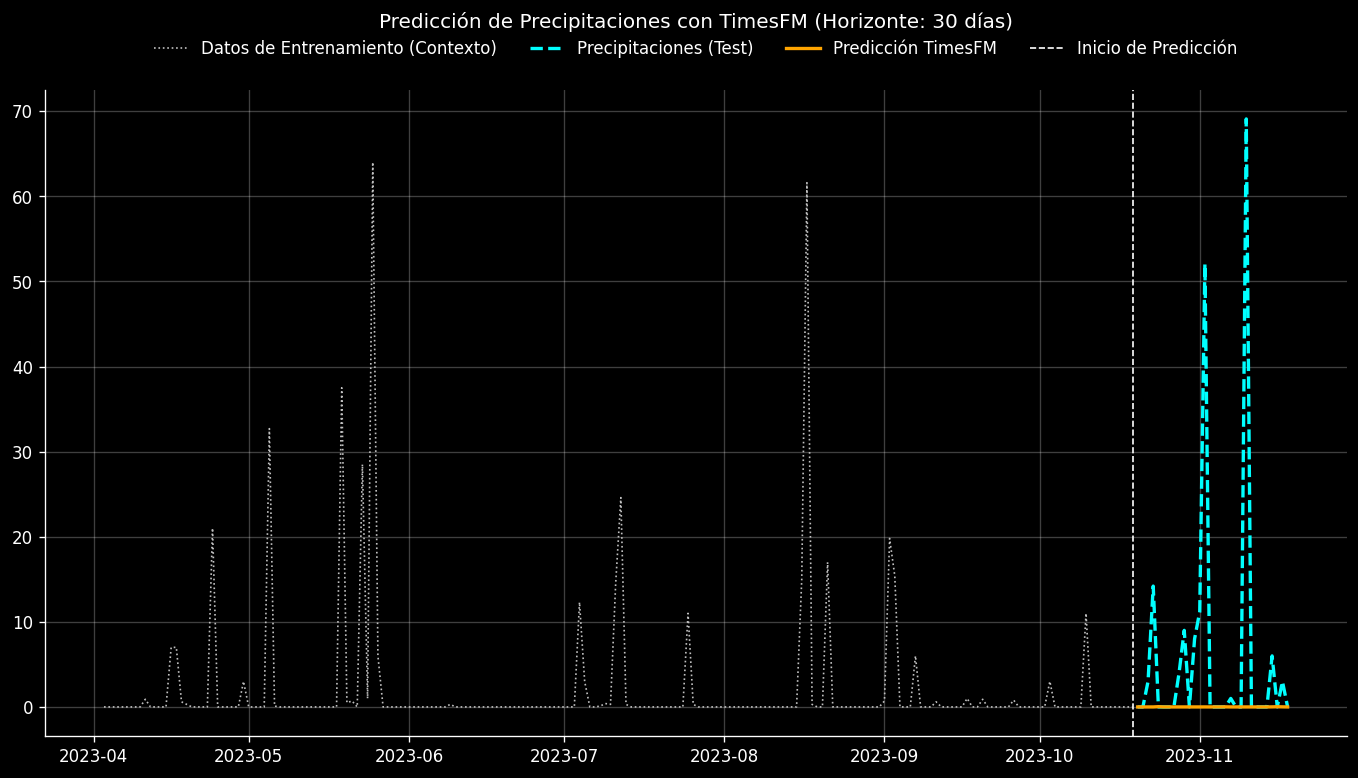

In [ ]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_precipitaciones_TFM['(mm)'].iloc[:HORIZON].values,
    'Predichos': prediccion_precipitaciones
}, index=test_precipitaciones_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_precipitaciones_TFM.index[-200:], train_precipitaciones_TFM['(mm)'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Precipitaciones (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_precipitaciones_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Precipitaciones con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

## Times_FM2

Forma de los datos de entrada de Temperatura: (4, 1095)


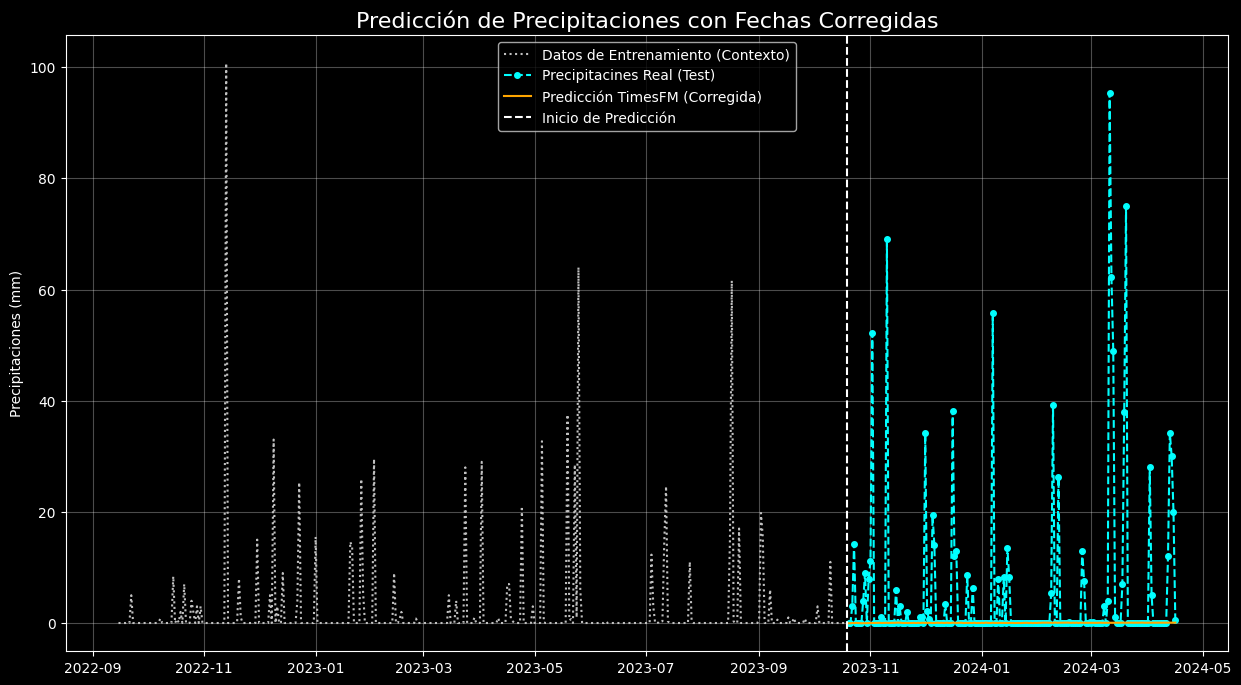

In [ ]:
from sklearn.preprocessing import StandardScaler

# --- 1. FEATURE ENGINEERING (Esto ya estaba correcto) ---
df_precipitaciones_featured = df_precipitaciones.copy()
day_of_year = df_precipitaciones_featured.index.dayofyear
df_precipitaciones_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_precipitaciones_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
df_precipitaciones_featured['dayofweek'] = df_precipitaciones_featured.index.dayofweek

TARGET_COLUMN_TEMP = '(mm)'
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']
HORIZON_TEMP = 180 # Set the prediction horizon to 180 days
CONTEXT_WINDOW_TEMP = 1095

# --- 2. DIVISIÓN Y ESCALADO CORRECTOS (¡AQUÍ ESTÁ EL CAMBIO!) ---

# **PASO 2.1: PRIMERO, dividimos los datos**
split_index_temp = int(len(df_precipitaciones_featured) * 0.8)
train_data_temp = df_precipitaciones_featured[:split_index_temp].copy() # Usamos .copy() para evitar warnings
test_data_temp = df_precipitaciones_featured[split_index_temp:].copy()

# **PASO 2.2: LUEGO, creamos y AJUSTAMOS el escalador SOLO CON DATOS DE ENTRENAMIENTO**
scaler_temp = StandardScaler()
scaler_temp.fit(train_data_temp[FEATURES_TEMP])

# **PASO 2.3: AHORA, transformamos ambos conjuntos de datos por separado**
train_data_temp[FEATURES_TEMP] = scaler_temp.transform(train_data_temp[FEATURES_TEMP])
test_data_temp[FEATURES_TEMP] = scaler_temp.transform(test_data_temp[FEATURES_TEMP])

# --- 3. PREPARACIÓN DEL INPUT (Sin cambios, pero ahora usa datos bien escalados) ---
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN (Sin cambios) ---
model.compile(
    timesfm.ForecastConfig(
        max_context=1024, max_horizon=512, normalize_inputs=True,
        use_continuous_quantile_head=True, force_flip_invariance=True,
        infer_is_positive=False, fix_quantile_crossing=True,
    )
)
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP, inputs=model_inputs_temp # Use HORIZON_TEMP for the prediction horizon
)

# --- CORRECCIÓN CLAVE: Construcción robusta del DataFrame de resultados ---

# 1. Obtenemos el índice de fechas exacto para el período de la predicción.
prediction_index = test_data_temp.index[:HORIZON_TEMP]

# 2. Get the unscaled predicted values
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
predicted_scaled[:, 0] = point_forecast_temp[0]
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)
predicted_values_temp = predicted_unscaled[:, 0]

# 3. Obtenemos los valores reales correspondientes a ESE índice desde el DataFrame ORIGINAL (no escalado).
real_values = df_precipitaciones.loc[prediction_index, TARGET_COLUMN_TEMP]

# 4. Creamos el DataFrame de resultados asegurando que todo esté alineado.
df_results_temp = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values_temp
}, index=prediction_index)


# --- Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original para claridad
ax.plot(df_precipitaciones[TARGET_COLUMN_TEMP].loc[train_data_temp.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción - tomados del nuevo df_results_temp
ax.plot(df_results_temp.index, df_results_temp['Reales'], label='Precipitacines Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp.index, df_results_temp['Predichos'], label='Predicción TimesFM (Corregida)', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.set_title('Predicción de Precipitaciones con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Precipitaciones (mm)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

## Chronos

In [ ]:
df_modelo_precipitaciones_chronos = df_precipitaciones.copy()
## Parametros de prediccion
step_to_predict= 20  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 5 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [ ]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_modelo_precipitaciones_chronos["(mm)"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_modelo_precipitaciones_chronos), len(df_modelo_precipitaciones_chronos) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

In [ ]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.8020e+00, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 6.0084e+00, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08],
        [4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
         4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08, 4.5075e-08,
       

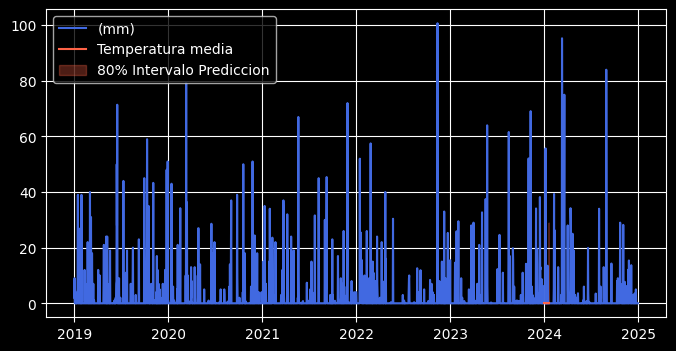

In [ ]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_modelo_precipitaciones_chronos["(mm)"], color="royalblue", label="(mm)")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Temperatura media")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [ ]:
n_test = 20
df_precipitacines_chronos_train = df_modelo_precipitaciones_chronos[:-n_test]
df_precipitaciones_chronos_test = df_modelo_precipitaciones_chronos[-n_test:]

In [ ]:
fechas_train = df_precipitacines_chronos_train.index
fechas_test = df_precipitaciones_chronos_test.index

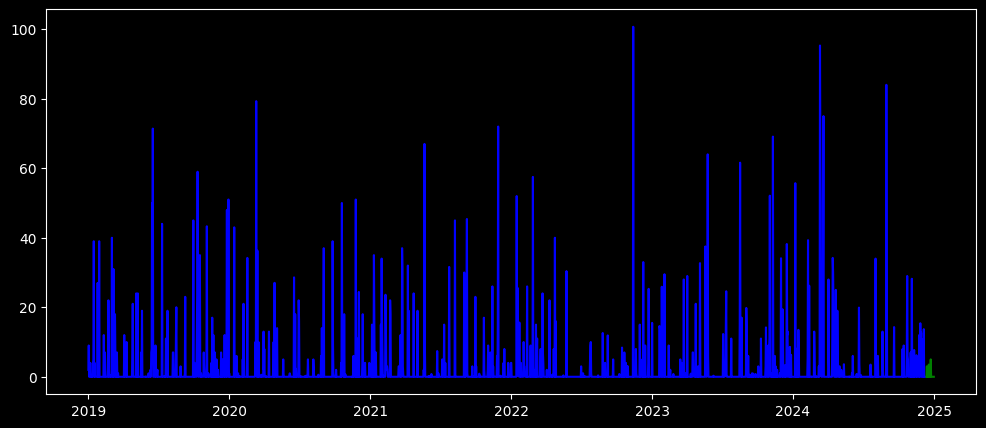

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_precipitacines_chronos_train["(mm)"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_precipitaciones_chronos_test["(mm)"], label="Test real", color="green")

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [ ]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_siniestros_chronos_train["cantidad_eventos"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [ ]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

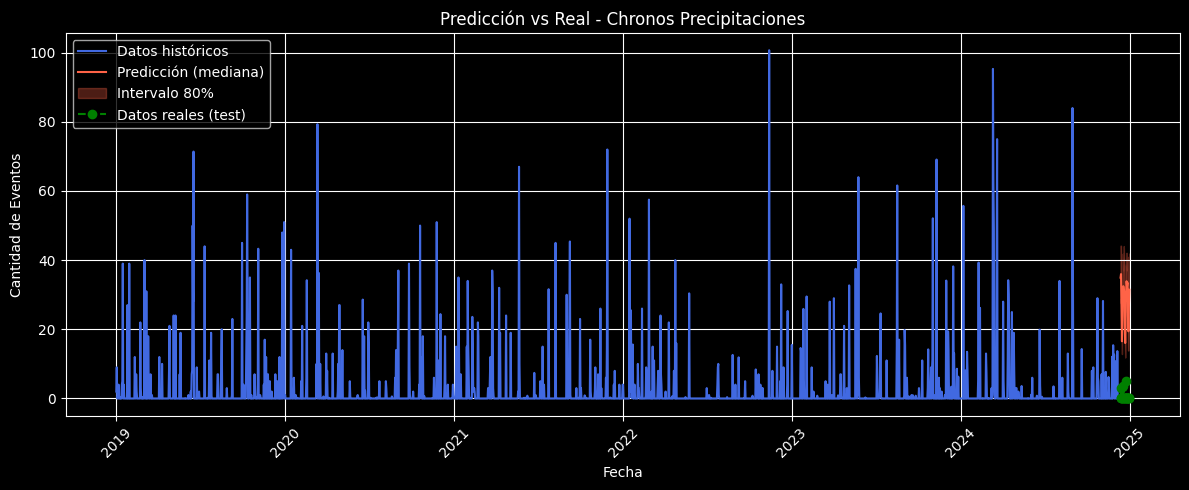

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_precipitaciones_chronos_test["(mm)"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_precipitacines_chronos_train["(mm)"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Precipitaciones")
plt.xlabel("Fecha")
plt.ylabel("Cantidad de Eventos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 28.28
Chronos Model MAE on Test Set: 27.70


## AutoML

In [ ]:
import time # Import the time module
# AUTOTS APLICADO A PRECIPITACIONES

print("\n--- Iniciando análisis de Precipitaciones con AutoTS (Versión Rápida) ---")

# Usamos una copia para asegurar que el DataFrame original no se modifica
df_target = df_precipitaciones.copy()
target_col = '(mm)'  # <-- CAMBIO: Columna objetivo para precipitaciones

# Convertir el índice 'fecha' en una columna
df_target.reset_index(inplace=True)

# División 80/20 para entrenamiento y prueba
split_point = math.trunc(len(df_target) * 0.8)
train_data = df_target.iloc[:split_point]
test_data = df_target.iloc[split_point:]
print(f"Tamaño de entrenamiento: {len(train_data)}, Tamaño de prueba: {len(test_data)}")

model_precip_autots = AutoTS(
    forecast_length=len(test_data),
    frequency='D',
    prediction_interval=0.95,
    ensemble='simple',
    model_list='fast',
    max_generations=3,
    num_validations=1,
    no_negatives=True,
    n_jobs='auto'
)

print("\nEntrenando modelo AutoTS (configuración rápida)...")
start_time = time.time() # Start the timer
model_precip_autots.fit(train_data, date_col='fecha', value_col=target_col)
end_time = time.time() # Stop the timer
print(f"Tiempo de entrenamiento del modelo AutoTS: {end_time - start_time:.2f} segundos") # Print the elapsed time

# Predicción
prediction = model_precip_autots.predict()
forecast = prediction.forecast

# Preparar el DataFrame de test para graficar
test_data.set_index('fecha', inplace=True)

# Evaluación y almacenamiento de métricas
print("\n--- Resumen del Modelo Seleccionado ---")
print(model_precip_autots)
mae = mean_absolute_error(test_data[target_col], forecast[target_col])
rmse = np.sqrt(mean_squared_error(test_data[target_col], forecast[target_col]))
autots_results_summary['Precipitaciones'] = {'MAE': mae, 'RMSE': rmse}
print(f"\n--- Métricas en Test --- \nMAE: {mae:.4f} \nRMSE: {rmse:.4f}")


--- Iniciando análisis de Precipitaciones con AutoTS (Versión Rápida) ---
Tamaño de entrenamiento: 1753, Tamaño de prueba: 439
Using 1 cpus for n_jobs.

Entrenando modelo AutoTS (configuración rápida)...
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 3
Model Number: 2 with model AverageValueNaive in generation 0 of 3
Model Number: 3 with model AverageValueNaive in generation 0 of 3
Model Number: 4 with model DatepartRegression in generation 0 of 3
Model Number: 5 with model DatepartRegression in generation 0 of 3
Model Number: 6 with model DatepartRegression in generation 0 of 3
Model Number: 7 with model DatepartRegression in generation 0 of 3
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4277
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4262
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4248
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4253
Epoch 5/50
42/42 ━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 58 with model ETS in generation 0 of 3
Model Number: 59 with model VAR in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VAR') in model 59 in generation 0: VAR
Model Number: 60 with model VECM in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VECM') in model 60 in generation 0: VECM
Model Number: 61 with model WindowRegression in generation 0 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 61 in generation 0: WindowRegression
Model Number: 62 with model DatepartRegression in generation 0 of 3
Model Number: 63 with model UnivariateMotif in generation 0 of 3
Model Number: 64 with model SectionalMotif in generation 0 of 3
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 64 in generation 0: SectionalMotif
Model Number: 65 with model NVAR in generation 0 of 3
Model Number: 66 with model MAR in generation 0 of 3
T

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 164 with model LastValueNaive in generation 0 of 3
Model Number: 165 with model FFT in generation 0 of 3
Model Number: 166 with model DatepartRegression in generation 0 of 3
New Generation: 1 of 3
Model Number: 167 with model MetricMotif in generation 1 of 3
Model Number: 168 with model LastValueNaive in generation 1 of 3
Model Number: 169 with model UnivariateMotif in generation 1 of 3
Model Number: 170 with model DatepartRegression in generation 1 of 3
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: nan
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 9/50
19/19 ━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 204 in generation 1: GLM
Model Number: 205 with model BasicLinearModel in generation 1 of 3
Model Number: 206 with model WindowRegression in generation 1 of 3
Model Number: 207 with model SeasonalNaive in generation 1 of 3
Model Number: 208 with model RRVAR in generation 1 of 3
Model Number: 209 with model SectionalMotif in generation 1 of 3
Model Number: 210 with model FFT in generation 1 of 3
Model Number: 211 with model SeasonalityMotif in generation 1 of 3
Model Number: 212 with model LastValueNaive in generation 1 of 3
Model Number: 213 with model GLM in generation 1 of 3
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 213 in generation 1: GLM
Model Number: 214 with model Cassandra in generation 1 of 3
Model Number: 215 with model AverageValueNaive in generation 1 of 3
Model Number: 216 with model BasicL

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 256 with model LastValueNaive in generation 1 of 3
Model Number: 257 with model SeasonalNaive in generation 1 of 3
Model Number: 258 with model Cassandra in generation 1 of 3
Model Number: 259 with model LastValueNaive in generation 1 of 3
Model Number: 260 with model MetricMotif in generation 1 of 3
Model Number: 261 with model AverageValueNaive in generation 1 of 3
Model Number: 262 with model MAR in generation 1 of 3
Model Number: 263 with model DatepartRegression in generation 1 of 3
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: nan
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: nan
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: nan
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step -

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 270 with model AverageValueNaive in generation 1 of 3
Model Number: 271 with model BallTreeMultivariateMotif in generation 1 of 3
Model Number: 272 with model GLM in generation 1 of 3
Model Number: 273 with model BallTreeMultivariateMotif in generation 1 of 3
Model Number: 274 with model SeasonalNaive in generation 1 of 3
Model Number: 275 with model NVAR in generation 1 of 3
Model Number: 276 with model ETS in generation 1 of 3
Model Number: 277 with model DatepartRegression in generation 1 of 3
Template Eval Error: IndexError('tuple index out of range') in model 277 in generation 1: DatepartRegression
Model Number: 278 with model ETS in generation 1 of 3
Template Eval Error: Exception("Transformer Cointegration failed on fit from params ffill {'0': {'det_order': 0, 'k_ar_diff': 0}, '1': {}, '2': {}, '3': {}, '4': {'method': 'savgol_filter', 'method_args': {'window_length': 31, 'polyorder': 1, 'deriv': 0, 'mode': 'mirror'}}, '5': {'decimals': 0, 'on_transform': False, 'o

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 343 with model Cassandra in generation 2 of 3
Model Number: 344 with model GLM in generation 2 of 3
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 344 in generation 2: GLM
Model Number: 345 with model DatepartRegression in generation 2 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 345 in generation 2: DatepartRegression
Model Number: 346 with model BallTreeMultivariateMotif in generation 2 of 3
Model Number: 347 with model SeasonalNaive in generation 2 of 3
Model Number: 348 with model FFT in generation 2 of 3
Model Number: 349 with model FFT in generation 2 of 3
Model Number: 350 with model UnivariateMotif in generation 2 of 3
Model Number: 351 with model AverageValueNaive in generation 2 of 3
Model Number: 352 with model DatepartRegression in generation 2 of 3
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 10.4564
Epoch 2/50
42/42 ━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 361 with model AverageValueNaive in generation 2 of 3
Model Number: 362 with model BallTreeMultivariateMotif in generation 2 of 3
Model Number: 363 with model ETS in generation 2 of 3
Model Number: 364 with model DatepartRegression in generation 2 of 3
Template Eval Error: Exception("Transformer BTCD failed on fit from params linear {'0': {'window_size': 90, 'alpha': 2.5, 'grouping_forward_limit': 2, 'max_level_shifts': 5, 'alignment': 'rolling_diff'}, '1': {}, '2': {'regression_model': {'model': 'LinearRegression', 'model_params': {}}, 'max_lags': 2}, '3': {'method': 'IQR', 'method_params': {'iqr_threshold': 2.5, 'iqr_quantiles': [0.25, 0.75]}, 'fillna': None, 'transform_dict': {'fillna': 'akima', 'transformations': {'0': 'AnomalyRemoval', '1': 'Detrend'}, 'transformation_params': {'0': {'method': 'minmax', 'method_params': {'alpha': 0.03}, 'fillna': 'ffill', 'transform_dict': {'fillna': 'fake_date', 'transformations': {'0': 'IntermittentOccurrence', '1': 'AnomalyRemoval

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 421 with model SectionalMotif in generation 3 of 3
Template Eval Error: Exception('Transformer MinMaxScaler failed on inverse from params rolling_mean_24 {\'0\': {}, \'1\': {\'constant\': 0, \'reintroduction_model\': {\'model\': \'KNN\', \'model_params\': {\'n_neighbors\': 5, \'weights\': \'uniform\', \'p\': 1, \'leaf_size\': 10}, \'datepart_method\': [\'simple_binarized\']}, \'fillna\': None}, \'2\': {}, \'3\': {}} with ValueError("Input contains infinity or a value too large for dtype(\'float64\').")') in model 421 in generation 3: SectionalMotif
Model Number: 422 with model SectionalMotif in generation 3 of 3
Model Number: 423 with model GLS in generation 3 of 3
Model Number: 424 with model DatepartRegression in generation 3 of 3
Model Number: 425 with model GLM in generation 3 of 3
Model Number: 426 with model BallTreeMultivariateMotif in generation 3 of 3
Model Number: 427 with model BasicLinearModel in generation 3 of 3
Model Number: 428 with model SeasonalityMotif 

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


32 - GLM with avg smape nan: 
Model Number: 33 of 77 with model SeasonalityMotif for Validation 1
33 - SeasonalityMotif with avg smape nan: 
Model Number: 34 of 77 with model FFT for Validation 1
34 - FFT with avg smape nan: 
Model Number: 35 of 77 with model FFT for Validation 1
35 - FFT with avg smape nan: 
Model Number: 36 of 77 with model RRVAR for Validation 1
36 - RRVAR with avg smape 184.72: 
Model Number: 37 of 77 with model DatepartRegression for Validation 1
37 - DatepartRegression with avg smape nan: 
Model Number: 38 of 77 with model DatepartRegression for Validation 1
38 - DatepartRegression with avg smape nan: 
Model Number: 39 of 77 with model BasicLinearModel for Validation 1
39 - BasicLinearModel with avg smape nan: 
Model Number: 40 of 77 with model GLM for Validation 1
40 - GLM with avg smape nan: 
Model Number: 41 of 77 with model GLM for Validation 1
41 - GLM with avg smape nan: 
Model Number: 42 of 77 with model SeasonalityMotif for Validation 1
42 - SeasonalityMo

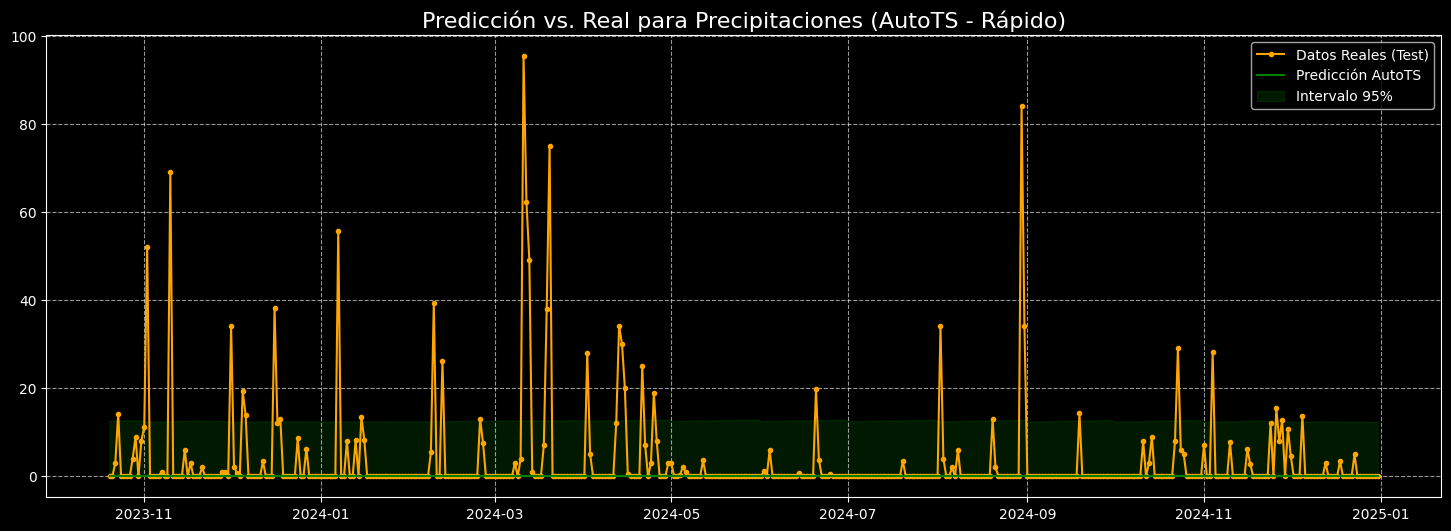

In [ ]:
# Visualización
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(test_data.index, test_data[target_col], label='Datos Reales (Test)', color='orange', marker='o', markersize=3)
ax.plot(forecast.index, forecast[target_col], label='Predicción AutoTS', color='green')

lower_forecast = prediction.lower_forecast
upper_forecast = prediction.upper_forecast
ax.fill_between(forecast.index, lower_forecast[target_col], upper_forecast[target_col], color='green', alpha=0.2, label='Intervalo 95%')

ax.set_title('Predicción vs. Real para Precipitaciones (AutoTS - Rápido)', fontsize=16)
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Temperatura

In [ ]:
df_temperatura.rename(columns={'Unnamed: 0': 'fecha', '(°C)': 'Maxima', 'Unnamed: 2': 'Minima'}, inplace=True)
df_temperatura.head()

fecha Maxima Minima
0 2019-01-01   32.7   23.4
1 2019-01-02   32.1   23.7
2 2019-01-03   26.3     17
3 2019-01-04   28.9     18
4 2019-01-05   30.1   21.2

In [ ]:
mask = (df_temperatura['Maxima'].isin(['\\N', 'N'])) | (df_temperatura['Minima'].isin(['\\N', 'N']))

In [ ]:
# 1. Reemplazar '\\N' (y posiblemente 'N') por NaN
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].replace({'\\N': np.nan, 'N': np.nan})

# 2. Convertir a float
df_temperatura[['Maxima', 'Minima']] = df_temperatura[['Maxima', 'Minima']].astype(float)

# 3. Verificar los tipos
print(df_temperatura.dtypes)
print(df_temperatura.isna().sum())
df_temperatura.dropna(inplace=True)
print(df_temperatura.isna().sum())
print(df_temperatura.dtypes)


fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object
fecha     0
Maxima    1
Minima    1
dtype: int64
fecha     0
Maxima    0
Minima    0
dtype: int64
fecha     datetime64[ns]
Maxima           float64
Minima           float64
dtype: object


In [ ]:
df_temperatura['Media']= (df_temperatura['Maxima'] + df_temperatura['Minima']) / 2

In [ ]:
df_temperatura.set_index('fecha', inplace=True)

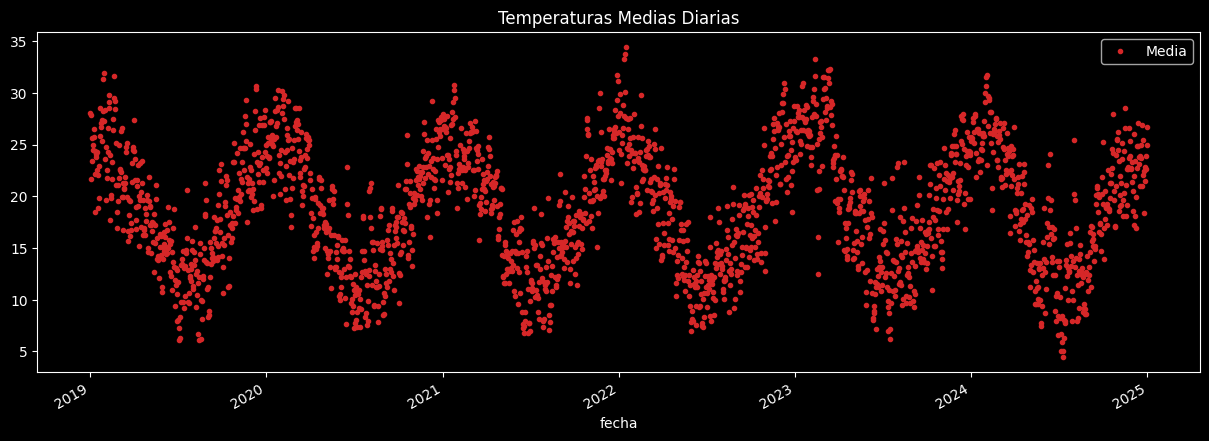

In [ ]:
# Seleccionar la temperatura media como nuestro objetivo a predecir
df_modelo_temp = df_temperatura[['Media']].copy()

# Visualización de la nueva serie temporal de temperatura media
df_modelo_temp.plot(style='.',
                    figsize=(15, 5),
                    color=color_pal[3],
                    title='Temperaturas Medias Diarias')
plt.show()

In [ ]:
def create_features(df):
    """
    Crea características temporales a partir del índice de tipo datetime de un DataFrame.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df_modelo_temp = create_features(df_modelo_temp)

In [ ]:
# Usamos TimeSeriesSplit para la validación cruzada
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)

scores = []
fold = 0
for train_idx, val_idx in tss.split(df_modelo_temp):
    train = df_modelo_temp.iloc[train_idx]
    test = df_modelo_temp.iloc[val_idx]

    # ¡IMPORTANTE! Se define la variable 'Media' como objetivo
    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']
    TARGET = 'Media'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=False) # Se cambia a False para no imprimir el log de cada fold

    y_pred = reg.predict(X_test)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f'Fold {fold} RMSE: {score}')
    fold += 1

print(f'\nPromedio de RMSE en todos los folds: {np.mean(scores):.4f}')


Fold 0 RMSE: 3.29685867653691
Fold 1 RMSE: 3.1779646497276786
Fold 2 RMSE: 3.295461221320478
Fold 3 RMSE: 3.9115707870891017
Fold 4 RMSE: 3.4202078820940183

Promedio de RMSE en todos los folds: 3.4204


[0]	validation_0-rmse:18.79457	validation_1-rmse:19.41684
[100]	validation_0-rmse:7.49566	validation_1-rmse:8.24098
[200]	validation_0-rmse:3.89277	validation_1-rmse:4.78093
[300]	validation_0-rmse:3.04320	validation_1-rmse:3.93876
[400]	validation_0-rmse:2.86577	validation_1-rmse:3.76344
[500]	validation_0-rmse:2.80160	validation_1-rmse:3.73630
[528]	validation_0-rmse:2.78935	validation_1-rmse:3.73904


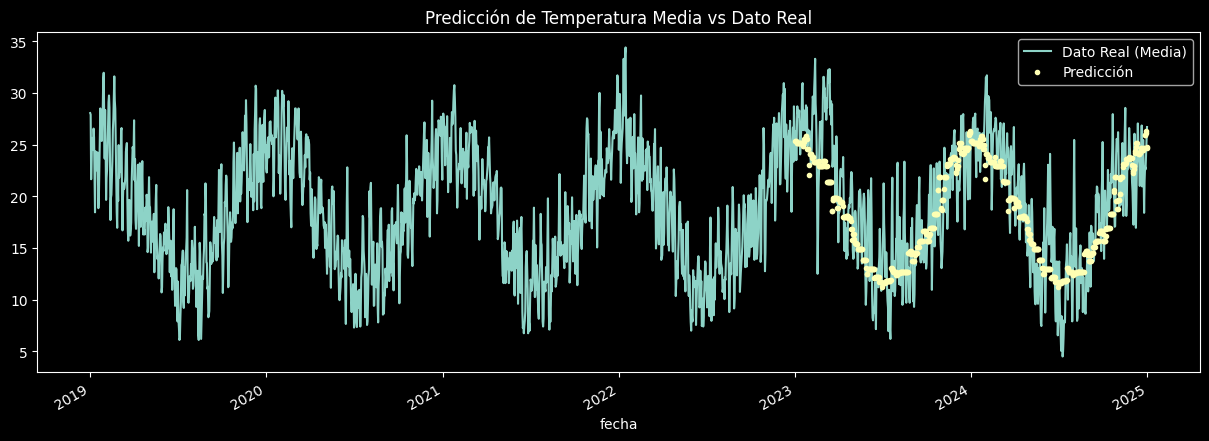

RMSE en el conjunto de prueba final: 3.7337


In [ ]:
# Dividimos en conjunto de entrenamiento y prueba para el modelo final
split_date = '01-Jan-2023'
train = df_modelo_temp.loc[df_modelo_temp.index <= split_date].copy()
test = df_modelo_temp.loc[df_modelo_temp.index > split_date].copy()

# Entrenamos el modelo final con todos los datos de entrenamiento
X_train_final = train[FEATURES]
y_train_final = train[TARGET]
X_test_final = test[FEATURES]
y_test_final = test[TARGET]

reg_final = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg_final.fit(X_train_final, y_train_final,
        eval_set=[(X_train_final, y_train_final), (X_test_final, y_test_final)],
        verbose=100)

# Realizamos la predicción en el conjunto de prueba
test['prediction'] = reg_final.predict(X_test_final)
df_final = df_modelo_temp.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Visualización de la predicción vs los datos reales
ax = df_final[['Media']].plot(figsize=(15, 5))
df_final['prediction'].plot(ax=ax, style='.')
plt.legend(['Dato Real (Media)', 'Predicción'])
ax.set_title('Predicción de Temperatura Media vs Dato Real')
plt.show()

# Calculamos el error final
score_final = np.sqrt(mean_squared_error(test['Media'], test['prediction']))
print(f'RMSE en el conjunto de prueba final: {score_final:.4f}')

[I 2025-10-19 00:39:27,772] A new study created in memory with name: no-name-54de3ba7-4304-4256-9ff4-d6291a5471cd
[I 2025-10-19 00:39:31,278] Trial 0 finished with value: 5.702933599081602 and parameters: {'n_estimators': 847, 'max_depth': 7, 'learning_rate': 0.07296929411381356, 'subsample': 0.7126032581466505, 'colsample_bytree': 0.7710334901140719, 'reg_alpha': 0.001360651099004662, 'reg_lambda': 1.6933920006881718e-08}. Best is trial 0 with value: 5.702933599081602.
[I 2025-10-19 00:39:34,116] Trial 1 finished with value: 5.783422999706888 and parameters: {'n_estimators': 647, 'max_depth': 7, 'learning_rate': 0.06082128491581863, 'subsample': 0.7498569550331712, 'colsample_bytree': 0.6591613746763406, 'reg_alpha': 0.00423991637642417, 'reg_lambda': 0.00047787262905856794}. Best is trial 0 with value: 5.702933599081602.
[I 2025-10-19 00:39:35,263] Trial 2 finished with value: 5.82739221432291 and parameters: {'n_estimators': 441, 'max_depth': 4, 'learning_rate': 0.08019526414410211,

Best hyperparameters:  {'n_estimators': 788, 'max_depth': 9, 'learning_rate': 0.0067651501833201, 'subsample': 0.605740171839369, 'colsample_bytree': 0.8934861175421619, 'reg_alpha': 0.46950287232368326, 'reg_lambda': 7.871806585414688e-07}
Best RMSE:  5.580837437172724


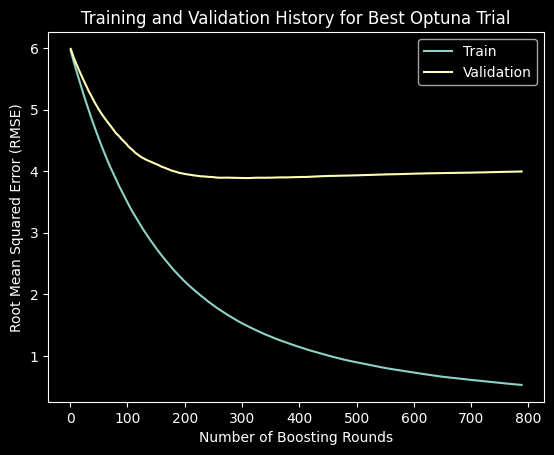

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt

# Modify the add_lags function to work with the 'Media' column
def add_lags(df):
    """
    Add lag features to the DataFrame based on the 'Media' column.
    """
    # Check if 'Media' column exists before proceeding
    if 'Media' not in df.columns:
        print("Error: 'Media' column not found in the DataFrame.")
        return df # Return the original DataFrame if the column is missing

    target_map = df['Media'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('730 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1095 days')).map(target_map)
    return df


def objective(trial):
    """Objective function for Optuna."""
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'random_state': 42,
        'n_jobs': -1
    }

    df_processed = create_features(df_modelo_temp.copy()) # Apply feature engineering
    df_processed = add_lags(df_processed) # Apply lag features
    df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

    # Calculate compatible test_size for TimeSeriesSplit
    n_samples = len(df_processed)
    n_splits = 5
    gap = 1
    # test_size = int((n_samples - gap) / (n_splits + 1)) -1 # This is one way to calculate test_size
    test_size = 218 # Adjusted test_size to be compatible with the number of samples

    tss = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap=gap)
    rmse_scores = []


    FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3'] # Include lag features
    TARGET = 'Media' # Set target to 'Media' for temperature data

    X = df_processed[FEATURES]
    y = df_processed[TARGET]

    models = []  # Store trained models to get eval_results later

    for train_idx, val_idx in tss.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        reg = xgb.XGBRegressor(**params)

        eval_set = [(X_train, y_train), (X_val, y_val)]

        reg.fit(X_train, y_train,
                eval_set=eval_set,
                verbose=False)

        models.append(reg)  # Store the trained model

        y_pred = reg.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmse_scores.append(rmse)

    # Store the evaluation results for the last fold of this trial
    trial.set_user_attr('eval_results', models[-1].evals_result())

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)

print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

# Plot the training and validation history for the best trial
best_trial = study.best_trial
results = best_trial.user_attrs['eval_results']
train_error = results['validation_0']['rmse']
val_error = results['validation_1']['rmse']

epoch = range(1, len(train_error) + 1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Training and Validation History for Best Optuna Trial')
plt.legend()
plt.show()

In [ ]:
# Define features and target
FEATURES = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
                'lag1','lag2','lag3']
TARGET = 'Media'

# Apply feature engineering and lag features to the full DataFrame
df_processed = create_features(df_modelo_temp.copy())
df_processed = add_lags(df_processed)
df_processed.dropna(inplace=True) # Drop rows with NaN values from lags

# Split data into training and testing sets using the original split point
train_cutoff = '01-01-2023'
X_train_final = df_processed.loc[df_processed.index < train_cutoff, FEATURES]
y_train_final = df_processed.loc[df_processed.index < train_cutoff, TARGET]
X_test_final = df_processed.loc[df_processed.index >= train_cutoff, FEATURES]
y_test_final = df_processed.loc[df_processed.index >= train_cutoff, TARGET]

# Initialize XGBoost model with best hyperparameters from Optuna
best_params = study.best_params
final_reg = xgb.XGBRegressor(**best_params,
                             objective='reg:squarederror',
                             eval_metric='rmse',
                             random_state=42,
                             n_jobs=-1)

# Train the final model on the full training set
final_reg.fit(X_train_final, y_train_final)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8934861175421619, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric='rmse', feature_types=None, feature_weights=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0067651501833201,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=788, n_jobs=-1,
             num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred_final = final_reg.predict(X_test_final)

# Calculate RMSE on the test set
rmse_final = np.sqrt(mean_squared_error(y_test_final, y_pred_final))

# Calculate MAE on the test set
mae_final = mean_absolute_error(y_test_final, y_pred_final)

# Print the evaluation metrics
print(f"Final Model RMSE on Test Set: {rmse_final:0.2f}")
print(f"Final Model MAE on Test Set: {mae_final:0.2f}")

Final Model RMSE on Test Set: 4.01
Final Model MAE on Test Set: 3.17


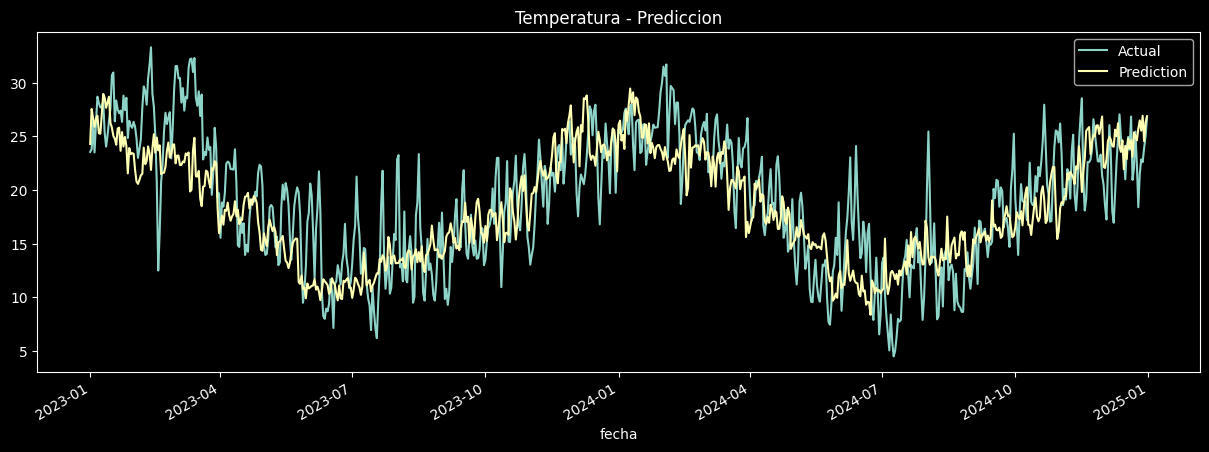

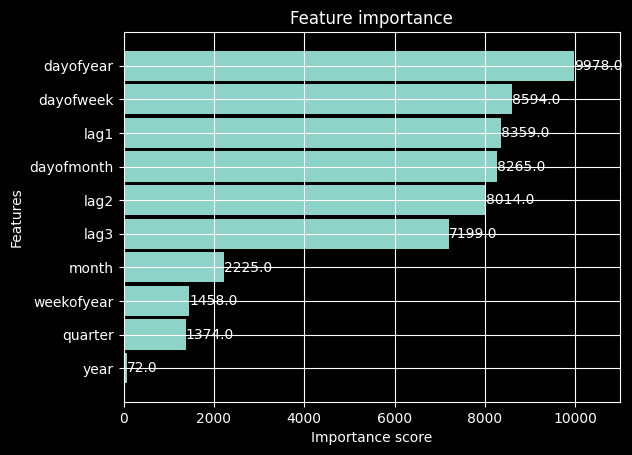

In [ ]:
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance

# 1. Create a new DataFrame called test_results from the X_test_final DataFrame
test_results = X_test_final.copy()
test_results['Actual'] = y_test_final
test_results['Prediction'] = y_pred_final

# 2. Plot the 'Actual' and 'Prediction' columns of the test_results DataFrame
plt.figure(figsize=(15, 5))
test_results['Actual'].plot(label='Actual')
test_results['Prediction'].plot(label='Prediction')
plt.title('Temperatura - Prediccion')

# 3. Add a legend to the plot to distinguish between the 'Actual' and 'Prediction' lines.
plt.legend()

# 4. Display the plot.
plt.show()

# 5. Generate a plot showing the importance of the features in the final_reg model
plot_importance(final_reg, height=0.9)

# 6. Display the feature importance plot.
plt.show()

## TimesFM

In [ ]:
# Cargar el modelo pre-entrenado
model = timesfm.TimesFM_2p5_200M_torch.from_pretrained("google/timesfm-2.5-200m-pytorch")

# Configurar el modelo para la inferencia
# max_context es la cantidad de datos pasados que usará para predecir.
# max_horizon es la cantidad máxima de pasos futuros que puede predecir.
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,    ## <- Aqui modifico la ventana, hay que probar diferentes variantes
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False,
        fix_quantile_crossing=True,
    )
)

In [ ]:
# 3. Preparación de tus datos
HORIZON = 15 # Tu horizonte de predicción

# Asumimos que df_siniestros ya está cargado y es un DataFrame de pandas
# con un índice de fecha y una columna con los valores de los siniestros.
# Por ejemplo: df_siniestros['cantidad_siniestros']

data_temperatura_TFM = df_modelo_temp.copy()
split_index = int(len(data_temperatura_TFM) * 0.8)
train_temperatura_TFM = data_temperatura_TFM[:split_index]
test_temperatura_TFM = data_temperatura_TFM[split_index:]
# --- ADAPTACIÓN CLAVE ---
# El modelo necesita los últimos `max_context` (1024) puntos del set de entrenamiento
# para predecir el futuro.
contexto_para_predecir = train_temperatura_TFM['Media'][-1024:].to_numpy()

# El modelo espera un formato específico: (batch_size, num_timesteps).
# En nuestro caso, el batch_size es 1.
inputs_del_modelo = contexto_para_predecir.reshape(1, -1)

print(f"Forma de los datos de entrada para el modelo: {inputs_del_modelo.shape}")

Forma de los datos de entrada para el modelo: (1, 1024)


In [ ]:
# 4. Generar la predicción
# Le pasamos el contexto que preparamos y el horizonte que definimos.
point_forecast, quantile_forecast = model.forecast(
    horizon=HORIZON,
    inputs=inputs_del_modelo
)

# El resultado 'point_forecast' es un array de numpy.
# Extraemos la primera (y única) predicción.
prediccion_temperatura = point_forecast[0]

print(f"Se generaron {len(prediccion_temperatura)} predicciones para los próximos {HORIZON} días.")

Se generaron 15 predicciones para los próximos 15 días.


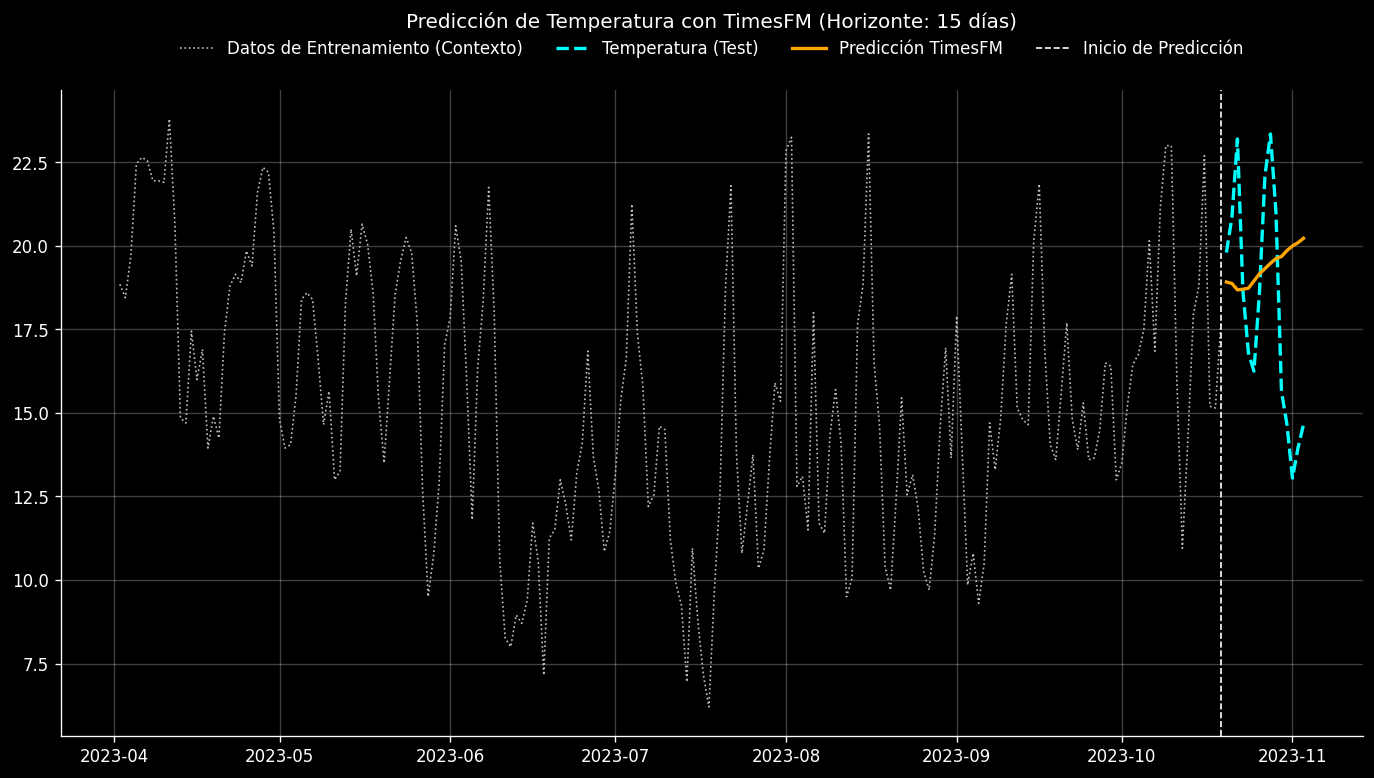

In [ ]:
# 5. Visualizar y comparar
# Creamos un DataFrame para facilitar la comparación
df_resultados = pd.DataFrame({
    'Reales': test_temperatura_TFM['Media'].iloc[:HORIZON].values,
    'Predichos': prediccion_temperatura
}, index=test_temperatura_TFM.index[:HORIZON])


# Graficamos los resultados
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 7), dpi=120)

# Datos de entrenamiento (mostramos una parte para dar contexto)
ax.plot(train_temperatura_TFM.index[-200:], train_temperatura_TFM['Media'][-200:],
        ls=':', lw=1, color='silver', label='Datos de Entrenamiento (Contexto)')

# Datos reales del período de prueba
ax.plot(df_resultados.index, df_resultados['Reales'],
        ls='--', lw=2, color='cyan', label=f'Temperatura (Test)')

# Predicciones del modelo
ax.plot(df_resultados.index, df_resultados['Predichos'],
        ls='-', lw=2, color='orange', label='Predicción TimesFM')

# Línea vertical para marcar el inicio de la predicción
ax.axvline(train_temperatura_TFM.index[-1], ls='--', lw=1, color='white', label='Inicio de Predicción')

ax.legend(frameon=False, ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.1))
ax.grid(alpha=0.25)
ax.set_title(f"Predicción de Temperatura con TimesFM (Horizonte: {HORIZON} días)", y=1.08)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

## TimesFM_2

Forma de los datos de entrada de Temperatura: (4, 730)


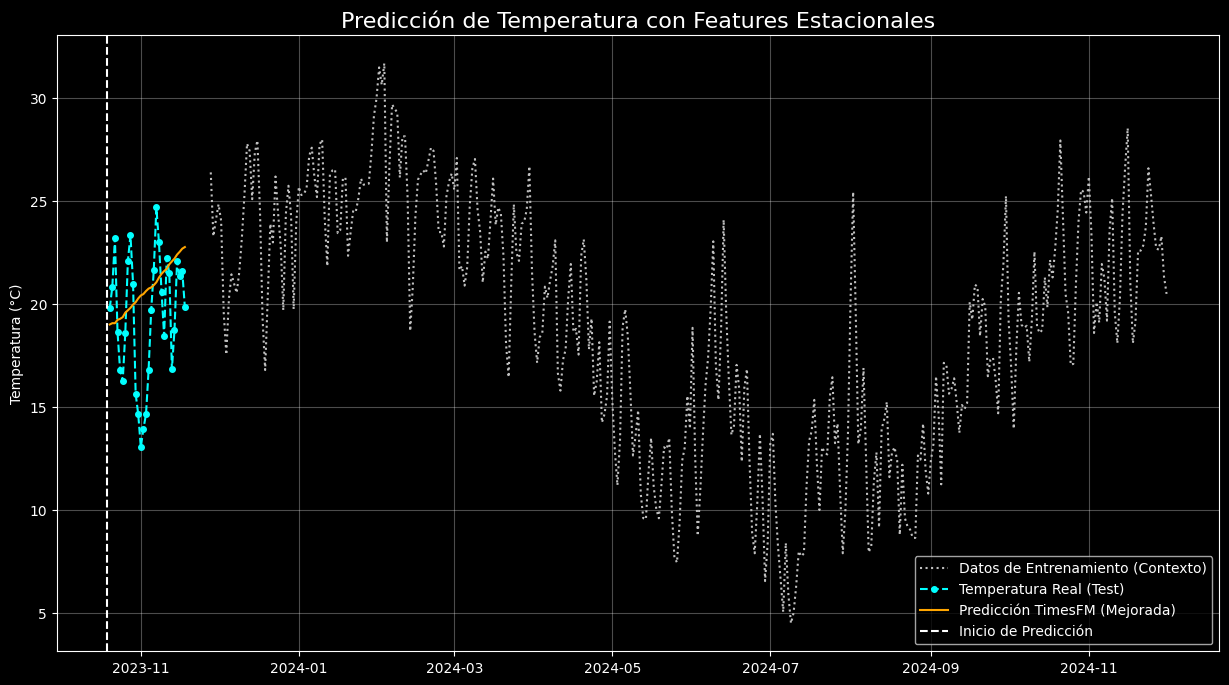

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Hacemos una copia para no modificar el dataframe original
df_temp_featured = df_modelo_temp.copy()

# La característica más importante para la temperatura es el ciclo anual.
# Usamos el día del año y lo transformamos con seno y coseno
# para que el modelo entienda que el día 365 está cerca del día 1.
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)

# También añadimos el día de la semana, que puede capturar patrones semanales
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

# --- 2. ESCALADO DE TODAS LAS CARACTERÍSTICAS ---

# Definimos la columna objetivo y las características que usaremos
TARGET_COLUMN_TEMP = 'Media'
# Nota: La columna objetivo también se escala junto con las demás.
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']

# Creamos y ajustamos el escalador a todas las características
scaler_temp = StandardScaler()
df_temp_featured[FEATURES_TEMP] = scaler_temp.fit_transform(df_temp_featured[FEATURES_TEMP])

# --- 3. DIVISIÓN DE DATOS Y PREPARACIÓN DEL INPUT ---
HORIZON_TEMP = 30
CONTEXT_WINDOW_TEMP = 730 # Un año de contexto es ideal para capturar la estacionalidad anual

split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp]
test_data_temp = df_temp_featured[split_index_temp:]

# Extraer el contexto del final del set de entrenamiento
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()

# Transponer para obtener la forma correcta: (num_features, context_length)
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN DEL MODELO Y PREDICCIÓN ---

# Re-compilamos el modelo con la configuración correcta para temperatura
# La única diferencia es infer_is_positive=False
model.compile(
    timesfm.ForecastConfig(
        max_context=1024,
        max_horizon=512,
        normalize_inputs=True,
        use_continuous_quantile_head=True,
        force_flip_invariance=True,
        infer_is_positive=False, # ¡Importante! La temperatura puede ser negativa
        fix_quantile_crossing=True,
    )
)

# Realizar la predicción
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP,
    inputs=model_inputs_temp
)

# --- 5. RE-ESCALADO DE LOS RESULTADOS Y VISUALIZACIÓN ---

# El modelo predice valores escalados, ¡debemos revertir la transformación!
# Creamos un array vacío con la misma forma que los datos originales (N, 4 features)
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
# Ponemos la predicción en la primera columna (la de la variable objetivo)
predicted_scaled[:, 0] = point_forecast_temp[0]

# Usamos el método `inverse_transform` del scaler para obtener los valores en la escala original
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)

# La predicción en la escala original está en la primera columna
predicted_values_temp = predicted_unscaled[:, 0]

# También necesitamos los datos reales sin escalar para comparar
reales_unscaled = scaler_temp.inverse_transform(
    test_data_temp[FEATURES_TEMP].iloc[:HORIZON_TEMP]
)[:, 0]

# Crear DataFrame para graficar
df_results_temp = pd.DataFrame({
    'Reales': reales_unscaled,
    'Predichos': predicted_values_temp
}, index=test_data_temp.index[:HORIZON_TEMP])

# Graficar
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df_modelo_temp['Media'][-400:-HORIZON_TEMP], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')
ax.plot(df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp['Predichos'], label='Predicción TimesFM (Mejorada)', color='orange', ls='-')
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')
ax.set_title('Predicción de Temperatura con Features Estacionales', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()


Forma de los datos de entrada de Temperatura: (4, 1095)


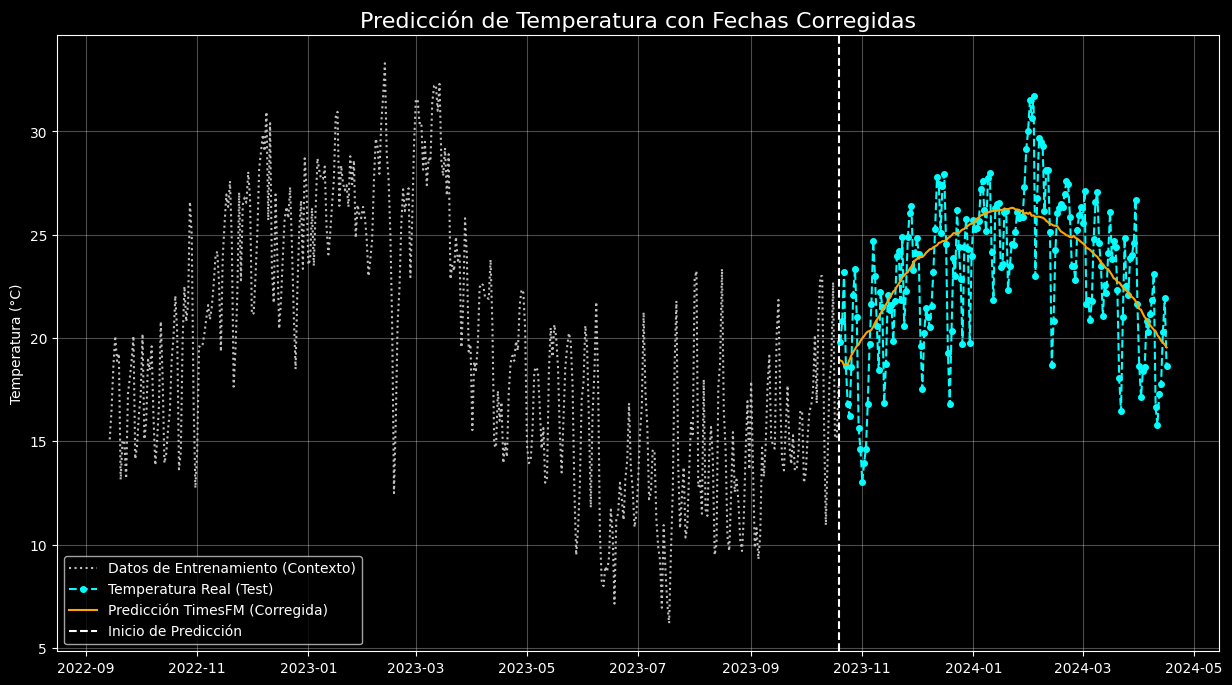

In [ ]:
# --- 1. FEATURE ENGINEERING (Esto ya estaba correcto) ---
df_temp_featured = df_modelo_temp.copy()
day_of_year = df_temp_featured.index.dayofyear
df_temp_featured['dayofyear_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofyear_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
df_temp_featured['dayofweek'] = df_temp_featured.index.dayofweek

TARGET_COLUMN_TEMP = 'Media'
FEATURES_TEMP = [TARGET_COLUMN_TEMP, 'dayofyear_sin', 'dayofyear_cos', 'dayofweek']
HORIZON_TEMP = 180 # Set the prediction horizon to 180 days
CONTEXT_WINDOW_TEMP = 1095

# --- 2. DIVISIÓN Y ESCALADO CORRECTOS (¡AQUÍ ESTÁ EL CAMBIO!) ---

# **PASO 2.1: PRIMERO, dividimos los datos**
split_index_temp = int(len(df_temp_featured) * 0.8)
train_data_temp = df_temp_featured[:split_index_temp].copy() # Usamos .copy() para evitar warnings
test_data_temp = df_temp_featured[split_index_temp:].copy()

# **PASO 2.2: LUEGO, creamos y AJUSTAMOS el escalador SOLO CON DATOS DE ENTRENAMIENTO**
scaler_temp = StandardScaler()
scaler_temp.fit(train_data_temp[FEATURES_TEMP])

# **PASO 2.3: AHORA, transformamos ambos conjuntos de datos por separado**
train_data_temp[FEATURES_TEMP] = scaler_temp.transform(train_data_temp[FEATURES_TEMP])
test_data_temp[FEATURES_TEMP] = scaler_temp.transform(test_data_temp[FEATURES_TEMP])

# --- 3. PREPARACIÓN DEL INPUT (Sin cambios, pero ahora usa datos bien escalados) ---
context_data_temp = train_data_temp[FEATURES_TEMP][-CONTEXT_WINDOW_TEMP:].to_numpy()
model_inputs_temp = context_data_temp.T
print(f"Forma de los datos de entrada de Temperatura: {model_inputs_temp.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN (Sin cambios) ---
model.compile(
    timesfm.ForecastConfig(
        max_context=1024, max_horizon=512, normalize_inputs=True,
        use_continuous_quantile_head=True, force_flip_invariance=True,
        infer_is_positive=False, fix_quantile_crossing=True,
    )
)
point_forecast_temp, quantile_forecast_temp = model.forecast(
    horizon=HORIZON_TEMP, inputs=model_inputs_temp # Use HORIZON_TEMP for the prediction horizon
)

# --- CORRECCIÓN CLAVE: Construcción robusta del DataFrame de resultados ---

# 1. Obtenemos el índice de fechas exacto para el período de la predicción.
prediction_index = test_data_temp.index[:HORIZON_TEMP]

# 2. Get the unscaled predicted values
predicted_scaled = np.zeros((len(point_forecast_temp[0]), len(FEATURES_TEMP)))
predicted_scaled[:, 0] = point_forecast_temp[0]
predicted_unscaled = scaler_temp.inverse_transform(predicted_scaled)
predicted_values_temp = predicted_unscaled[:, 0]

# 3. Obtenemos los valores reales correspondientes a ESE índice desde el DataFrame ORIGINAL (no escalado).
real_values = df_modelo_temp.loc[prediction_index, TARGET_COLUMN_TEMP]

# 4. Creamos el DataFrame de resultados asegurando que todo esté alineado.
df_results_temp = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values_temp
}, index=prediction_index)


# --- Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original para claridad
ax.plot(df_modelo_temp[TARGET_COLUMN_TEMP].loc[train_data_temp.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción - tomados del nuevo df_results_temp
ax.plot(df_results_temp.index, df_results_temp['Reales'], label='Temperatura Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results_temp.index, df_results_temp['Predichos'], label='Predicción TimesFM (Corregida)', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data_temp.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuraciones del gráfico
ax.set_title('Predicción de Temperatura con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calcular_metricas_error(y_true, y_pred):
    """
    Calcula el Error Absoluto Medio (MAE) y la Raíz del Error Cuadrático Medio (RMSE).

    Args:
        y_true (array-like): Valores reales u observados.
        y_pred (array-like): Valores predichos por el modelo.

    Returns:
        dict: Un diccionario con los valores de 'MAE' y 'RMSE'.
    """
    # Corregimos los nombres a los estándares en inglés para usar las librerías
    # MAE (Mean Absolute Error) = EMA (Error Medio Absoluto)
    mae = mean_absolute_error(y_true, y_pred)

    # RMSE (Root Mean Squared Error) = RSME
    # Se calcula la raíz cuadrada del Error Cuadrático Medio (MSE)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    return {'MAE': mae, 'RMSE': rmse}

# --- Ejemplo de uso con tu DataFrame 'df_results' ---

# Suponiendo que 'df_results' ya fue creado en el paso anterior
# Contiene las columnas 'Reales' y 'Predichos'
metricas = calcular_metricas_error(df_results['Reales'], df_results['Predichos'])

print(f"Resultados de las métricas de error:")
print(f"Error Absoluto Medio (MAE): {metricas['MAE']:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {metricas['RMSE']:.2f}")

## Chronos

In [ ]:
df_modelo_temp_chronos = df_modelo_temp.copy()
## Parametros de prediccion
step_to_predict= 45  # Da la cantidad de pasos hacia adelante que vamos a predecir
samples_to_consider= 2 # Simula 5 futuros posibles para entender mejor lo que puede pasar

In [ ]:
## Proyeccion
forecast = pipeline.predict(
    context=torch.tensor(df_modelo_temp_chronos["Media"]),
    prediction_length=step_to_predict,
    num_samples=samples_to_consider,
)

forecast_index = range(len(df_modelo_temp_chronos), len(df_modelo_temp_chronos) + step_to_predict)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

In [ ]:
predicted_mean = forecast.mean(axis=0)
print(predicted_mean)

tensor([[27.7972, 27.9349, 24.3570, 23.6689, 23.9442, 25.7331, 26.4211, 26.4211,
         23.3937, 20.6415, 24.3570, 25.3203, 26.6964, 26.1459, 25.0450, 21.8800,
         22.9809, 24.7698, 26.0083, 27.6596, 27.7972, 27.2468, 26.0083, 26.0083,
         23.6689, 23.2561, 26.1459, 27.5220, 27.2468, 24.3570, 24.4946, 23.8065,
         25.0450, 26.1459, 26.2835, 26.2835, 27.6596, 25.1827, 24.4946, 24.9074,
         23.5313, 25.7331, 26.2835, 25.3203, 24.9074],
        [27.9349, 27.6596, 28.0725, 24.0818, 21.6048, 21.8800, 21.8800, 22.5681,
         25.1827, 26.4211, 23.8065, 23.5313, 24.2194, 27.5220, 28.8981, 30.8247,
         28.4853, 24.3570, 27.7972, 27.3844, 24.3570, 26.4211, 26.8340, 26.2835,
         28.6229, 27.7972, 28.8981, 26.1459, 28.2101, 28.2101, 27.2468, 28.4853,
         26.8340, 28.6229, 25.0450, 23.5313, 25.4579, 26.6964, 25.7331, 23.8065,
         21.6048, 23.5313, 26.1459, 26.8340, 25.7331]])


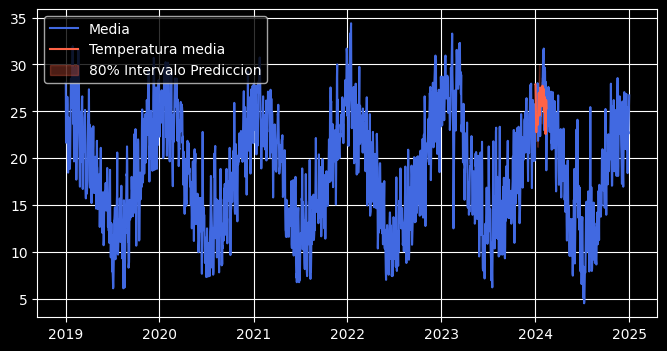

In [ ]:
# Grafico
plt.figure(figsize=(8, 4))
plt.plot(df_modelo_temp_chronos["Media"], color="royalblue", label="Media")
# Modified: Plot the median prediction starting from the end of the historical data index
plt.plot(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), median, color="tomato", label="Temperatura media")
plt.fill_between(df_siniestros.index[-1] + pd.to_timedelta(np.arange(1, step_to_predict + 1), unit='D'), low, high, color="tomato", alpha=0.3, label="80% Intervalo Prediccion")
plt.legend()
plt.grid()
plt.show()

## Chronos_2

In [ ]:
n_test = 25
df_temperatura_chronos_train = df_modelo_temp_chronos[:-n_test]
df_temperatura_chronos_test = df_modelo_temp_chronos [-n_test:]

In [ ]:
df_siniestros_chronos_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2023-12-07 to 2023-12-31
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   cantidad_eventos  25 non-null     int64
dtypes: int64(1)
memory usage: 400.0 bytes


In [ ]:
fechas_train = df_temperatura_chronos_train.index
fechas_test = df_temperatura_chronos_test.index

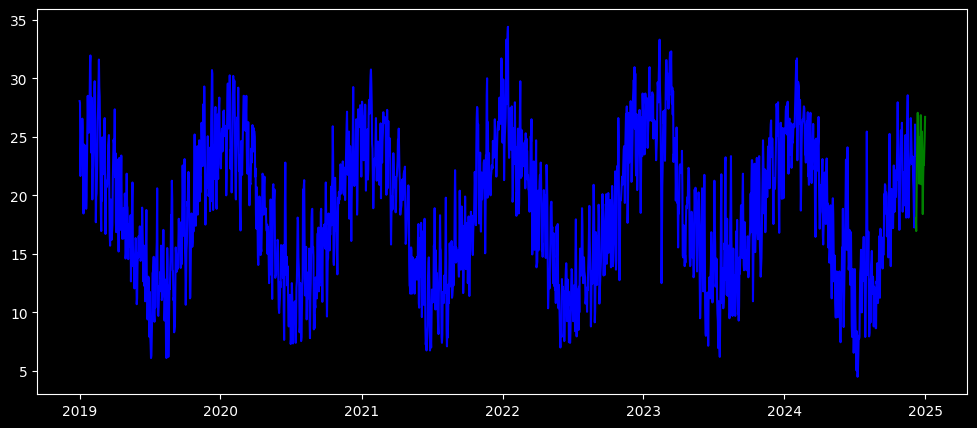

In [ ]:
plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_temperatura_chronos_train["Media"], label="Entrenamiento", color="blue")
plt.plot(fechas_test, df_temperatura_chronos_test["Media"], label="Test real", color="green")

In [ ]:
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",
    torch_dtype=torch.bfloat16,
)

In [ ]:
quantiles, mean = pipeline.predict_quantiles(
    context=torch.tensor(df_temperatura_chronos_train["Media"]),
    prediction_length=n_test,
    quantile_levels=[0.1, 0.5, 0.9],
)

'''
El codigo nos da =
quantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.
quantiles[0.5] = idem pero para la mediana.
quantiles[0.9]= para el cuantil 90%.
mean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.
'''

'\nEl codigo nos da =\nquantiles[0.1] --> tensor de 24 valores representando el cuantil 10% para cada paso futuro.\nquantiles[0.5] = idem pero para la mediana.\nquantiles[0.9]= para el cuantil 90%.\nmean: tensor de 24 valores representando el valor medio predicho para cada paso futuro.\n'

In [ ]:
# Aca imprime la ayuda del metodo
from chronos import ChronosPipeline, ChronosBoltPipeline

print(ChronosPipeline.predict.__doc__)  # for Chronos models
print(ChronosBoltPipeline.predict.__doc__)  # for Chronos-Bolt models


        Get forecasts for the given time series.

        Refer to the base method (``BaseChronosPipeline.predict``)
        for details on shared parameters.

        Additional parameters
        ---------------------
        num_samples
            Number of sample paths to predict. Defaults to what
            specified in ``self.model.config``.
        temperature
            Temperature to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_k
            Top-k parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        top_p
            Top-p parameter to use for generating sample tokens.
            Defaults to what specified in ``self.model.config``.
        limit_prediction_length
            Force prediction length smaller or equal than the
            built-in prediction length from the model. False by
            default. When true, fail loudly if longer p

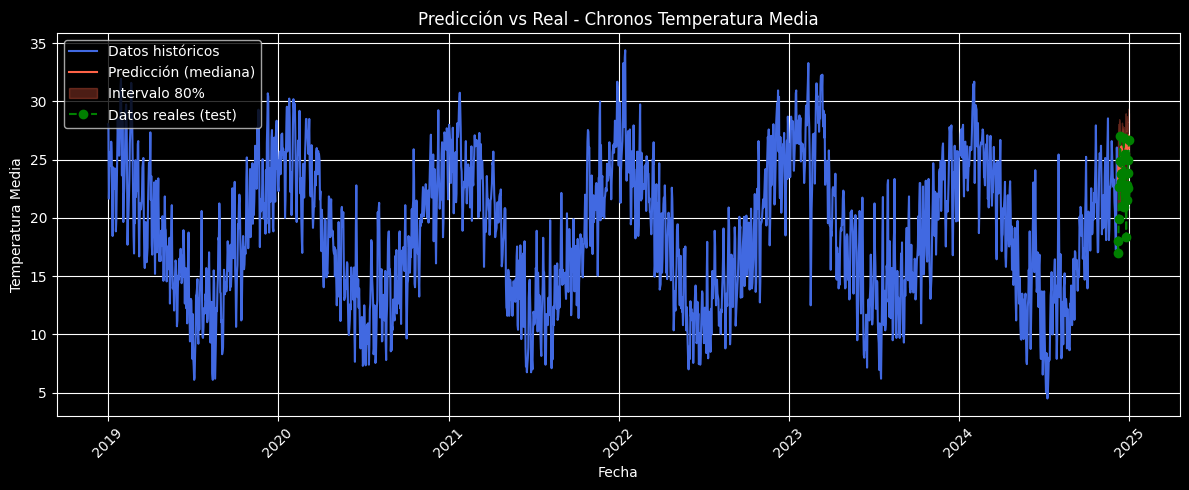

In [ ]:
import matplotlib.pyplot as plt
from datetime import timedelta
import numpy as np # Import numpy

# Extract quantiles and median from the prediction results
low, median, high = quantiles[0, :, 0], quantiles[0, :, 1], quantiles[0, :, 2]

# Get the actual values from the test set
actual = df_temperatura_chronos_test["Media"].values

# Get the last date from the training set index
last_train_date = fechas_train[-1]

# Create a date range for the forecast starting from the day after the last training date
# The length of the forecast dates should match the length of the median prediction
forecast_dates = [last_train_date + timedelta(days=i) for i in range(1, len(median) + 1)]


plt.figure(figsize=(12, 5))

plt.plot(fechas_train, df_temperatura_chronos_train["Media"], color="royalblue", label="Datos históricos")
plt.plot(forecast_dates, median, color="tomato", label="Predicción (mediana)")
plt.fill_between(forecast_dates, low, high, color="tomato", alpha=0.3, label="Intervalo 80%")
plt.plot(fechas_test, actual, color="green", linestyle="--", marker="o", label="Datos reales (test)")

plt.legend()
plt.grid()
plt.title("Predicción vs Real - Chronos Temperatura Media")
plt.xlabel("Fecha")
plt.ylabel("Temperatura Media")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate RMSE for Chronos
rmse_chronos = np.sqrt(mean_squared_error(actual, median))

# Calculate MAE for Chronos
mae_chronos = mean_absolute_error(actual, median)

print(f"Chronos Model RMSE on Test Set: {rmse_chronos:0.2f}")
print(f"Chronos Model MAE on Test Set: {mae_chronos:0.2f}")

Chronos Model RMSE on Test Set: 3.52
Chronos Model MAE on Test Set: 2.92


## AutoML

In [ ]:
import time # Import the time module
# AUTOTS APLICADO A TEMPERATURA

print("\n--- Iniciando análisis de Temperatura con AutoTS (Versión Rápida) ---")

# Usamos una copia para asegurar que el DataFrame original no se modifica
df_target = df_modelo_temp.copy()
target_col = 'Media'

# Convertir el índice 'fecha' en una columna
df_target.reset_index(inplace=True)

# División 80/20 para entrenamiento y prueba
split_point = math.trunc(len(df_target) * 0.8)
train_data = df_target.iloc[:split_point]
test_data = df_target.iloc[split_point:]
print(f"Tamaño de entrenamiento: {len(train_data)}, Tamaño de prueba: {len(test_data)}")


model_temp_autots = AutoTS(
    forecast_length=len(test_data),
    frequency='D',
    prediction_interval=0.95,
    ensemble='simple',
    model_list='fast',
    max_generations=3,
    num_validations=1,
    no_negatives=False,
    n_jobs='auto'
)


print("\nEntrenando modelo AutoTS para Temperatura...")
start_time = time.time() # Start the timer
model_temp_autots.fit(train_data, date_col='fecha', value_col=target_col)
end_time = time.time() # Stop the timer
print(f"Tiempo de entrenamiento del modelo AutoTS: {end_time - start_time:.2f} segundos") # Print the elapsed time

# Predicción
prediction = model_temp_autots.predict()
forecast = prediction.forecast

# Preparar el DataFrame de test para graficar
test_data.set_index('fecha', inplace=True)

# Evaluación y almacenamiento de métricas
print("\n--- Resumen del Modelo Seleccionado ---")
print(model_temp_autots)
mae = mean_absolute_error(test_data[target_col], forecast[target_col])
rmse = np.sqrt(mean_squared_error(test_data[target_col], forecast[target_col]))
autots_results_summary['Temperatura'] = {'MAE': mae, 'RMSE': rmse}
print(f"\n--- Métricas en Test --- \nMAE: {mae:.4f} \nRMSE: {rmse:.4f}")


--- Iniciando análisis de Temperatura con AutoTS (Versión Rápida) ---
Tamaño de entrenamiento: 1752, Tamaño de prueba: 439
Using 1 cpus for n_jobs.

Entrenando modelo AutoTS para Temperatura...
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 3
Model Number: 2 with model AverageValueNaive in generation 0 of 3
Model Number: 3 with model AverageValueNaive in generation 0 of 3
Model Number: 4 with model DatepartRegression in generation 0 of 3
Model Number: 5 with model DatepartRegression in generation 0 of 3
Model Number: 6 with model DatepartRegression in generation 0 of 3
Model Number: 7 with model DatepartRegression in generation 0 of 3
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.4004
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3475
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2867
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2400
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 58 with model ETS in generation 0 of 3
Model Number: 59 with model VAR in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VAR') in model 59 in generation 0: VAR
Model Number: 60 with model VECM in generation 0 of 3
Template Eval Error: ValueError('Only gave one variable to VECM') in model 60 in generation 0: VECM
Model Number: 61 with model WindowRegression in generation 0 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 61 in generation 0: WindowRegression
Model Number: 62 with model DatepartRegression in generation 0 of 3
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {'constant': 0, 'reintroduction_model': {'model': 'SGD', 'model_params': {}, 'datepart_method': 'simple_binarized'}, 'fillna': 'mean'}} with error ValueError('The number of classes has to be greater than one; got 1 class')") in model 62 in generation 0: DatepartRegression
Mo

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 164 with model LastValueNaive in generation 0 of 3
Model Number: 165 with model FFT in generation 0 of 3
Model Number: 166 with model DatepartRegression in generation 0 of 3
New Generation: 1 of 3
Model Number: 167 with model DatepartRegression in generation 1 of 3
Template Eval Error: IndexError('tuple index out of range') in model 167 in generation 1: DatepartRegression
Model Number: 168 with model SeasonalityMotif in generation 1 of 3
Model Number: 169 with model AverageValueNaive in generation 1 of 3
Model Number: 170 with model WindowRegression in generation 1 of 3
Model Number: 171 with model ETS in generation 1 of 3
Model Number: 172 with model Cassandra in generation 1 of 3
Model Number: 173 with model SectionalMotif in generation 1 of 3
Model Number: 174 with model SeasonalNaive in generation 1 of 3
Model Number: 175 with model LastValueNaive in generation 1 of 3
Model Number: 176 with model GLS in generation 1 of 3
Model Number: 177 with model GLS in generation 

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 197 with model SeasonalNaive in generation 1 of 3
Model Number: 198 with model AverageValueNaive in generation 1 of 3
Model Number: 199 with model LastValueNaive in generation 1 of 3
Template Eval Error: Exception("Transformer FIRFilter failed on inverse from params ffill {'0': {'numtaps': 7, 'cutoff_hz': 10, 'window': 'blackman', 'sampling_frequency': 12, 'on_transform': False, 'on_inverse': True, 'bounds_only': True}, '1': {}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 1, 'threshold_method': 'max'}} with ValueError('Invalid cutoff frequency: frequencies must be greater than 0 and less than fs/2.')") in model 199 in generation 1: LastValueNaive
Model Number: 200 with model SeasonalNaive in generation 1 of 3
Model Number: 201 with model SeasonalityMotif in generation 1 of 3
Model Number: 202 with model UnivariateMotif in generation 1 of 3
Model Number: 203 with model SeasonalNaive in generation 1 of 3
Model Nu

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: ValueError('Model GLM returned NaN for one or more series. fail_on_forecast_nan=True') in model 252 in generation 1: GLM
Model Number: 253 with model SectionalMotif in generation 1 of 3
Model Number: 254 with model AverageValueNaive in generation 1 of 3
Model Number: 255 with model AverageValueNaive in generation 1 of 3
Model Number: 256 with model GLS in generation 1 of 3
Model Number: 257 with model LastValueNaive in generation 1 of 3
Model Number: 258 with model BasicLinearModel in generation 1 of 3
Model Number: 259 with model SeasonalNaive in generation 1 of 3
Model Number: 260 with model SeasonalNaive in generation 1 of 3
Model Number: 261 with model MetricMotif in generation 1 of 3
Model Number: 262 with model FFT in generation 1 of 3
Model Number: 263 with model DatepartRegression in generation 1 of 3
Model Number: 264 with model AverageValueNaive in generation 1 of 3
Template Eval Error: Exception('Transformer LocalLinearTrend failed on inverse from params

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 299 with model SectionalMotif in generation 2 of 3
Model Number: 300 with model WindowRegression in generation 2 of 3
Model Number: 301 with model LastValueNaive in generation 2 of 3
Model Number: 302 with model WindowRegression in generation 2 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 302 in generation 2: WindowRegression
Model Number: 303 with model MetricMotif in generation 2 of 3
Model Number: 304 with model SectionalMotif in generation 2 of 3
Model Number: 305 with model GLM in generation 2 of 3
Model Number: 306 with model Cassandra in generation 2 of 3
Template Eval Error: Exception("Transformer ReplaceConstant failed on fit from params ffill {'0': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 0.5, 'first_value_only': False, 'threshold': None, 'threshold_method': 'max'}, '1': {'model': 'GLS', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {'constant': 0, 'reintroduction_model': {'model'

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Model Number: 324 with model SeasonalNaive in generation 2 of 3
Model Number: 325 with model WindowRegression in generation 2 of 3
Model Number: 326 with model SeasonalNaive in generation 2 of 3
Model Number: 327 with model SectionalMotif in generation 2 of 3
Template Eval Error: ValueError('operands could not be broadcast together with shapes (878,1) (439,1) ') in model 327 in generation 2: SectionalMotif
Model Number: 328 with model UnivariateMotif in generation 2 of 3
Model Number: 329 with model SectionalMotif in generation 2 of 3
Model Number: 330 with model AverageValueNaive in generation 2 of 3
Model Number: 331 with model LastValueNaive in generation 2 of 3
Model Number: 332 with model DatepartRegression in generation 2 of 3
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1349
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0978
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0613
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.04

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 339 with model NVAR in generation 2 of 3
Model Number: 340 with model GLM in generation 2 of 3
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 340 in generation 2: GLM
Model Number: 341 with model DatepartRegression in generation 2 of 3


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 342 with model UnivariateMotif in generation 2 of 3
Model Number: 343 with model WindowRegression in generation 2 of 3
Model Number: 344 with model DatepartRegression in generation 2 of 3
Model Number: 345 with model BallTreeMultivariateMotif in generation 2 of 3
Model Number: 346 with model BasicLinearModel in generation 2 of 3
Model Number: 347 with model WindowRegression in generation 2 of 3
Model Number: 348 with model GLS in generation 2 of 3
Model Number: 349 with model SectionalMotif in generation 2 of 3
Model Number: 350 with model BasicLinearModel in generation 2 of 3
Template Eval Error: Exception('Transformer ChangepointDetrend failed on fit from params pchip {\'0\': {\'rows\': 1}, \'1\': {\'rows\': 1, \'lag\': 1, \'method\': \'additive\', \'strength\': 1.0, \'first_value_only\': False, \'threshold\': 1, \'threshold_method\': \'max\'}, \'2\': {\'model\': \'Gamma\', \'changepoint_spacing\': 90, \'changepoint_distance_end\': 5040, \'datepart_method\': None}} with

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 413 with model BasicLinearModel in generation 3 of 3
Model Number: 414 with model MAR in generation 3 of 3
Model Number: 415 with model Cassandra in generation 3 of 3
Template Eval Error: Exception("Transformer Cointegration failed on fit from params zero {'0': {'det_order': 1, 'k_ar_diff': 2}, '1': {'output_distribution': 'uniform', 'n_quantiles': 'fifth'}, '2': {'n_harmonics': 0.5, 'detrend': 'cubic'}, '3': {'threshold': 0.9, 'splash_threshold': None, 'use_dayofmonth_holidays': True, 'use_wkdom_holidays': True, 'use_wkdeom_holidays': False, 'use_lunar_holidays': False, 'use_lunar_weekday': False, 'use_islamic_holidays': False, 'use_hebrew_holidays': False, 'use_hindu_holidays': False, 'anomaly_detector_params': {'method': 'zscore', 'method_params': {'distribution': 'norm', 'alpha': 0.08}, 'fillna': 'rolling_mean_24', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'mod

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 10.8640
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2646
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6042
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6037
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 10/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 11/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 12/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6036
Epoch 13/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 14/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035
Epoch 15/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6035

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Model Number: 483 with model DatepartRegression in generation 3 of 3
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 483 in generation 3: DatepartRegression
Model Number: 484 with model MetricMotif in generation 3 of 3
Model Number: 485 with model DatepartRegression in generation 3 of 3
Model Number: 486 with model MetricMotif in generation 3 of 3
Model Number: 487 with model FFT in generation 3 of 3
Model Number: 488 with model Cassandra in generation 3 of 3
Model Number: 489 with model AverageValueNaive in generation 3 of 3
Model Number: 490 with model SeasonalityMotif in generation 3 of 3
Model Number: 491 with model GLS in generation 3 of 3
Model Number: 492 with model BallTreeMultivariateMotif in generation 3 of 3
Template Eval Error: Exception('Transformer PowerTransformer failed on inverse from params quadratic {\'0\': {\'constraint_method\': \'dampening\', \'constraint_direction\': \'upper\', \'constraint_regularization\': 1.0, 

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


18 - GLM with avg smape 17.11: 
Model Number: 19 of 77 with model SectionalMotif for Validation 1
19 - SectionalMotif with avg smape 26.83: 
Model Number: 20 of 77 with model Cassandra for Validation 1
20 - Cassandra with avg smape 17.33: 
Model Number: 21 of 77 with model DatepartRegression for Validation 1
📈 21 - DatepartRegression with avg smape 15.93: 
Model Number: 22 of 77 with model GLS for Validation 1
22 - GLS with avg smape 20.38: 
Model Number: 23 of 77 with model Cassandra for Validation 1
23 - Cassandra with avg smape 20.59: 
Model Number: 24 of 77 with model GLM for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


24 - GLM with avg smape 20.02: 
Model Number: 25 of 77 with model GLS for Validation 1
25 - GLS with avg smape 20.44: 
Model Number: 26 of 77 with model GLS for Validation 1
26 - GLS with avg smape 20.6: 
Model Number: 27 of 77 with model DatepartRegression for Validation 1
27 - DatepartRegression with avg smape 20.54: 
Model Number: 28 of 77 with model DatepartRegression for Validation 1
28 - DatepartRegression with avg smape 20.04: 
Model Number: 29 of 77 with model SectionalMotif for Validation 1
29 - SectionalMotif with avg smape 25.53: 
Model Number: 30 of 77 with model AverageValueNaive for Validation 1
30 - AverageValueNaive with avg smape 20.52: 
Model Number: 31 of 77 with model BasicLinearModel for Validation 1
31 - BasicLinearModel with avg smape 21.85: 
Model Number: 32 of 77 with model GLM for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


📈 32 - GLM with avg smape 15.74: 
Model Number: 33 of 77 with model BallTreeMultivariateMotif for Validation 1
33 - BallTreeMultivariateMotif with avg smape 24.89: 
Model Number: 34 of 77 with model BallTreeMultivariateMotif for Validation 1
34 - BallTreeMultivariateMotif with avg smape 23.78: 
Model Number: 35 of 77 with model SectionalMotif for Validation 1
35 - SectionalMotif with avg smape 47.94: 
Model Number: 36 of 77 with model SectionalMotif for Validation 1
36 - SectionalMotif with avg smape 20.91: 
Model Number: 37 of 77 with model SeasonalNaive for Validation 1
37 - SeasonalNaive with avg smape 18.61: 
Model Number: 38 of 77 with model SeasonalNaive for Validation 1
38 - SeasonalNaive with avg smape 18.61: 
Model Number: 39 of 77 with model UnivariateMotif for Validation 1
39 - UnivariateMotif with avg smape 21.66: 
Model Number: 40 of 77 with model SectionalMotif for Validation 1
40 - SectionalMotif with avg smape 26.16: 
Model Number: 41 of 77 with model GLM for Validation

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 594 in generation 5: Ensemble
Model Number: 595 with model Ensemble in generation 5 of Ensembles


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 600 in generation 5: Ensemble
Model Number: 601 with model Ensemble in generation 5 of Ensembles
Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1453
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1085
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0746
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0517
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0430
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0389
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0345
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0290
Epoch 10/50
42/42 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 624 in generation 5: Ensemble
Model Number: 625 with model Ensemble in generation 5 of Ensembles


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 630 in generation 5: Ensemble
Model Number: 631 with model Ensemble in generation 5 of Ensembles


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 636 in generation 5: Ensemble
Model Number: 637 with model Ensemble in generation 5 of Ensembles


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 642 in generation 5: Ensemble
Validation Round: 1
Model Number: 1 of 9 with model Ensemble for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


📈 1 - Ensemble with avg smape 16.13: 
2 - Ensemble with avg smape 16.16: 
3 - Ensemble with avg smape 16.67: 
📈 4 - Ensemble with avg smape 15.94: 
5 - Ensemble with avg smape 34.88: 
6 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 6 in generation 0: Ensemble
Model Number: 7 of 9 with model Ensemble for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


7 - Ensemble with avg smape 16.16: 
8 - Ensemble with avg smape 16.17: 
9 - Ensemble with avg smape 16.16: 
📈 10 - Ensemble with avg smape 15.84: 
11 - Ensemble with avg smape 35.48: 
12 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 12 in generation 0: Ensemble
Model Number: 13 of 9 with model Ensemble for Validation 1
Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1469
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1236
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0996
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0813
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0680
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0555
Epoch 7/50

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


31 - Ensemble with avg smape 15.99: 
32 - Ensemble with avg smape 16.02: 
33 - Ensemble with avg smape 17.41: 
34 - Ensemble with avg smape 16.05: 
35 - Ensemble with avg smape 34.47: 
36 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 36 in generation 0: Ensemble
Model Number: 37 of 9 with model Ensemble for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


37 - Ensemble with avg smape 16.02: 
38 - Ensemble with avg smape 16.05: 
39 - Ensemble with avg smape 16.7: 
40 - Ensemble with avg smape 16.03: 
41 - Ensemble with avg smape 34.77: 
42 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 42 in generation 0: Ensemble
Model Number: 43 of 9 with model Ensemble for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


43 - Ensemble with avg smape 16.28: 
44 - Ensemble with avg smape 16.31: 
45 - Ensemble with avg smape 16.55: 
46 - Ensemble with avg smape 16.19: 
47 - Ensemble with avg smape 34.84: 
48 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 48 in generation 0: Ensemble
Model Number: 49 of 9 with model Ensemble for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


49 - Ensemble with avg smape 16.2: 
50 - Ensemble with avg smape 16.22: 
51 - Ensemble with avg smape 16.48: 
52 - Ensemble with avg smape 16.01: 
53 - Ensemble with avg smape 34.93: 
54 - Ensemble with avg smape 37.1: 
Template Eval Error: Exception("Transformer HistoricValues failed on fit from params fake_date {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10, 'threshold_method': 'mean'}, '1': {'window': 28}} with error KeyError('2')") in model 54 in generation 0: Ensemble
Tiempo de entrenamiento del modelo AutoTS: 743.68 segundos


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



--- Resumen del Modelo Seleccionado ---
Initiated AutoTS object with best model: 
Ensemble
{'fillna': 'rolling_mean_24', 'transformations': {'0': 'bkfilter', '1': 'FIRFilter', '2': 'AlignLastDiff'}, 'transformation_params': {'0': {}, '1': {'numtaps': 128, 'cutoff_hz': 0.01, 'window': 'blackman', 'sampling_frequency': 60, 'on_transform': False, 'on_inverse': True}, '2': {'rows': 90, 'displacement_rows': 1, 'quantile': 1.0, 'decay_span': 90}}}
{'model_name': 'BestN', 'model_count': 5, 'model_metric': 'bestn_horizontal', 'models': {'337844f9a05022da55d56b278a632677': {'Model': 'BasicLinearModel', 'ModelParameters': '{"datepart_method": "common_fourier", "changepoint_spacing": 28, "changepoint_distance_end": 5040, "regression_type": null, "lambda_": null, "trend_phi": 0.98, "holiday_countries_used": true}', 'TransformationParameters': '{"fillna": "ffill", "transformations": {"0": "CenterSplit", "1": "PowerTransformer"}, "transformation_params": {"0": {"fillna": "one", "center": "zero"}, "

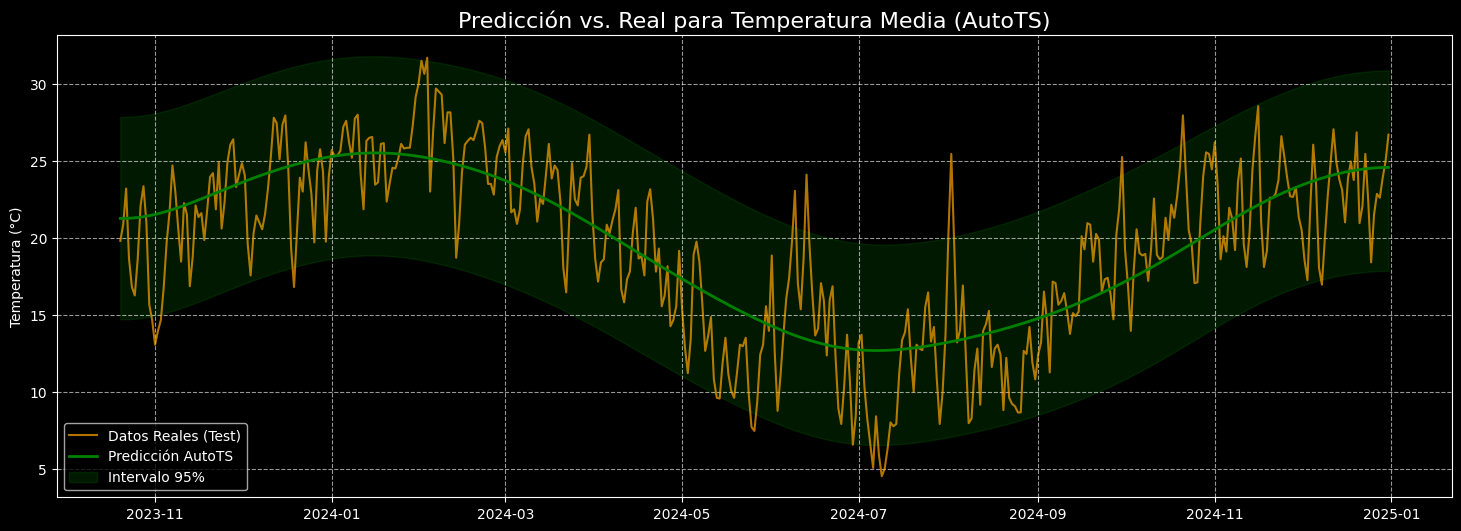

In [ ]:
# Visualización
fig, ax = plt.subplots(figsize=(18, 6))
# Añadimos un poco de transparencia (alpha) a los datos reales para ver mejor la predicción
ax.plot(test_data.index, test_data[target_col], label='Datos Reales (Test)', color='orange', alpha=0.7)
ax.plot(forecast.index, forecast[target_col], label='Predicción AutoTS', color='green', linewidth=2)

lower_forecast = prediction.lower_forecast
upper_forecast = prediction.upper_forecast
ax.fill_between(forecast.index, lower_forecast[target_col], upper_forecast[target_col], color='green', alpha=0.2, label='Intervalo 95%')

ax.set_title('Predicción vs. Real para Temperatura Media (AutoTS)', fontsize=16) # <-- CAMBIO: Título
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Series Unificadas

In [ ]:
print(df_siniestros.head(2))
print(df_temperatura.head(2))
print(df_precipitaciones.head(2))
for df in [df_siniestros, df_temperatura, df_precipitaciones]:
    df.index = pd.to_datetime(df.index)

            cantidad_eventos
fecha                       
2019-01-01                18
2019-01-02                16
            Maxima  Minima  Media
fecha                            
2019-01-01    32.7    23.4  28.05
2019-01-02    32.1    23.7  27.90
            (mm)
fecha           
2019-01-01   2.0
2019-01-02   9.0


In [ ]:
series_unificadas = pd.concat([df_siniestros, df_temperatura, df_precipitaciones], axis=1)
series_unificadas.head()
fecha_limite = pd.to_datetime("2023-12-31")
series_unificadas = series_unificadas[series_unificadas.index <= fecha_limite]

In [ ]:
series_unificadas['day_name']= series_unificadas.index.day_name()
series_unificadas['mes']= series_unificadas.index.month
series_unificadas['dia']= series_unificadas.index.day

In [ ]:
fin_de_semana=['Saturday', 'Sunday']
series_unificadas['fin_de_semana'] = series_unificadas['day_name'].isin(fin_de_semana).astype(int)
import holidays

# Asegurate de que el índice contiene fechas tipo datetime
series_unificadas.index = pd.to_datetime(series_unificadas.index)

# Crear lista de años únicos del índice
años = series_unificadas.index.year.unique()

# Crear objeto de feriados para Argentina para esos años
ar_holidays = holidays.country_holidays('AR', years=años)

# Marcar feriados basados en el índice
series_unificadas['feriado'] = series_unificadas.index.isin(ar_holidays).astype(int)

# También podés marcar fines de semana usando el índice
series_unificadas['fin_de_semana'] = series_unificadas.index.dayofweek.isin([5, 6]).astype(int)

In [ ]:
series_unificadas[series_unificadas['feriado'] == 1]

cantidad_eventos  Maxima  Minima  Media  (mm) day_name  mes  dia  \
fecha                                                                          
2019-01-01              18.0    32.7    23.4  28.05   2.0  Tuesday    1    1   
2019-03-04              11.0    25.5    19.7  22.60   0.6   Monday    3    4   
2019-03-05              10.0    27.3    17.4  22.35   0.0  Tuesday    3    5   
2019-03-24              28.0    23.2    15.9  19.55   0.0   Sunday    3   24   
2019-04-02              23.0    32.7    22.0  27.35   0.0  Tuesday    4    2   
...                      ...     ...     ...    ...   ...      ...  ...  ...   
2023-10-13              22.0    19.5     8.9  14.20   0.0   Friday   10   13   
2023-10-16              17.0    28.6    16.8  22.70   0.0   Monday   10   16   
2023-11-20              17.0    31.2    16.7  23.95   0.0   Monday   11   20   
2023-12-08              32.0    24.9    16.2  20.55   0.0   Friday   12    8   
2023-12-25              11.0    26.9    18.8  22.85   0.0   Monday   12   25   

            fin_de_semana  feriado  
fecha                               
2019-01-01              0        1  
2019-03-04              0        1  
2019-03-05              0        1  
2019-03-24              1        1  
2019-04-02              0        1  
...                   ...      ...  
2023-10-13              0        1  
2023-10-16              0        1  
2023-11-20              0        1  
2023-12-08              0        1  
2023-12-25              0        1  

[101 rows x 10 columns]

In [ ]:
series_unificadas.head()

cantidad_eventos  Maxima  Minima  Media  (mm)   day_name  mes  \
fecha                                                                       
2019-01-01              18.0    32.7    23.4  28.05   2.0    Tuesday    1   
2019-01-02              16.0    32.1    23.7  27.90   9.0  Wednesday    1   
2019-01-03              24.0    26.3    17.0  21.65   0.0   Thursday    1   
2019-01-04              35.0    28.9    18.0  23.45   0.0     Friday    1   
2019-01-05              19.0    30.1    21.2  25.65   1.0   Saturday    1   

            dia  fin_de_semana  feriado  
fecha                                    
2019-01-01    1              0        1  
2019-01-02    2              0        0  
2019-01-03    3              0        0  
2019-01-04    4              0        0  
2019-01-05    5              1        0

In [ ]:
series_unificadas['lluvia'] = (series_unificadas['(mm)'] > 0).astype(int)

In [ ]:
def clasificar_lluvia(mm):
    if mm >= 0 and mm <= 0.09:
        return 'sin lluvia'
    elif mm >= 0.1 and mm <= 2:
        return 'debil'
    elif mm >= 2.1 and mm <= 15:
        return 'moderado'
    elif mm >= 15.1 and mm <= 30:
        return 'fuerte'
    elif mm >= 30.1 and mm<-60:
        return 'muy fuerte'
    else:
        return 'torrencial'

In [ ]:
series_unificadas['intensidad']= series_unificadas['(mm)'].apply (clasificar_lluvia)

In [ ]:
series_unificadas.head(3)

cantidad_eventos  Maxima  Minima  Media  (mm)   day_name  mes  \
fecha                                                                       
2019-01-01              18.0    32.7    23.4  28.05   2.0    Tuesday    1   
2019-01-02              16.0    32.1    23.7  27.90   9.0  Wednesday    1   
2019-01-03              24.0    26.3    17.0  21.65   0.0   Thursday    1   

            dia  fin_de_semana  feriado  lluvia  intensidad  
fecha                                                        
2019-01-01    1              0        1       1       debil  
2019-01-02    2              0        0       1    moderado  
2019-01-03    3              0        0       0  sin lluvia

In [ ]:
series_unificadas.index = pd.to_datetime(series_unificadas.index)
print(series_unificadas.index)           # Muestra los valores del índice
print(type(series_unificadas.index))     # Muestra el tipo, debería ser <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2023-12-22', '2023-12-23', '2023-12-24', '2023-12-25',
               '2023-12-26', '2023-12-27', '2023-12-28', '2023-12-29',
               '2023-12-30', '2023-12-31'],
              dtype='datetime64[ns]', name='fecha', length=1826, freq='D')
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [ ]:
def estacion(fecha):
    """
    Recibe una fecha (datetime) y retorna la estación del año en el hemisferio sur.
    """
    año = fecha.year

    # Fechas de cambio de estación
    verano_ini = pd.Timestamp(year=año, month=12, day=21)
    verano_fin = pd.Timestamp(year=año, month=3, day=20)
    otoño_ini = pd.Timestamp(year=año, month=3, day=21)
    otoño_fin = pd.Timestamp(year=año, month=6, day=20)
    invierno_ini = pd.Timestamp(year=año, month=6, day=21)
    invierno_fin = pd.Timestamp(year=año, month=9, day=20)
    primavera_ini = pd.Timestamp(year=año, month=9, day=21)
    primavera_fin = pd.Timestamp(year=año, month=12, day=20)

    # Verano (del 21 de dic al 20 de marzo del siguiente año)
    if (fecha >= verano_ini) or (fecha <= verano_fin):
        return "verano"
    # Otoño
    elif (fecha >= otoño_ini) and (fecha <= otoño_fin):
        return "otoño"
    # Invierno
    elif (fecha >= invierno_ini) and (fecha <= invierno_fin):
        return "invierno"
    # Primavera
    elif (fecha >= primavera_ini) and (fecha <= primavera_fin):
        return "primavera"
    else:
        return "indefinido"

# Para mapear el índice de un DataFrame llamado df:
series_unificadas['estacion'] = series_unificadas.index.map(estacion)

In [ ]:
series_unificadas.sample(15)

cantidad_eventos  Maxima  Minima  Media  (mm)   day_name  mes  \
fecha                                                                       
2023-02-04              17.0    29.8    17.8  23.80   0.0   Saturday    2   
2023-05-08              28.0    21.8    11.5  16.65   0.0     Monday    5   
2022-12-20              32.0    31.0    21.7  26.35   0.0    Tuesday   12   
2020-08-23               9.0    19.7    10.1  14.90   0.0     Sunday    8   
2019-03-01              42.0    31.3    18.6  24.95   0.0     Friday    3   
2019-05-05              18.0    20.3    17.6  18.95  24.0     Sunday    5   
2020-05-06              11.0    16.5     8.5  12.50   0.0  Wednesday    5   
2023-11-06              34.0    26.5    16.8  21.65   0.0     Monday   11   
2019-03-12              28.0    23.0    18.4  20.70   6.0    Tuesday    3   
2020-06-25              14.0    13.2     6.2   9.70   0.0   Thursday    6   
2021-01-08              22.0    31.8    21.5  26.65   0.7     Friday    1   
2021-06-11              34.0    16.8     4.5  10.65   0.0     Friday    6   
2020-08-09               6.0    16.4    13.2  14.80   0.0     Sunday    8   
2021-02-15               5.0    28.8    18.5  23.65   0.0     Monday    2   
2023-09-27              34.0    21.3     7.7  14.50   0.0  Wednesday    9   

            dia  fin_de_semana  feriado  lluvia  intensidad   estacion  
fecha                                                                   
2023-02-04    4              1        0       0  sin lluvia     verano  
2023-05-08    8              0        0       0  sin lluvia      otoño  
2022-12-20   20              0        1       0  sin lluvia  primavera  
2020-08-23   23              1        0       0  sin lluvia   invierno  
2019-03-01    1              0        0       0  sin lluvia     verano  
2019-05-05    5              1        0       1      fuerte      otoño  
2020-05-06    6              0        0       0  sin lluvia      otoño  
2023-11-06    6              0        0       0  sin lluvia  primavera  
2019-03-12   12              0        0       1    moderado     verano  
2020-06-25   25              0        0       0  sin lluvia   invierno  
2021-01-08    8              0        0       1       debil     verano  
2021-06-11   11              0        0       0  sin lluvia      otoño  
2020-08-09    9              1        0       0  sin lluvia   invierno  
2021-02-15   15              0        1       0  sin lluvia     verano  
2023-09-27   27              0        0       0  sin lluvia  primavera

In [ ]:
end_train = '2022-12-31'
end_validation = '2023-12-31'
data_train = series_unificadas.loc[: end_train, :]
data_val   = series_unificadas.loc[end_train:end_validation, :]
data_test  = series_unificadas.loc[end_validation:, :]

In [ ]:
forecaster = ForecasterRecursive(
                 regressor = XGBRegressor(random_state=123),
                 lags = 24
             )

In [ ]:
#Lags grid
lags_grid = [24, 48, 72,96]

# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 1200, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 10, step=1),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 1),
        'subsample'       : trial.suggest_float('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),
        'gamma'           : trial.suggest_float('gamma', 0, 1),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1),
        'lags'            : trial.suggest_categorical('lags', lags_grid)
    }
    return search_space

# Folds
cv_searh = TimeSeriesFold(
                steps              = 36, #Define cuántos puntos de datos forman el conjunto de prueba en cada fold.
                initial_train_size = len(data_train), #El primer fold usa todo data_train como entrenamiento inicial
                refit              = False, #El modelo se entrena una sola vez al inicio con los set de train y luego se evalúa en cada fold sin reentrenarse.
            )

results_search, frozen_trial = bayesian_search_forecaster(
                                    forecaster    = forecaster,
                                    y             = series_unificadas.loc[:end_validation, 'cantidad_eventos'],
                                    search_space  = search_space,
                                    cv            = cv_searh,
                                    metric        = 'mean_absolute_error',
                                    n_trials      = 20,
                                    random_state  = 123,
                                    return_best   = True,
                                    n_jobs        = 'auto',
                                    verbose       = False,
                                    show_progress = True
                                )
best_params = results_search['params'].iat[0]
best_lags = results_search['lags'].iat[0]

In [ ]:
results_search.head(3)

lags  \
0  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
1  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
2  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                              params  mean_absolute_error  \
0  {'n_estimators': 900, 'max_depth': 8, 'learnin...             5.941596   
1  {'n_estimators': 400, 'max_depth': 9, 'learnin...             6.052759   
2  {'n_estimators': 800, 'max_depth': 8, 'learnin...             6.082454   

   n_estimators  max_depth  learning_rate  subsample  colsample_bytree  \
0         900.0        8.0       0.025968   0.634989          0.601107   
1         400.0        9.0       0.056939   0.934516          0.989298   
2         800.0        8.0       0.012466   0.956617          0.950198   

      gamma  reg_alpha  reg_lambda  
0  0.158960   0.153071    0.695530  
1  0.288451   0.003838    0.847490  
2  0.009720   0.003678    0.746207

In [ ]:
# Deja al menos 36 observaciones para test
initial_train_size = len(series_unificadas) - 36
print(initial_train_size)  # Esto será 1826 - 36 = 1790

# Ahora obtén la fecha correspondiente para ese corte:
fecha_cut = series_unificadas.index[initial_train_size - 1]  # El -1 porque los índices son 0-based
print(fecha_cut)  # Te dará la fecha que corresponde a ese punto

1790
2023-11-25 00:00:00


In [ ]:
end_validation = fecha_cut

cv = TimeSeriesFold(
    steps=36,
    initial_train_size=initial_train_size,
    refit=False,
)

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=series_unificadas['cantidad_eventos'],
    cv=cv,
    metric='mean_absolute_error',
    n_jobs='auto',
    verbose=False,
    show_progress=True
)

In [ ]:
end_validation = '2023-12-31'
initial_train_size = len(series_unificadas.loc[:end_validation])  # Debe ser < 1826
print(initial_train_size)

1826


In [ ]:
print(len(series_unificadas))  # Total
print(len(series_unificadas.loc[:end_validation]))  # Train+val

1826
1826


In [ ]:
display(metric)
predictions.head()

mean_absolute_error
0             7.006706

fold       pred
2023-11-26     0  20.920374
2023-11-27     0  29.638710
2023-11-28     0  35.874390
2023-11-29     0  32.799793
2023-11-30     0  30.522085

In [ ]:
import plotly.graph_objects as go

# Si tu columna de predicción en predictions no se llama 'pred', reemplázala por el nombre correcto, por ejemplo 'prediction'

fig = go.Figure()

# Serie real del test
trace_real = go.Scatter(
    x=series_unificadas.index,
    y=series_unificadas['cantidad_eventos'],
    name="Real (Test)",
    mode="lines"
)

# Predicción
trace_pred = go.Scatter(
    x=predictions.index,
    y=predictions['pred'],  # Cambia 'pred' por el nombre real de la columna si es distinto
    name="Predicción",
    mode="lines"
)

fig.add_trace(trace_real)
fig.add_trace(trace_pred)

fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de eventos",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)

fig.show()

In [ ]:
series_unificadas["day_name"]  = series_unificadas["day_name"].astype("category")
series_unificadas["mes"]       = series_unificadas["mes"].astype("category")
series_unificadas["intensidad"]= series_unificadas["intensidad"].astype("category")
series_unificadas["estacion"]  = series_unificadas["estacion"].astype("category")

# Opcional: binarios como categoría
series_unificadas["fin_de_semana"] = series_unificadas["fin_de_semana"].astype("category")
series_unificadas["feriado"]       = series_unificadas["feriado"].astype("category")
series_unificadas["lluvia"]        = series_unificadas["lluvia"].astype("category")

In [ ]:
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          make_column_selector(dtype_exclude=np.number),
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

In [ ]:
forecaster = ForecasterRecursive(
                 regressor        = XGBRegressor(random_state=123),
                 lags             = 24,
                 transformer_exog = one_hot_encoder
             )

In [ ]:
# Lista de variables exógenas (ajusta según lo que quieras usar)
exog_features = [
    'Maxima',
    'Minima',
    'Media',
    '(mm)',
    'day_name',
    'mes',
    'fin_de_semana',
    'feriado',
    'lluvia',
    'intensidad',
    'estacion'
]

X_train, y_train = forecaster.create_train_X_y(
    y=series_unificadas.loc[:end_validation, 'cantidad_eventos'],
    exog=series_unificadas.loc[:end_validation, exog_features]
)

X_train.sample(20)

lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  lag_7  lag_8  lag_9  \
fecha                                                                       
2022-06-29   25.0   19.0   18.0   20.0   23.0   25.0   35.0   36.0   17.0   
2020-07-27    4.0    9.0   19.0   12.0   15.0   10.0   20.0    8.0   11.0   
2021-07-01   19.0   22.0   23.0   14.0   14.0   25.0   33.0   25.0   28.0   
2021-07-18   19.0   33.0   33.0   18.0   16.0   18.0   16.0   23.0   21.0   
2020-03-03   33.0   13.0   20.0   34.0   40.0   24.0   11.0   11.0   13.0   
2019-05-19   26.0   42.0   40.0   37.0   51.0   43.0   26.0   38.0   30.0   
2022-05-20   31.0    8.0   29.0   35.0   21.0   25.0   33.0   40.0   23.0   
2020-09-29   23.0   10.0   16.0   22.0   18.0   14.0   24.0   19.0    7.0   
2021-07-04   24.0   28.0   22.0   19.0   22.0   23.0   14.0   14.0   25.0   
2022-02-13   15.0   27.0   25.0   20.0   27.0   31.0   16.0   17.0   19.0   
2020-12-07    9.0   21.0   21.0   40.0   24.0   36.0   24.0    9.0   17.0   
2019-10-19   41.0   22.0   27.0   33.0   23.0   14.0   18.0   23.0   22.0   
2021-11-14   21.0   35.0   30.0   30.0   25.0   14.0   13.0   20.0   29.0   
2022-06-20   20.0   33.0   25.0   28.0   41.0   36.0   29.0   14.0   24.0   
2019-06-09   37.0   41.0   41.0   41.0   34.0   34.0   23.0   27.0   38.0   
2020-07-12    8.0   10.0    8.0   14.0   10.0    9.0    3.0    9.0   11.0   
2023-11-25   39.0   29.0   32.0   29.0   17.0   27.0   25.0   42.0   31.0   
2021-10-09   18.0   41.0   28.0   41.0   27.0   10.0   18.0   30.0   18.0   
2019-10-05   42.0   39.0   38.0   20.0   24.0   16.0   30.0   46.0   42.0   
2022-03-15   32.0   25.0   38.0   36.0   24.0   22.0   28.0   25.0   14.0   

            lag_10  ...  intensidad_sin lluvia  intensidad_torrencial  \
fecha               ...                                                 
2022-06-29    20.0  ...                    1.0                    0.0   
2020-07-27    14.0  ...                    1.0                    0.0   
2021-07-01    11.0  ...                    1.0                    0.0   
2021-07-18    28.0  ...                    1.0                    0.0   
2020-03-03    18.0  ...                    1.0                    0.0   
2019-05-19    43.0  ...                    1.0                    0.0   
2022-05-20    34.0  ...                    1.0                    0.0   
2020-09-29    16.0  ...                    1.0                    0.0   
2021-07-04    33.0  ...                    1.0                    0.0   
2022-02-13    14.0  ...                    1.0                    0.0   
2020-12-07    28.0  ...                    1.0                    0.0   
2019-10-19    37.0  ...                    1.0                    0.0   
2021-11-14    21.0  ...                    1.0                    0.0   
2022-06-20    41.0  ...                    1.0                    0.0   
2019-06-09    37.0  ...                    1.0                    0.0   
2020-07-12     6.0  ...                    1.0                    0.0   
2023-11-25    40.0  ...                    1.0                    0.0   
2021-10-09    32.0  ...                    1.0                    0.0   
2019-10-05    28.0  ...                    1.0                    0.0   
2022-03-15    19.0  ...                    1.0                    0.0   

            estacion_invierno  estacion_otoño  estacion_primavera  \
fecha                                                               
2022-06-29                1.0             0.0                 0.0   
2020-07-27                1.0             0.0                 0.0   
2021-07-01                1.0             0.0                 0.0   
2021-07-18                1.0             0.0                 0.0   
2020-03-03                0.0             0.0                 0.0   
2019-05-19                0.0             1.0                 0.0   
2022-05-20                0.0             1.0                 0.0   
2020-09-29                0.0             0.0                 1.0   
2021-07-04          

In [ ]:
from xgboost import XGBRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

# 1. Conversión de variables categóricas
categorical_cols = ['day_name', 'mes', 'intensidad', 'estacion', 'fin_de_semana', 'feriado', 'lluvia']
for col in categorical_cols:
    series_unificadas[col] = series_unificadas[col].astype('category')

# 2. Definir variables exógenas
exog_features = [
    'Maxima',
    'Minima',
    'Media',
    '(mm)',
    'day_name',
    'mes',
    'fin_de_semana',
    'feriado',
    'lluvia',
    'intensidad',
    'estacion'
]

# 3. Definir fechas de corte para el test de 20 días
series_unificadas.index = pd.to_datetime(series_unificadas.index)

end_validation = '2023-11-30'
fecha_inicio_test = pd.to_datetime(end_validation) + pd.Timedelta(days=1)
fecha_fin_test = fecha_inicio_test + pd.Timedelta(days=19)  # 20 días en total

data_train = series_unificadas.loc[:end_validation, :]
data_test = series_unificadas.loc[fecha_inicio_test:fecha_fin_test, :]

# 4. Codificar variables categóricas
encoder = OrdinalEncoder()
data_train_encoded = data_train.copy()
data_test_encoded = data_test.copy()

data_train_encoded[categorical_cols] = encoder.fit_transform(data_train[categorical_cols])
data_test_encoded[categorical_cols]  = encoder.transform(data_test[categorical_cols])

# 5. Datos de entrenamiento y test
X_train = data_train_encoded[exog_features]
y_train = data_train_encoded['cantidad_eventos']
X_test = data_test_encoded[exog_features]
y_test = data_test_encoded['cantidad_eventos']

# 6. Entrenamiento del modelo XGBoost
model = XGBRegressor(n_estimators=400, max_depth=6, learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)

# 7. Predicción sobre el test
y_pred_test = model.predict(X_test)

# 8. Visualización con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data_test.index,
    y=y_test,
    name="Real (Test)",
    mode="lines"
))
fig.add_trace(go.Scatter(
    x=data_test.index,
    y=y_pred_test,
    name="Predicción",
    mode="lines"
))
fig.update_layout(
    title="Real vs Predicción - 20 Días de Test",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de eventos",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

# 9. Cálculo del MAE en test
mae_test = mean_absolute_error(y_test, y_pred_test)
print("MAE en test (20 días):", mae_test)

MAE en test (20 días): 10.44015793800354


In [ ]:
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

# 1. Conversión de variables categóricas
categorical_cols = ['day_name', 'mes', 'intensidad', 'estacion', 'fin_de_semana', 'feriado', 'lluvia']
for col in categorical_cols:
    series_unificadas[col] = series_unificadas[col].astype('category')

# 2. Definir variables exógenas
exog_features = [
    'Maxima',
    'Minima',
    'Media',
    '(mm)',
    'day_name',
    'mes',
    'fin_de_semana',
    'feriado',
    'lluvia',
    'intensidad',
    'estacion'
]

# 3. Definir fechas de corte para el test de 20 días
series_unificadas.index = pd.to_datetime(series_unificadas.index)

end_validation = '2023-11-30'
fecha_inicio_test = pd.to_datetime(end_validation) + pd.Timedelta(days=1)
fecha_fin_test = fecha_inicio_test + pd.Timedelta(days=19)  # 20 días en total

data_train = series_unificadas.loc[:end_validation, :]
data_test = series_unificadas.loc[fecha_inicio_test:fecha_fin_test, :]

# 4. Codificar variables categóricas
encoder = OrdinalEncoder()
data_train_encoded = data_train.copy()
data_test_encoded = data_test.copy()

data_train_encoded[categorical_cols] = encoder.fit_transform(data_train[categorical_cols])
data_test_encoded[categorical_cols]  = encoder.transform(data_test[categorical_cols])

# 5. Datos de entrenamiento y test
X_train = data_train_encoded[exog_features]
y_train = data_train_encoded['cantidad_eventos']
X_test = data_test_encoded[exog_features]
y_test = data_test_encoded['cantidad_eventos']

# 6. Entrenamiento del modelo LightGBM
model = LGBMRegressor(n_estimators=400, max_depth=6, learning_rate=0.1, random_state=123)
model.fit(X_train, y_train)

# 7. Predicción sobre el test
y_pred_test = model.predict(X_test)

# 8. Visualización con Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=data_test.index,
    y=y_test,
    name="Real (Test)",
    mode="lines"
))
fig.add_trace(go.Scatter(
    x=data_test.index,
    y=y_pred_test,
    name="Predicción",
    mode="lines"
))
fig.update_layout(
    title="Real vs Predicción - 20 Días de Test (LightGBM)",
    xaxis_title="Fecha",
    yaxis_title="Cantidad de eventos",
    width=750,
    height=350,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()

# 9. Cálculo del MAE en test
mae_test = mean_absolute_error(y_test, y_pred_test)
print("MAE en test (20 días, LightGBM):", mae_test)

MAE en test (20 días, LightGBM): 9.839382975944323


Forma de los datos de entrada: (9, 365)


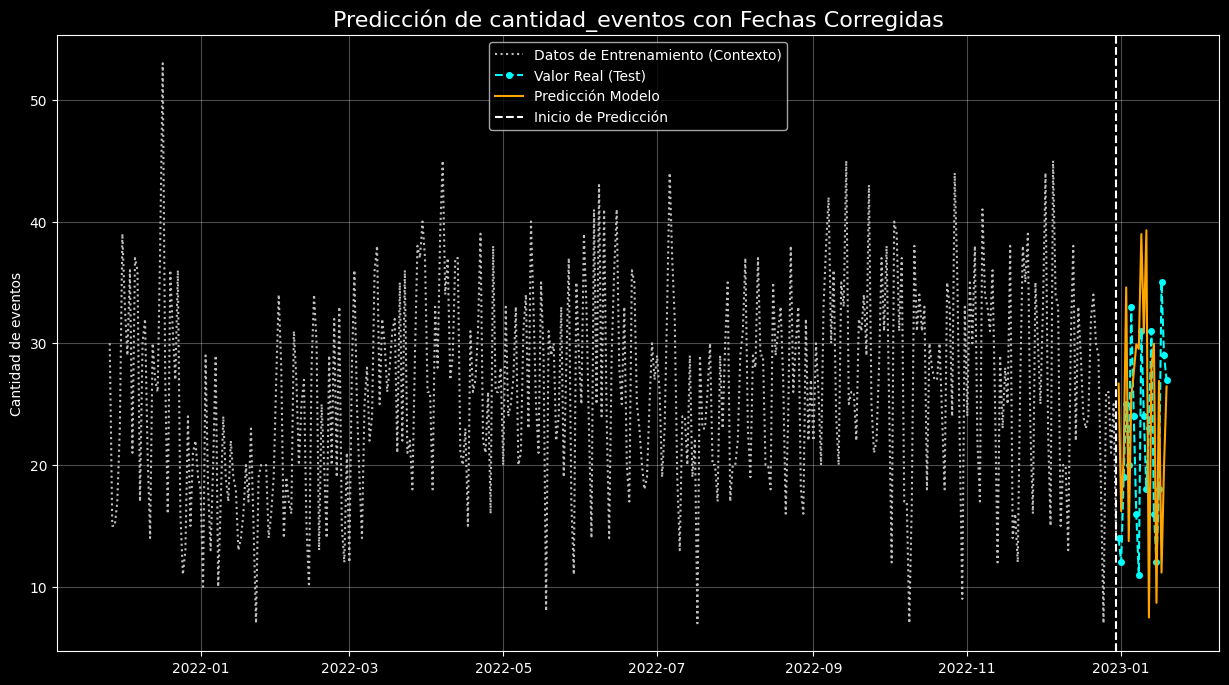

In [ ]:
from sklearn.preprocessing import StandardScaler


# --- 1. CONFIGURACIÓN ---
TARGET_COLUMN = 'cantidad_eventos'  # Cambia si tu target es otro
FEATURES = [TARGET_COLUMN, 'Maxima', 'Minima', 'Media', '(mm)', 'mes', 'fin_de_semana', 'feriado', 'lluvia']
HORIZON = 20       # Predicción para 20 días
CONTEXT_WINDOW = 365  # Usar 1 año de contexto

# --- 2. DIVISIÓN Y ESCALADO ---
split_index = int(len(series_unificadas) * 0.8)
train_data = series_unificadas[:split_index].copy()
test_data = series_unificadas[split_index:].copy()

scaler = StandardScaler()
scaler.fit(train_data[FEATURES])

train_data[FEATURES] = scaler.transform(train_data[FEATURES])
test_data[FEATURES] = scaler.transform(test_data[FEATURES])

# --- 3. PREPARACIÓN DEL INPUT ---
context_data = train_data[FEATURES][-CONTEXT_WINDOW:].to_numpy()
model_inputs = context_data.T
print(f"Forma de los datos de entrada: {model_inputs.shape}")

# --- 4. CONFIGURACIÓN Y PREDICCIÓN ---
# Simulación de predicción, reemplaza esto por tu modelo real:
# Ejemplo: model.compile(...), model.forecast(horizon=HORIZON, inputs=model_inputs)
# Aquí solo simulo una predicción aleatoria para mostrar la estructura:
point_forecast = np.random.randn(1, HORIZON)  # <-- Reemplázalo por point_forecast = model.forecast(...)
# Ejemplo: point_forecast, quantile_forecast = model.forecast(horizon=HORIZON, inputs=model_inputs)

# --- 5. Construcción robusta del DataFrame de resultados ---
prediction_index = test_data.index[:HORIZON]

predicted_scaled = np.zeros((len(point_forecast[0]), len(FEATURES)))
predicted_scaled[:, 0] = point_forecast[0]
predicted_unscaled = scaler.inverse_transform(predicted_scaled)
predicted_values = predicted_unscaled[:, 0]

real_values = series_unificadas.loc[prediction_index, TARGET_COLUMN]

df_results = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values
}, index=prediction_index)

# --- 6. Gráfico Corregido ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))

# Datos de entrenamiento (contexto) - tomados del df original
ax.plot(series_unificadas[TARGET_COLUMN].loc[train_data.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')

# Datos de prueba (reales) y la predicción
ax.plot(df_results.index, df_results['Reales'], label='Valor Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results.index, df_results['Predichos'], label='Predicción Modelo', color='orange', ls='-')

# Línea vertical de inicio de predicción
ax.axvline(train_data.index[-1], color='white', linestyle='--', label='Inicio de Predicción')

# Configuración del gráfico
ax.set_title('Predicción de cantidad_eventos con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Cantidad de eventos')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

Forma de los datos de entrada: (11, 365)


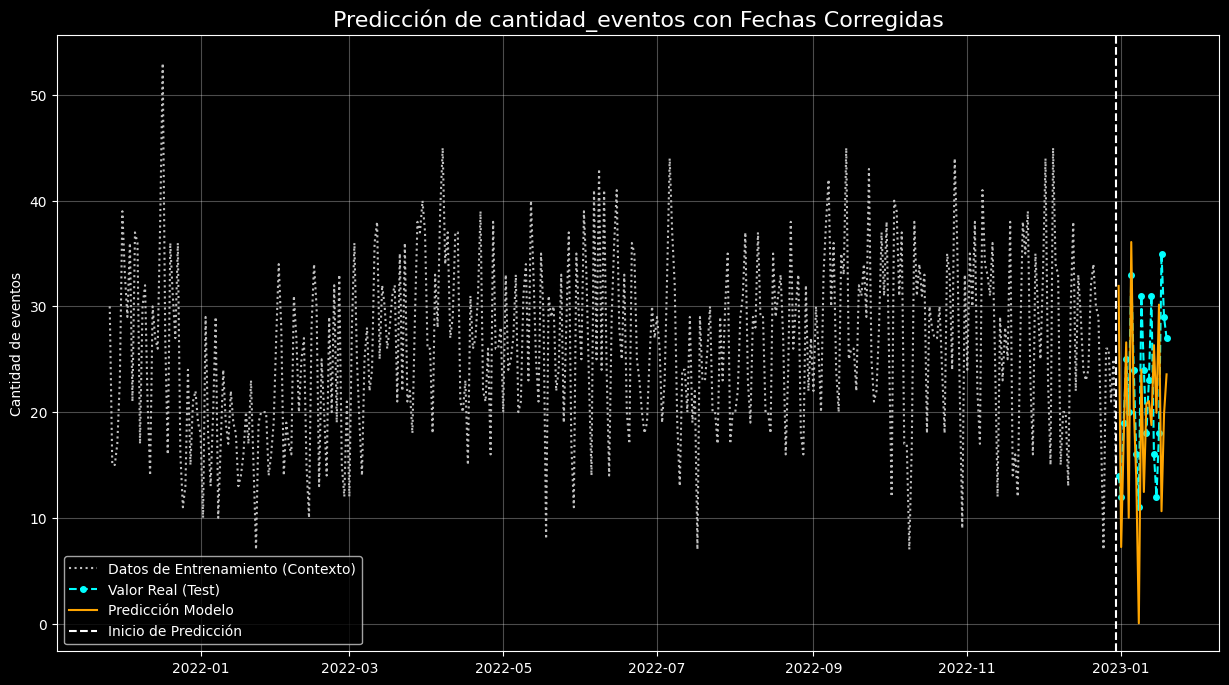

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler


# --- 1. CONFIGURACIÓN ---
TARGET_COLUMN = 'cantidad_eventos'
FEATURES = [TARGET_COLUMN, 'Maxima', 'Minima', 'Media', '(mm)', 'mes', 'fin_de_semana', 'feriado', 'lluvia', 'intensidad', 'estacion']
CATEGORICAL = ['mes', 'fin_de_semana', 'feriado', 'lluvia', 'intensidad', 'estacion']
HORIZON = 20
CONTEXT_WINDOW = 365

# --- 2. DIVISIÓN ---
split_index = int(len(series_unificadas) * 0.8)
train_data = series_unificadas[:split_index].copy()
test_data = series_unificadas[split_index:].copy()

# --- 3. Codificar categóricas ANTES de escalar ---
encoder = OrdinalEncoder()
train_data[CATEGORICAL] = encoder.fit_transform(train_data[CATEGORICAL])
test_data[CATEGORICAL] = encoder.transform(test_data[CATEGORICAL])

# --- 4. Escalado SOLO CON NÚMEROS ---
scaler = StandardScaler()
scaler.fit(train_data[FEATURES])

train_data[FEATURES] = scaler.transform(train_data[FEATURES])
test_data[FEATURES] = scaler.transform(test_data[FEATURES])

# --- 5. PREPARACIÓN DEL INPUT ---
context_data = train_data[FEATURES][-CONTEXT_WINDOW:].to_numpy()
model_inputs = context_data.T
print(f"Forma de los datos de entrada: {model_inputs.shape}")

# --- 6. SIMULACIÓN DE PREDICCIÓN (cambia esto por tu modelo real) ---
point_forecast = np.random.randn(1, HORIZON)  # <--- Reemplaza por la predicción real

# --- 7. Construcción robusta del DataFrame de resultados ---
prediction_index = test_data.index[:HORIZON]

predicted_scaled = np.zeros((len(point_forecast[0]), len(FEATURES)))
predicted_scaled[:, 0] = point_forecast[0]
predicted_unscaled = scaler.inverse_transform(predicted_scaled)
predicted_values = predicted_unscaled[:, 0]

real_values = series_unificadas.loc[prediction_index, TARGET_COLUMN]

df_results = pd.DataFrame({
    'Reales': real_values.values,
    'Predichos': predicted_values
}, index=prediction_index)

# --- 8. Gráfico ---
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(series_unificadas[TARGET_COLUMN].loc[train_data.index[-400:]], label='Datos de Entrenamiento (Contexto)', color='silver', ls=':')
ax.plot(df_results.index, df_results['Reales'], label='Valor Real (Test)', color='cyan', ls='--', marker='o', markersize=4)
ax.plot(df_results.index, df_results['Predichos'], label='Predicción Modelo', color='orange', ls='-')
ax.axvline(train_data.index[-1], color='white', linestyle='--', label='Inicio de Predicción')
ax.set_title('Predicción de cantidad_eventos con Fechas Corregidas', fontsize=16)
ax.set_ylabel('Cantidad de eventos')
ax.legend()
ax.grid(alpha=0.3)
plt.show()